In [203]:
# librairies de gestion des chemins d'accès des fichiers/dossiers
import os
from pathlib import Path
import json
import pickle
import timeit

# librairies de manipulation des données tabulaires et itérateurs
import pandas as pd
import numpy as np
from collections import Counter
import itertools

# librairies de manipulation des données textuelles
import nltk
import gensim
import re
import string
from bs4 import BeautifulSoup
import contractions

# librairies de fonctionction statistiques
from scipy import stats

# librairies de visualtion
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
from tqdm.notebook import trange, tqdm
import plotly.express as px
import pprint

# module de chargement de fonctions utiles pour l'ACP
import ACP_functions

In [2]:
# paramètres d'affichage général

pd.set_option('display.max_rows', 100)

# plt.rcParams['figure.figsize'] = [15, 8]

In [2]:
# désactivation de l'affichage des WARNING, INFO et DEBUG

import logging
logging.disable(logging.WARNING) 

In [3]:
# contrôle de la reproductibilité des résultats aléatoires

SEED = 49

In [4]:
# fonction de sauvegarde des images

IMAGES_PATH = Path() / "img" / "test"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
ID_FIG = 0

def save_fig(fig_title, resolution=300):
    fig_id = str(globals()['ID_FIG'])
    path = IMAGES_PATH / f"tests - {fig_id} - {fig_title}.png"
    globals()['ID_FIG']+=1
    plt.savefig(path, format='png', dpi=resolution)

In [5]:
# fonctions de sauvegarde et chargement des résultats intermédiaires qui ne sont pas des dataframes

INTER_RESULTS_PATH = Path() / "datasets" / "tests" / "intermediary_results"
INTER_RESULTS_PATH.mkdir(parents=True, exist_ok=True)

def save_pickle(results, file_name):
    file_path = INTER_RESULTS_PATH / f"{file_name}.pkl"
    filehandler = open(file_path,"wb")
    pickle.dump(results, filehandler)
    filehandler.close()
    print(f"Fichier enregistré sous le nom '{file_name}' ")

def load_pickle(file_name):
    file_path = INTER_RESULTS_PATH / f"{file_name}.pkl"
    file = open(file_path,'rb')
    globals()[file_name] = pickle.load(file)
    file.close()
    print(f"Variable créée sous le nom '{file_name}' ")

In [23]:
# %%time
# raw_queries = pd.read_pickle('datasets/raw_queries.pkl')

CPU times: total: 4.09 s
Wall time: 6.16 s


In [24]:
# %%time
# df = raw_queries.copy()
# df.sort_values('creation_date', inplace=True)
# df.reset_index(drop=True, inplace=True)

CPU times: total: 2 s
Wall time: 2.05 s


# Pré-traitement des données et feature engineering

Avant d'aborder la problématique du projet de manière non supervisée puis supervisée, nous allons réaliser plusieurs pré-traitements des données qui nous serviront à comparer les résultats avec chacun des approches, puis nous comparerons les résultats obtenus dans les meilleures configurations de chaque approche et nous déciderons du modèle final que nous déploierons sous forme d'API afin qu'il puisse être utilisé par les utilisateurs novices de **StackOverFlow**.

**NB** : Dans un premier temps, nous allons conserver tous les posts de notre jeu de données, et nous verrons dans un second temps si nous pourrons améliorer les performances de nos modèles en ne conservant que les posts avec un certain niveau de score ou nombre de réponses ou de vues ou une combinaison de tous ces critères à la fois.

## Conservation des paragraphes des corps des posts uniquement

In [6]:
def keep_text_from_tags(html, tags=['p']):
    """
        But :
        
        Analyse le contenu HTML et extrait le contenu textuel des balises passées en argument.
        
        Arguments :
        
        htmt : document au format HTML.
        tags : list des balises dont l'on veut extraire le contenu textuel.
        
        Valeur retournée :
        
        Une chaîne de caractère issue de la jointure des contenus textuels des différentes balises analysées.
    """
    
    soup = BeautifulSoup(html, "lxml")
    
    list_text = list()
    
    for tag in tags:
        list_text.extend([x.get_text() for x in soup.find_all(tag)])
 
    
    return ' '.join(list_text)

In [6]:
# df_datas['body'] = df_datas['body'].apply(keep_text_from_tags)

## Nettoyage du texte

Cette étape est constituée des tâches suivantes :

   1. **Formattage** : Passsage en minuscule de tout le texte (dans un second temps, nous pourrons conserver la trace des mots comprennant des majuscules pour voir si cela améliore les performances de nos modèles)
   2. **Othographe** : Corriger les fautes d'orthographes ainsi que les abréviations argotiques
   3. **Suppression du bruit** : Suppression des caractères spéciaux, ponctuations, caractères non-ASCII, URL, balises HTML...
   4. **Filtre syntaxique** : Tri des mots et conservation des noms uniquement (POS_tagging)
   

In [7]:
# 1. FORMATTAGE

# df_datas = df_datas.apply(lambda x: x.str.lower())

In [8]:
# 2. ORTHOGRAPHE

# df_datas['title'] = df_datas['title'].apply(lambda x: contractions.fix(x))
# df_datas['body'] = df_datas['body'].apply(lambda x: contractions.fix(x))

In [9]:
# df_contractions = df_datas.merge(df_target, right_index=True, left_index=True)
# df_contractions.to_csv('datasets/tests/df_contractions.csv', index=False)

In [40]:
df_contractions = pd.read_csv("datasets/tests/df_contractions.csv")
df_datas = df_contractions.copy().dropna()

In [7]:
def remove_punct(text):
    """"
        But :
        
        Supprimer les caractères spéciaux ainsi que la ponctuation, les caractères non-ASCII à l'exception de c++ et c#.
        
        Arguments :
        
        text : texte à nettoyer.
        
        Valeur retournée :
        
        Texte nettoyé.
    """
    
    pattern_1 = re.compile(r'[^\w]|[\d_]')
    pattern_2 = re.compile(r'[^\x00-\x7f]')
    
    exceptions = ['c++', 'c#']
    
    text_splitted = text.split()
    
    try:
        text_splitted = [re.sub(pattern_1,"", text) for text in text_splitted if not text in exceptions]
        text_splitted = [re.sub(pattern_2,"", text) for text in text_splitted]
    except TypeError:
        return text
    
    return " ".join(text_splitted)

In [42]:
df_datas['title'] = df_datas['title'].apply(remove_punct)

In [43]:
df_datas['body'] = df_datas['body'].apply(remove_punct)

In [44]:
df_datas

title  \
0         modifying bonita process instance after started   
1            what does elevation in drawshadow do exactly   
2       how to use a trait object that contains a meth...   
3       a way for users to store selections as inputs ...   
4       how to open downloaded photo using gallery app...   
...                                                   ...   
999995  can you do a pull in a mongodb bulk write whic...   
999996      non static method cannot be called statically   
999997  sorting oslistdirs arbitrary order for desired...   
999998                    big o complexity of nested loop   
999999  how to convert comma separated string to list ...   

                                                     body  \
0       is it possible to change the processinstance c...   
1       i know that flutters canvasdrawshadow translat...   
2       what is the correct way to use a trait object ...   
3       i am trying to create a way in which a user ca...   
4       i am facing a problem cannot figure out how to...   
...                                                   ...   
999995  version mongodb v  i have the following mongod...   
999996  i am so lost with how to get this working all ...   
999997  image of txt files in folder i currently posse...   
999998  what could be the big o of this code i thought...   
999999  i have a single quoted string for items separa...   

                                                   tags  
0                                                bonita  
1                                 c++|flutter|dart|skia  
2                                                  rust  
3       r|shiny|shiny-server|shiny-reactivity|shinyapps  
4                      react-native|linker|expo|gallery  
...                                                 ...  
999995                                          mongodb  
999996                                      php|laravel  
999997                              python|list|sorting  
999998                                            big-o  
999999                                           python  

[999120 rows x 3 columns]

On peut observer que certains tags contiennent plusieurs mentions d'un même sujet, mais associé à chaque fois à un autre (voir exemple ci-après) : dans ces cas là, nous ne souhaitons garder que les tags principaux.

In [53]:
test = 	'r|shiny|shiny-server|shiny-reactivity|shinyapps'
{re.split(r'[^\w]|[\d_]',x)[0] if (not x in ['c++', 'c#']) else x for x in test.split('|')}

{'r', 'shiny', 'shinyapps'}

In [8]:
def split_tags(tags):
    """
        But :
        
            Splitter la chaîne de caractères autour de l'élément '|', supprimer les caractères spéciaux ainsi que la ponctuation, 
            les caractères non-ASCII, à l'exception de c++ et c#.
        
        Arguments :
        
            tags : tag à nettoyer.
        
        Valeur retournée :
        
            Liste de tags nettoyés.
    """
    
    pattern_1 = re.compile(r'[^\w]|[\d_]')
    pattern_2 = re.compile(r'[^\x00-\x7f]')
    
    exceptions = ['c++', 'c#']
    
    tags_splitted = tags.split('|')
    
    try:
        tags_splitted = [re.sub(pattern_2,"", tag) for tag in tags_splitted]
        tags_splitted = [re.split(pattern_1, tag)[0] if (not tag in ['c++', 'c#']) else tag for tag in tags_splitted]
        tags_splitted = sorted({tag for tag in tags_splitted if tag != ''})
    except TypeError:
        return tags
    
    return tags_splitted

In [80]:
for tags in df_datas['tags'].sample(20).values :
    print(f"original : {tags} \ntransformed :{split_tags(tags)}\n")

original : php|function|codeigniter|count|codeigniter-4 
transformed :['codeigniter', 'count', 'function', 'php']

original : docker|caching|npm|docker-build 
transformed :['caching', 'docker', 'npm']

original : mysql|sql|date|datetime|time 
transformed :['date', 'datetime', 'mysql', 'sql', 'time']

original : javascript|stripe-payments|payment-gateway 
transformed :['javascript', 'payment', 'stripe']

original : snowflake-cloud-data-platform|dbt 
transformed :['dbt', 'snowflake']

original : c++|mingw|libcurl 
transformed :['c++', 'libcurl', 'mingw']

original : reactjs|typescript|react-native 
transformed :['react', 'reactjs', 'typescript']

original : azure|azure-devops|azure-pipelines 
transformed :['azure']

original : python|numpy 
transformed :['numpy', 'python']

original : rust|pattern-matching 
transformed :['pattern', 'rust']

original : flutter|dart|flutter-dependencies 
transformed :['dart', 'flutter']

original : github|google-cloud-platform|google-cloud-functions|terraf

Le résultat est plutôt satisfaisant dans l'ensemble, mais il faudrait construire un dictionnaire plus exhaustif pour que la fonction soit optimale.

Par exemple, il est dommage de se retrouver avec 'deep' seulement lorsque l'on a 'deep-learning', ou 'machine' lorsque l'on a 'machine-learning' ou encore 'computer' à la place de 'computer-vision', 'visual' à la place de 'visual-studio'...

Cela pourrait amener nos modèles à confondre le résultat de notre fonction avec des tags unitaires saisis par l'utilisateur et qui n'ont rien à voir (un post sur le sujet de front-end et utilisant le tag 'visual' n'a rien à voir avec un post qui demande de l'aide sur une fonctionnalité avancée de 'visual-studio').

In [81]:
df_datas['tags'] = df_datas['tags'].apply(split_tags)
df_datas

title  \
0         modifying bonita process instance after started   
1            what does elevation in drawshadow do exactly   
2       how to use a trait object that contains a meth...   
3       a way for users to store selections as inputs ...   
4       how to open downloaded photo using gallery app...   
...                                                   ...   
999995  can you do a pull in a mongodb bulk write whic...   
999996      non static method cannot be called statically   
999997  sorting oslistdirs arbitrary order for desired...   
999998                    big o complexity of nested loop   
999999  how to convert comma separated string to list ...   

                                                     body  \
0       is it possible to change the processinstance c...   
1       i know that flutters canvasdrawshadow translat...   
2       what is the correct way to use a trait object ...   
3       i am trying to create a way in which a user ca...   
4       i am facing a problem cannot figure out how to...   
...                                                   ...   
999995  version mongodb v  i have the following mongod...   
999996  i am so lost with how to get this working all ...   
999997  image of txt files in folder i currently posse...   
999998  what could be the big o of this code i thought...   
999999  i have a single quoted string for items separa...   

                                  tags  
0                             [bonita]  
1           [c++, dart, flutter, skia]  
2                               [rust]  
3                [r, shiny, shinyapps]  
4       [expo, gallery, linker, react]  
...                                ...  
999995                       [mongodb]  
999996                  [laravel, php]  
999997         [list, python, sorting]  
999998                           [big]  
999999                        [python]  

[999120 rows x 3 columns]

In [30]:
# Tokenization
from nltk.tokenize import word_tokenize

In [86]:
df_datas['tokens'] = df_datas.apply(lambda x: x['title'] + x['body'], axis=1)

df_datas['tokens'] = df_datas['tokens'].apply(word_tokenize)

df_datas

title  \
0         modifying bonita process instance after started   
1            what does elevation in drawshadow do exactly   
2       how to use a trait object that contains a meth...   
3       a way for users to store selections as inputs ...   
4       how to open downloaded photo using gallery app...   
...                                                   ...   
999995  can you do a pull in a mongodb bulk write whic...   
999996      non static method cannot be called statically   
999997  sorting oslistdirs arbitrary order for desired...   
999998                    big o complexity of nested loop   
999999  how to convert comma separated string to list ...   

                                                     body  \
0       is it possible to change the processinstance c...   
1       i know that flutters canvasdrawshadow translat...   
2       what is the correct way to use a trait object ...   
3       i am trying to create a way in which a user ca...   
4       i am facing a problem cannot figure out how to...   
...                                                   ...   
999995  version mongodb v  i have the following mongod...   
999996  i am so lost with how to get this working all ...   
999997  image of txt files in folder i currently posse...   
999998  what could be the big o of this code i thought...   
999999  i have a single quoted string for items separa...   

                                  tags  \
0                             [bonita]   
1           [c++, dart, flutter, skia]   
2                               [rust]   
3                [r, shiny, shinyapps]   
4       [expo, gallery, linker, react]   
...                                ...   
999995                       [mongodb]   
999996                  [laravel, php]   
999997         [list, python, sorting]   
999998                           [big]   
999999                        [python]   

                                                   tokens  
0       [modifying, bonita, process, instance, after, ...  
1       [what, does, elevation, in, drawshadow, do, ex...  
2       [how, to, use, a, trait, object, that, contain...  
3       [a, way, for, users, to, store, selections, as...  
4       [how, to, open, downloaded, photo, using, gall...  
...                                                   ...  
999995  [can, you, do, a, pull, in, a, mongodb, bulk, ...  
999996  [non, static, method, can, not, be, called, st...  
999997  [sorting, oslistdirs, arbitrary, order, for, d...  
999998  [big, o, complexity, of, nested, loopwhat, cou...  
999999  [how, to, convert, comma, separated, string, t...  

[999120 rows x 4 columns]

In [17]:
# df_datas.to_pickle("datasets/tests/df_datas.pkl")
df_datas = pd.read_pickle("datasets/tests/df_datas.pkl")

In [18]:
df = df_datas[['tokens', 'tags']].copy()

In [57]:
# nous retirons les stopwords usuels en anglais

from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

In [20]:
df['tags'] = df['tags'].apply(lambda x: [word for word in x if not word in stopwords])

In [21]:
df['tokens'] = df['tokens'].apply(lambda x: {word for word in x if not word in stopwords})

In [97]:
df

tokens  \
0       {bonita, processinstance, possible, instance, ...   
1       {see, additionally, completely, ensure, affect...   
2       {correct, trait, resolve, bar, either, underst...   
3       {create, many, steps, want, usei, app, name, u...   
4       {find, want, external, app, using, shows, phot...   
...                                                   ...   
999995  {update, single, bulkwrite, array, script, run...   
999996  {staticallyi, static, lost, want, looking, app...   
999997  {find, sort, capture, best, using, folder, alp...   
999998  {n, like, big, also, loopwhat, looks, code, ne...   
999999  {contain, water, single, using, coffee, surrou...   

                                  tags  
0                             [bonita]  
1           [c++, dart, flutter, skia]  
2                               [rust]  
3                [r, shiny, shinyapps]  
4       [expo, gallery, linker, react]  
...                                ...  
999995                       [mongodb]  
999996                  [laravel, php]  
999997         [list, python, sorting]  
999998                           [big]  
999999                        [python]  

[999120 rows x 2 columns]

In [59]:
# nous supprimmons les mots dont la longueur est inférieure ou égale à 3 caractères à moins qu'ils constituent un tag

# nous récupérons la liste des tags dont la longueur est inférieure ou égale à 3 caractères
dict_pos_tags = json.load(open('dictionnaries/dict_position_tags.json'))
list_short_tags = [tags for tags in dict_pos_tags.keys() if len(tags) <=3]

In [23]:
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if (len(word)>3 or word in list_short_tags)])

In [106]:
tokenized_docs = df['tags'].values
tags = Counter()
for token in tokenized_docs:
    tags.update(token)

In [109]:
len(tags)

20889

Nous sommes passés de **39139** à près de la moitié à ce stade du nettoyage des données.

In [ ]:
bag_of_tags = ' '.join([' '.join(x) for x in df['tags'].to_list()])

wordcloud = WordCloud(width=2048, height=2048, background_color="white", max_words=50).generate(bag_of_tags)

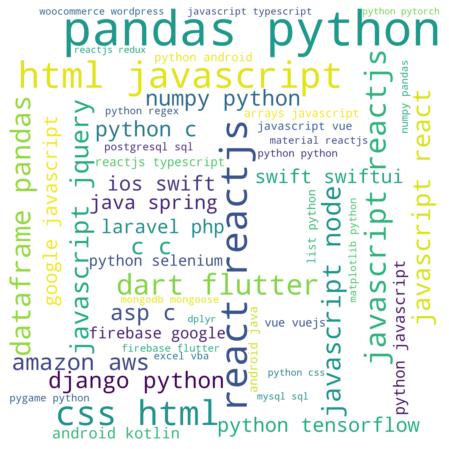

In [112]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [12]:
# 4. Filtre syntaxique

from nltk.corpus import wordnet
from nltk.corpus import brown

wordnet_map = {"N":wordnet.NOUN}

train_sents = brown.tagged_sents(categories='learned')

t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

Étant donné le caractère technologique et technique des mots de notre corpus, nous décidons d'entraîner un tagger sur les documents de la catégorie *LEARNED* du corpus **Brown**, qui regroupe 80 textes dans les domaines des sciences, de la technologie et de l'ingénirie : nous espérons ainsi créer un tagger qui sera mieux à même de reconnaître correctement la nature des mots de notre corpus.

In [13]:
def pos_tag_nouns(tokens):
    """
        But :
        
            Filtrer les tokens de type "nom"
        
        Arguments :
        
            tokens : tokens à analyser.
        
        Valeur retournée :
        
            Liste des tokens de type "nom"
    """
    pos_tagged_tokens = t2.tag(tokens)
    
    nouns = [word for (word, pos_tag) in pos_tagged_tokens if (pos_tag[0] in wordnet_map.keys())]
    
    return nouns

In [28]:
df['tokens'] = df['tokens'].apply(pos_tag_nouns)

In [29]:
# df.to_pickle("datasets/tests/df_datas_nouns.pkl")

Toujours dans un soucis de diminuer la taille de notre vocabulaire, nous allons maintenant conserver uniquement les lemmes des tokens de notre corpus :

In [10]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [159]:
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [160]:
df

tokens  \
0       [bonita, processinstance, instance, process, d...   
1       [additionally, information, elevation, impleme...   
2       [trait, error, circumstance, way, code, object...   
3       [step, usei, name, panel, clicked, checkboxes,...   
4       [photo, screen, google, default, problem, phot...   
...                                                   ...   
999995  [update, bulkwrite, array, script, example, hi...   
999996  [staticallyi, approach, calculation, rename, b...   
999997  [sort, capture, folder, outputimage, oslistdir...   
999998            [n, loopwhat, code, nested, complexity]   
999999  [water, coffee, comma, item, pythoni, text, py...   

                                  tags  
0                             [bonita]  
1           [c++, dart, flutter, skia]  
2                               [rust]  
3                [r, shiny, shinyapps]  
4       [expo, gallery, linker, react]  
...                                ...  
999995                       [mongodb]  
999996                  [laravel, php]  
999997         [list, python, sorting]  
999998                           [big]  
999999                        [python]  

[999120 rows x 2 columns]

A ce stade, vérifions si notre nettoyage de données à généré des valeurs vides dans nos colonnes :

In [163]:
df[df['tags'].map(len)==0]

tokens tags
60      [htaccessi, url, help, format, htaccess, redir...   []
855     [parameter, pedestrian, route, google, matrix,...   []
1217    [section, releasedebug, configured, filesdotne...   []
1758    [lib, trick, system, reference, mean, netstand...   []
3684    [description, memory, javascript, image, page,...   []
...                                                   ...  ...
985273  [caching, image, wondering, image, folderi, fo...   []
993425  [ajax, chart, graph, channelactivecallsgavgtim...   []
994752  [image, httpscodesandboxiosintelligentfasteowu...   []
998388  [redirection, rule, errori, rewrite, redirecte...   []
998949  [element, microsofts, tabbar, info, look, andr...   []

[523 rows x 2 columns]

In [168]:
df_contractions.loc[df[df['tags'].map(len)==0].index, 'tags'].unique()

array(['.htaccess', 'here-api', '.net-core', '.net-core|.net-standard',
       'd3.js', '.net|.net-core', 'here-api|here-maps-rest', '.net',
       'd3.js|d3fc', 'd3fc',
       '.net-standard|.net-core-3.1|.net-standard-2.1', 'or-tools',
       '.net-core|.net-assembly', 'in-app-purchase', '5g', 'can-bus',
       'after-effects', '.net|.net-standard|.net-standard-2.0',
       '.net-traceprocessing', 'd3.js|d3-force-directed',
       '.net-core|.net-core-configuration', '2sxc', 'for-loop', '6502',
       '.net|.net-framework-version', 'here-olp', 'was',
       '.net-core|.net-core-3.1', '.net-core-3.1', 'm4', 'd3.js|d3.geo',
       '.net|.net-core|.net-5', 's6', '.netrc', 'm3u8', 'd', 'i3', '3cx',
       '.net-5', 'i18next', '.net|.net-core|.net-standard-2.1', 'i2c',
       '.net|.net-core|.net-standard', 's3fs',
       '.net-core|.net-5|.net-core-publishsinglefile', '.net|.net-5',
       '.net|.net-5|.net-4.8', 'm2doc', '.net-core|.net-5',
       'at-sign|at-platform|at-protocol', 'do1

De toute évidence, il faudrait ajouter les termes **'.net'** et **'.htaccess'** à la liste des exceptions de notre fonction **split_tags** .

In [164]:
df[df['tokens'].map(len)==0]

tokens              tags
920273     []  [arrays, python]

In [180]:
df_contractions.loc[df[df['tokens'].map(len)==0].index, 'title'].values[0]

'why am i getting res as [[2,3],[2,3]] and not as [[1,4],[2,3]]?'

In [181]:
df_contractions.loc[df[df['tokens'].map(len)==0].index, 'body'].values[0]

'why am i getting res as [[2,3],[2,3]] and not as [[1,4],[2,3]] ? '

Il s'agit d'un cas très particulier car le titre du post est identique au corps du post, et aucun des 2 ne comporte de nom traitable comme élément technique.

> Nous supprimons les posts ayant des valeurs vides.

In [185]:
df[df['tags'].map(len)==0].index

Int64Index([    60,    855,   1217,   1758,   3684,   6636,   7365,   8230,
              8316,   8891,
            ...
            981252, 983238, 983888, 984447, 984513, 985273, 993425, 994752,
            998388, 998949],
           dtype='int64', length=523)

In [186]:
df.drop(index=df[df['tags'].map(len)==0].index, inplace=True)
df.drop(index=df[df['tokens'].map(len)==0].index, inplace=True) 

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998596 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tokens  998596 non-null  object
 1   tags    998596 non-null  object
dtypes: object(2)
memory usage: 22.9+ MB


In [189]:
# df.to_pickle("datasets/tests/lemmatized_datas.pkl")

In [21]:
df_lemmas = pd.read_pickle("datasets/tests/lemmatized_datas.pkl")

In [14]:
# df_unsupervised = pd.DataFrame(df_lemmas['tokens'].copy())
# df_unsupervised.to_pickle("datasets/tests/df_unsupervised.pkl")

In [6]:
df_unsupervised = pd.read_pickle("datasets/tests/df_unsupervised.pkl")

## Vocabulaire du corpus nettoyé

In [7]:
tokenized_docs = df_unsupervised["tokens"].values
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [8]:
len(vocab)

1379766

In [247]:
pd.DataFrame(vocab.most_common(50))

0       1
0          code  337206
1         error  244678
2          work  236083
3          file  193331
4         value  193096
5       example  159005
6          data  158719
7       problem  154940
8      function  143934
9          time  106299
10       thanks  105961
11       column  104730
12         user  102250
13       change   97900
14       output   95913
15        issue   95608
16     question   94798
17         type   87230
18       object   87153
19       method   86012
20         line   78660
21         list   78523
22       number   76629
23         name   75729
24        class   74254
25     solution   74009
26         case   71986
27       string   71755
28        table   70629
29       python   69679
30        image   68109
31          row   67978
32        array   66647
33         page   66627
34      project   65991
35       return   64355
36      version   63059
37         idea   62749
38         need   61752
39  application   59019
40      element   57486
41         test   57385
42      message   56943
43          api   56347
44       update   53857
45        input   53553
46        query   51602
47       server   51471
48    component   49837
49         text   48988

# Approche non-supervisée

Nous allons essayer 3 méthodes non-supervisées : 

   1. **Latent Dirichlet Allocation** : qui consiste à extraire de l'ensemble des documents un certain nombre de sujets caractérisés par un ensemble de mots restreint (<u>*approche probabiliste*</u>).

   
   2. **Non-Negative Matrix Factorisation** : l'objectif de cette méthode est similaire à celle du **LDA**, mais dans une approche totalement <u>*algébrique*</u>.

L'objectif dans les 2 cas est de trouver le nombre de sujets qui permet d'obtenir la **cohérence maximale** entre les mots caractéristiques des sujets (*proximité sémantique*).

> Chaque document se verra alors projeter comme un vecteur dans la base des sujets détectés et chaque sujet discerné comme un vecteur dans la base des tokens du corpus.

> Nous pourrons alors utiliser les mots les plus caractéristiques de chaque sujet pour les assigner en tant que tags à de nouveaux documents vectorisés.

Afin de les rendre exploitables par nos modèles statistiques, nous devons numériser nos données textuelles nettoyées : 

   1. **Bag-of-word** pour le **LDA** : nous indiquons tout simplement le nombre d'occurences de chaque token dans chacun des documents.
   2. **TF-IDF** pour le **NMF** : nous associons à chaque token une mesure d'autant plus élevée qu'il est fréquent dans un document, mais d'autant plus faible qu'il se retrouve dans de nombreux documents.

### Score de cohérence

Bien que la métrique de score de cohérence *c_v* soit populaire car c'est la métrique par défaut dans le module **Topic_Modelling** de **Gensim**, elle présente toutefois quelques problèmes.

Son auteur recommande même de lui préférer d'autres métriques [1] , conseil que nous allons suivre : il propose les scores *c_p*, *c_npmi* ou *c_uci*, dans notre cas, en utilisant la librairie **Gensim**, la métrique <b>*c_uci*</b> est la plus rapide à calculer, c'est celle que nous choisissons [2].

[1] https://github.com/dice-group/Palmetto/issues/13#issuecomment-371553052

[2] https://radimrehurek.com/gensim/models/coherencemodel.html#gensim.models.coherencemodel.CoherenceModel

In [11]:
import gensim
from gensim.test.utils import datapath
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import Nmf, CoherenceModel

import multiprocessing
cores = multiprocessing.cpu_count()-1

### Latent Dirichlet Allocation

Nous utilisons le modèle **Ldamulticore** de **Gensim** qui permet de paralléliser les calculs sur tous les coeurs disponibles (-1) de notre processeur afin d'accélérer l'entraînement du modèle, ce qui n'est pas négligeable étant donnée le volume de donnes que nous avons à traiter ici.

In [51]:
def compute_coherence_values_LDA(dictionary, bow_corpus, corpus, nb_topics_max=100, nb_topics_start=2, step=3):
    """
        But :

            Calculer le score de cohérence des topics déterminés par le modèle LDA pour une plage de valeur 
            du nombre de topics donnée

        Arguments :

            dictionnary : dictionnaire des tokens du corpus
            bow_corpus : ensemble des bag-of-words obtenus sur chacun des documents du corpus
            corpus : liste de l'ensemble des documents (liste de liste de tokens)
            nb_topics_max : nombre de topics 

        Valeurs retournées :

            LDA_optimal : modèle LDA ayant obtenu le meilleur score de cohérence
            coherence_values : liste des valeurs du score de cohérence obtenus pour les différentes valeurs du nombre
                               de topics étudiées
    """
    
    coherence_values = []
    model_list = []
    
    for nb_topics in trange(nb_topics_start, nb_topics_max, step):
        
        model = LdaMulticore(corpus=bow_corpus,
                             id2word=dictionary,
                             num_topics=nb_topics, 
                             random_state=SEED,
                             passes=10,
                             workers=cores)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=corpus, dictionary=dictionary, coherence='c_uci')
        coherence_values.append(round(coherencemodel.get_coherence(),3))
        
        LDA_optimal = model_list[np.argmax(coherence_values)]

    return LDA_optimal, coherence_values

In [34]:
corpus_unsupervised = df_unsupervised['tokens'].to_list()

id2word_unsupervised = corpora.Dictionary(corpus_unsupervised)
id2word_unsupervised.filter_extremes(no_below=1000)

bow_corpus_unsupervised = [id2word_unsupervised.doc2bow(doc) for doc in corpus_unsupervised]

In [35]:
# save_pickle(id2word_unsupervised, "id2word_unsupervised")
# save_pickle(bow_corpus_unsupervised, "bow_corpus_unsupervised")

Fichier enregistré sous le nom 'id2word_unsupervised' 
Fichier enregistré sous le nom 'bow_corpus_unsupervised' 


In [36]:
load_pickle("id2word_unsupervised")
load_pickle("bow_corpus_unsupervised")

Variable créée sous le nom 'id2word_unsupervised' 
Variable créée sous le nom 'bow_corpus_unsupervised' 


In [54]:
LDA_optimal, coherence_values_LDA = compute_coherence_values_LDA(dictionary=id2word, bow_corpus=bow_corpus, corpus=corpus, nb_topics_max=50, nb_topics_start=2, step=4)

  0%|          | 0/12 [00:00<?, ?it/s]

In [154]:
save_pickle(coherence_values_LDA, "coherence_values_LDA")

Fichier enregistré sous le nom coherence_values_LDA


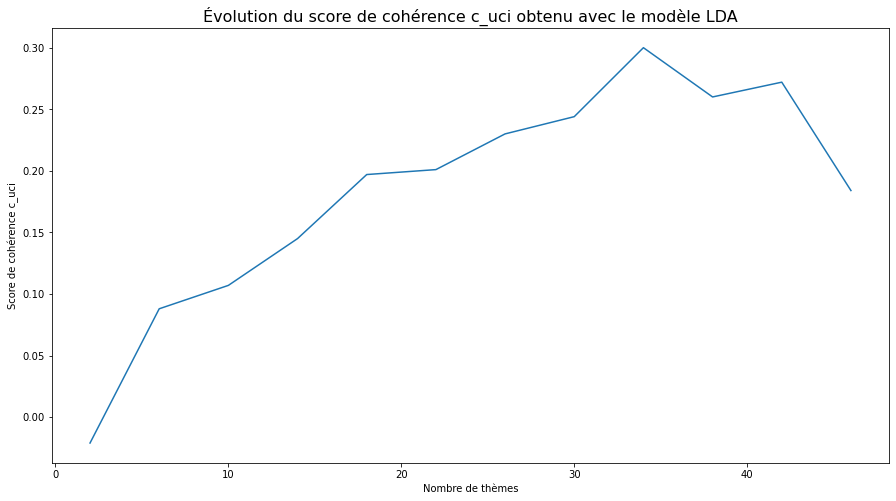

Thème n° 2 . Score de cohérence : -0.021
Thème n° 6 . Score de cohérence : 0.088
Thème n° 10 . Score de cohérence : 0.107
Thème n° 14 . Score de cohérence : 0.145
Thème n° 18 . Score de cohérence : 0.197
Thème n° 22 . Score de cohérence : 0.201
Thème n° 26 . Score de cohérence : 0.23
Thème n° 30 . Score de cohérence : 0.244
Thème n° 34 . Score de cohérence : 0.3
Thème n° 38 . Score de cohérence : 0.26
Thème n° 42 . Score de cohérence : 0.272
Thème n° 46 . Score de cohérence : 0.184


In [63]:
limit=50
start=2
step=4
x = range(start, limit, step)
plt.plot(x, coherence_values_LDA)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_uci")
plt.title("Évolution du score de cohérence c_uci obtenu avec le modèle LDA", fontsize=16)
plt.show()

for i, c_uci in zip(x, coherence_values_LDA):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

Assurons nous que le score de cohérence *c_uci* ne prend pas de de plus grandes valeurs pour des nombres de thème plus élevés.

In [57]:
LDA_optimal_100, coherence_values_LDA_100 = compute_coherence_values_LDA(dictionary=id2word, bow_corpus=bow_corpus, corpus=corpus, nb_topics_max=100, nb_topics_start=50, step=10)

  0%|          | 0/5 [00:00<?, ?it/s]

In [155]:
save_pickle(coherence_values_LDA_100, "coherence_values_LDA_100")

Fichier enregistré sous le nom coherence_values_LDA_100


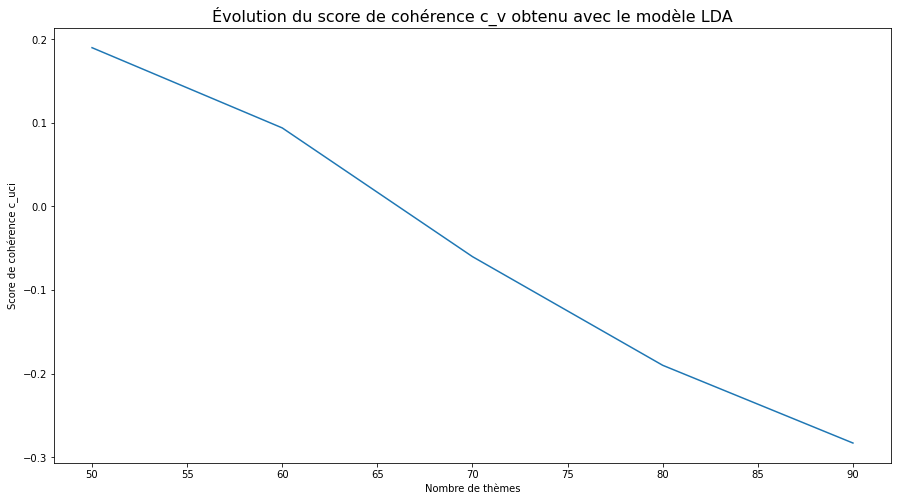

Thème n° 50 . Score de cohérence : 0.19
Thème n° 60 . Score de cohérence : 0.094
Thème n° 70 . Score de cohérence : -0.06
Thème n° 80 . Score de cohérence : -0.19
Thème n° 90 . Score de cohérence : -0.283


In [59]:
limit=100
start=50
step=10
x_100 = range(start, limit, step)
plt.plot(x_100, coherence_values_LDA_100)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_uci")
plt.title("Évolution du score de cohérence c_v obtenu avec le modèle LDA", fontsize=16)
plt.show()

for i, c_uci in zip(x_100, coherence_values_LDA_100):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

Recherche de d'un éventuel optimum caché dans la plage [32,36] :

In [72]:
LDA_optimal_tight, coherence_values_LDA_tight = compute_coherence_values_LDA(dictionary=id2word, bow_corpus=bow_corpus, corpus=corpus, nb_topics_max=37, nb_topics_start=32, step=1)

  0%|          | 0/5 [00:00<?, ?it/s]

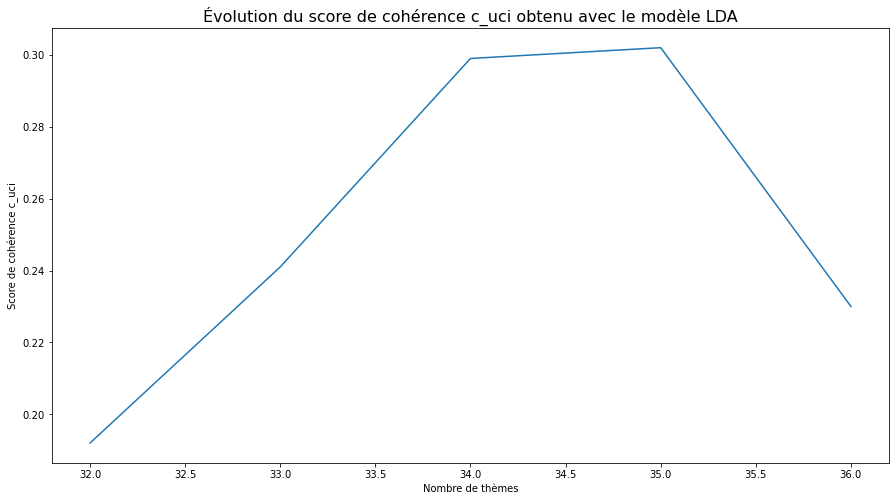

Thème n° 32 . Score de cohérence : 0.192
Thème n° 33 . Score de cohérence : 0.241
Thème n° 34 . Score de cohérence : 0.299
Thème n° 35 . Score de cohérence : 0.302
Thème n° 36 . Score de cohérence : 0.23


In [73]:
limit=37
start=32
step=1
x_tight = range(start, limit, step)
plt.plot(x_tight, coherence_values_LDA_tight)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_uci")
plt.title("Évolution du score de cohérence c_uci obtenu avec le modèle LDA", fontsize=16)
plt.show()

for i, c_uci in zip(x_tight, coherence_values_LDA_tight):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

**Nous avions bien un maximum caché : *C_UCI_max* = 0.302 pour 35 thèmes**.

### Non-negative Matrix Factorisation

In [64]:
def compute_coherence_values_NMF(dictionary, tfidf_corpus, corpus, nb_topics_max=100, nb_topics_start=2, step=3):
    """
        But :

            Calculer le score de cohérence des topics déterminés par le modèle NMF pour une plage de valeur du 
            nombre de topics donnée

        Arguments :

            dictionnary : dictionnaire des tokens du corpus
            tfidf_corpus : ensemble des vecteurs TF-IDF obtenus sur chacun des documents du corpus
            corpus : liste de l'ensemble des documents (liste de liste de tokens)
            nb_topics_max : nombre de topics 

        Valeurs retournées :

            NMF_optimal : modèle NMF ayant obtenu le meilleur score de cohérence
            coherence_values : liste des valeurs du score de cohérence obtenus pour les différentes valeurs du nombre
                               de topics étudiées
    """
    coherence_values = []
    model_list = []
    
    for nb_topics in trange(nb_topics_start, nb_topics_max, step):
        
        model = Nmf(corpus=tfidf_corpus,
                    id2word=dictionary,
                    num_topics=nb_topics, 
                    random_state=SEED,
                    passes=10,
                    normalize=True
                   )

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=corpus, dictionary=dictionary, coherence='c_uci')
        coherence_values.append(round(coherencemodel.get_coherence(),3))
        
        NMF_optimal = model_list[np.argmax(coherence_values)]

    return NMF_optimal, coherence_values

In [ ]:
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

In [156]:
save_pickle(tfidf, "tfidf_unsupervised")
save_pickle(tfidf_corpus, "tfidf_corpus_unsupervised")

Fichier enregistré sous le nom tfidf_unsupervised
Fichier enregistré sous le nom tfidf_corpus_unsupervised


In [16]:
%store -r tfidf
tfidf_corpus = [tfidf[text] for text in bow_corpus]

In [66]:
NMF_optimal, coherence_values_NMF = compute_coherence_values_NMF(dictionary=id2word, tfidf_corpus=tfidf_corpus, corpus=corpus, nb_topics_max=50, nb_topics_start=2, step=4)

  0%|          | 0/12 [00:00<?, ?it/s]

In [157]:
save_pickle(coherence_values_NMF, "coherence_values_NMF")

Fichier enregistré sous le nom coherence_values_NMF


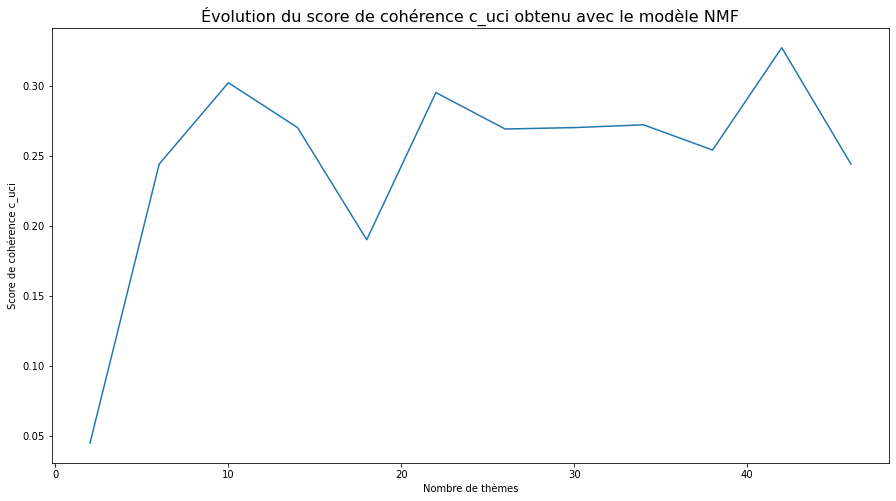

Thème n° 2 . Score de cohérence : 0.045
Thème n° 6 . Score de cohérence : 0.244
Thème n° 10 . Score de cohérence : 0.302
Thème n° 14 . Score de cohérence : 0.27
Thème n° 18 . Score de cohérence : 0.19
Thème n° 22 . Score de cohérence : 0.295
Thème n° 26 . Score de cohérence : 0.269
Thème n° 30 . Score de cohérence : 0.27
Thème n° 34 . Score de cohérence : 0.272
Thème n° 38 . Score de cohérence : 0.254
Thème n° 42 . Score de cohérence : 0.327
Thème n° 46 . Score de cohérence : 0.244


In [68]:
plt.plot(x, coherence_values_NMF)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_uci")
plt.title("Évolution du score de cohérence c_uci obtenu avec le modèle NMF", fontsize=16)
plt.show()

for i, c_uci in zip(x, coherence_values_NMF):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

Assurons nous que le score de cohérence *c_uci* ne prend pas de de plus grandes valeurs pour des nombres de thème plus élevés.

In [69]:
NMF_optimal_100, coherence_values_NMF_100 = compute_coherence_values_NMF(dictionary=id2word, tfidf_corpus=tfidf_corpus, corpus=corpus, nb_topics_max=100, nb_topics_start=50, step=10)

  0%|          | 0/5 [00:00<?, ?it/s]

In [158]:
save_pickle(coherence_values_NMF_100, "coherence_values_NMF_100")

Fichier enregistré sous le nom coherence_values_NMF_100


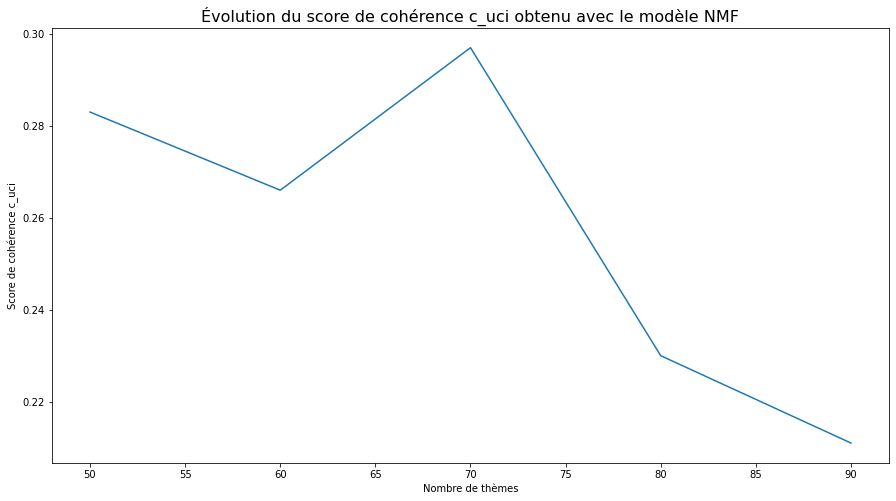

Thème n° 50 . Score de cohérence : 0.283
Thème n° 60 . Score de cohérence : 0.266
Thème n° 70 . Score de cohérence : 0.297
Thème n° 80 . Score de cohérence : 0.23
Thème n° 90 . Score de cohérence : 0.211


In [71]:
plt.plot(x_100, coherence_values_NMF_100)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_uci")
plt.title("Évolution du score de cohérence c_uci obtenu avec le modèle NMF", fontsize=16)
plt.show()

for i, c_uci in zip(x_100, coherence_values_NMF_100):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

Recherche d'un éventuel optimum caché dans la plage [40,44] :

In [74]:
NMF_optimal_tight, coherence_values_NMF_tight = compute_coherence_values_NMF(dictionary=id2word, tfidf_corpus=tfidf_corpus, corpus=corpus, nb_topics_max=45, nb_topics_start=40, step=1)

  0%|          | 0/5 [00:00<?, ?it/s]

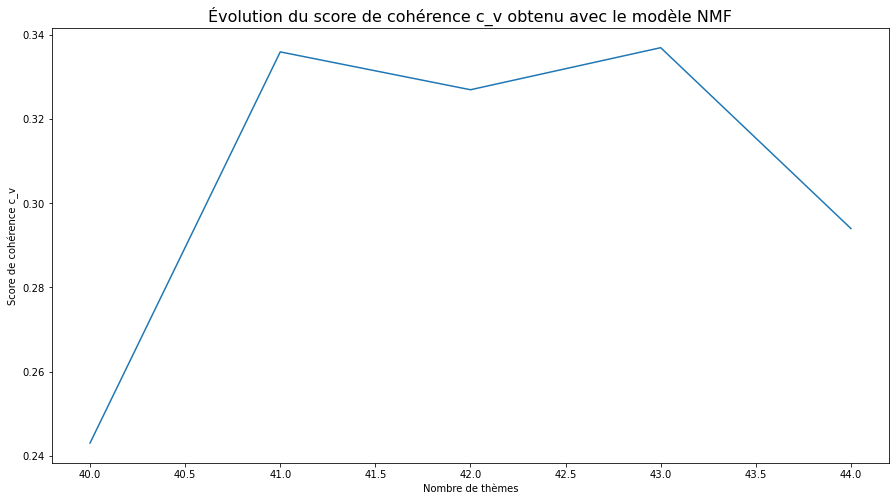

Thème n° 40 . Score de cohérence : 0.243
Thème n° 41 . Score de cohérence : 0.336
Thème n° 42 . Score de cohérence : 0.327
Thème n° 43 . Score de cohérence : 0.337
Thème n° 44 . Score de cohérence : 0.294


In [77]:
x_tight = range(40,45)
plt.plot(x_tight, coherence_values_NMF_tight)
plt.xlabel("Nombre de thèmes")
plt.ylabel("Score de cohérence c_v")
plt.title("Évolution du score de cohérence c_v obtenu avec le modèle NMF", fontsize=16)
plt.show()

for i, c_uci in zip(x_tight, coherence_values_NMF_tight):
    print("Thème n°", i, ". Score de cohérence :", c_uci)

**Nous avions bien un maximum caché : *C_UCI_max* = 0.337 pour 43 thèmes**.

In [10]:
# enregistrement des meilleurs modèles LDA et NMF 

# LDA_optimal_file = datapath("LDA_optimal")
# LDA_optimal_tight.save(LDA_optimal_file)

LDA_optimal_final = LdaMulticore.load(datapath("LDA_optimal"))

# NMF_optimal_file = datapath("NMF_optimal")
# NMF_optimal_tight.save(NMF_optimal_file)

NMF_optimal_final = Nmf.load(datapath("NMF_optimal"))

## Comparaison des 2 approches non-supervisées

### <u>Temps d'entraînement</u>

En dépit de l'utilisation de tous les ressources de calculs disponibles au sein du processeur de l'ordinateur, l'entraînement des 12 premiers modèles **LDA** a prit environ **2,5** fois plus de temps que celui des modèles **NMF** (3h soit ~15 minutes par modèle contre 1h15 soit ~6 minutes par modèle).

Cependant, pour l'entraînement des modèles pour de plus grandes valeurs du nombre de thèmes, cet écart a très grandement diminué :

   1. **LDA** : 1h10 soit 14 minutes par modèle
   2. **NMF** : 1h05 soit 13 minutes par modèle
   
Puis, pour la recherche du maximum :

   1. **LDA** : 1h10 soit 14 minutes par modèles
   2. **NMF** : 47 minutes soit ~9 minutes

Il semble donc que l'algorithme **NMF** soit moins stable en terme de rapidité de calcul que **LDA** lorsque le nombre de thèmes augmente beaucoup (même temps de calcul pour **LDA** contre plus de 100% d'augmentation pour **NMF**).

### <u>Score de cohérence</u> *c_uci*

Nous obtenons avec nos modèles, des scores de cohérence maximaux relativement proches (12% d'écart en faveur du modèle **NMF**):
    
   1. **LDA** : *c_uci* = **0.302** pour **35** thèmes
   2. **NMF** : *c_uci* = **0.337** pour **43** thèmes

### <u>Interprétation des thèmes</u>

Nous allons étudier les mots les plus représentatifs de chacun des thèmes discernées par nos 2 modèles afin d'en évaluer la pertinence du point de vue de la compréhension humaine.

In [397]:
def plot_top_words(model, feature_names, n_top_words, title):
    """
        But :

            Tracer un graphique regroupant pour chaque thème discerné par le modèle concerné, les mots les plus représentatifs 
            en mettant en exergue leurs importances relatives au sein même du thème.

        Arguments :

            model : modèle de Topic Modelling entraîné.
            features_names : listes des tokens du corpus sur lequel le modèle a été entraîné.
            n_top_words : nombre des mots les plus représentatifs à comparer.
            title : titre du graphique.

        Valeurs retournées :

            None : affiche le graphique attendu.
    """
    
    if len(model.get_topics())//5 == len(model.get_topics())/5:
        nb_rows = int(len(model.get_topics())/5)
        last_row_nb_cols = 5
    else:
        nb_rows = int(len(model.get_topics())//5+1)
        last_row_nb_cols = int(len(model.get_topics())%(nb_rows-1))
    
    for row in range(nb_rows):
        
        if row != nb_rows-1:
            fig, axes = plt.subplots(1, 5, figsize=(15, 8))
            axes = axes.flatten()
        else:
            fig, axes = plt.subplots(1, last_row_nb_cols, figsize=(15, 8))
            axes = axes.flatten()
    
        topics_data = model.get_topics()[5*row:np.min([5*(row+1), len(model.get_topics())])]

        for topic_idx, topic in enumerate(topics_data):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.3)
            ax.set_title(f"Topic {topic_idx + 1 + 5*row}", fontdict={"fontsize": 20})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=12)
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            if row == 0:
                fig.suptitle(title, fontsize=24)

        plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
        plt.show()

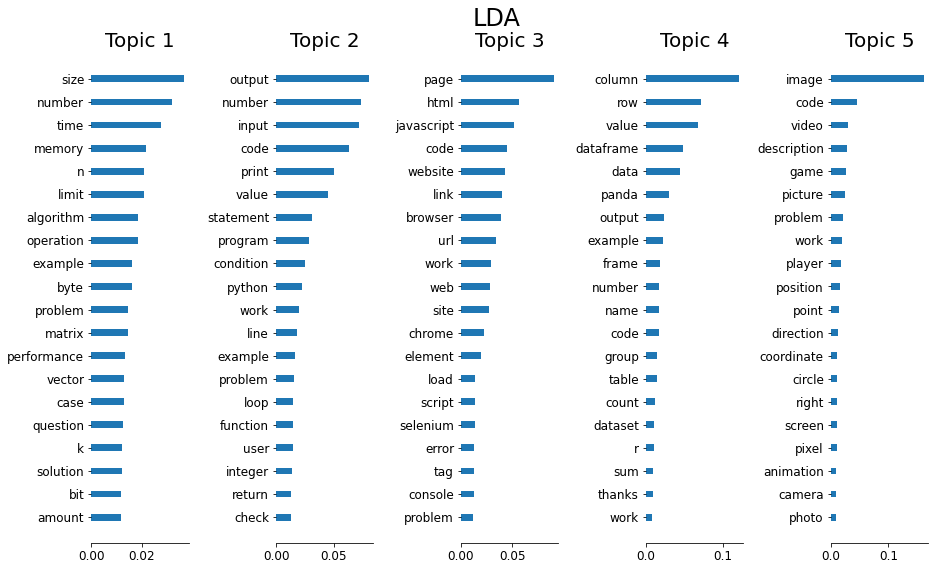

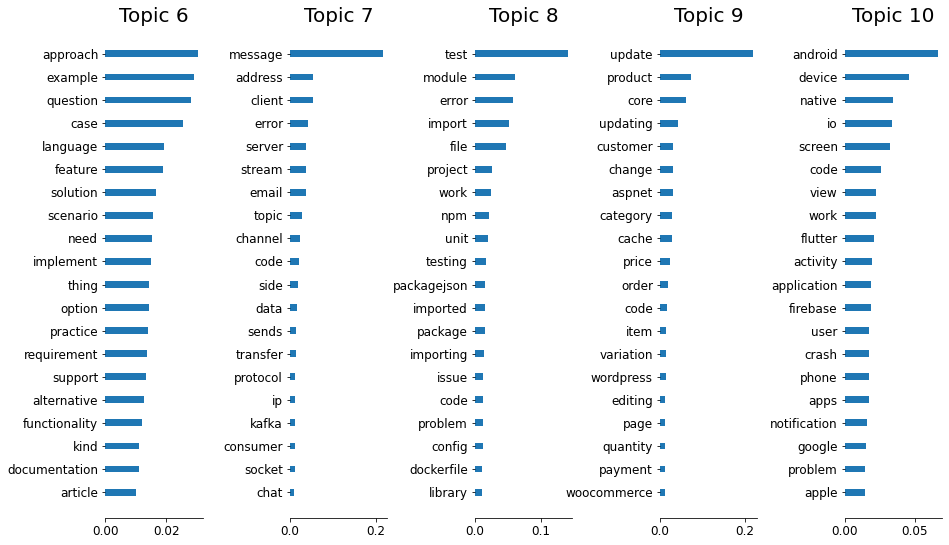

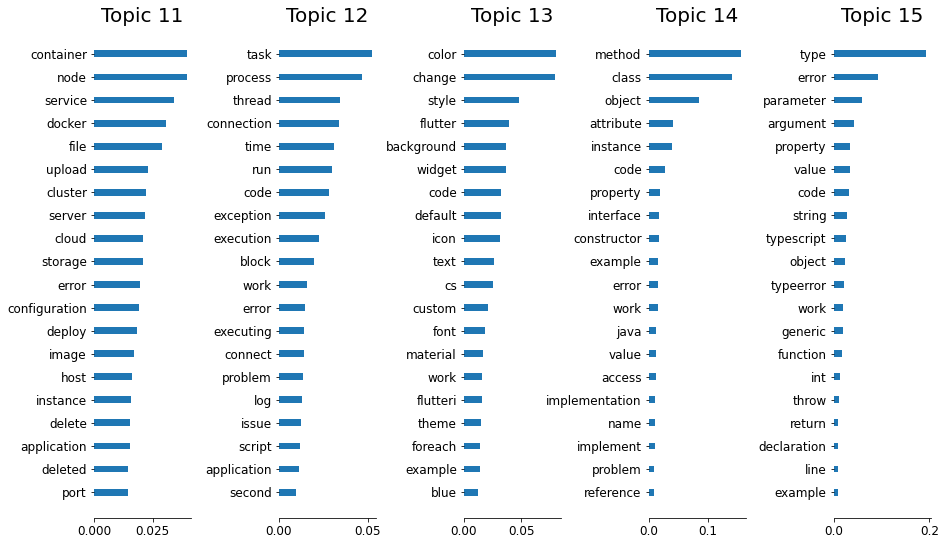

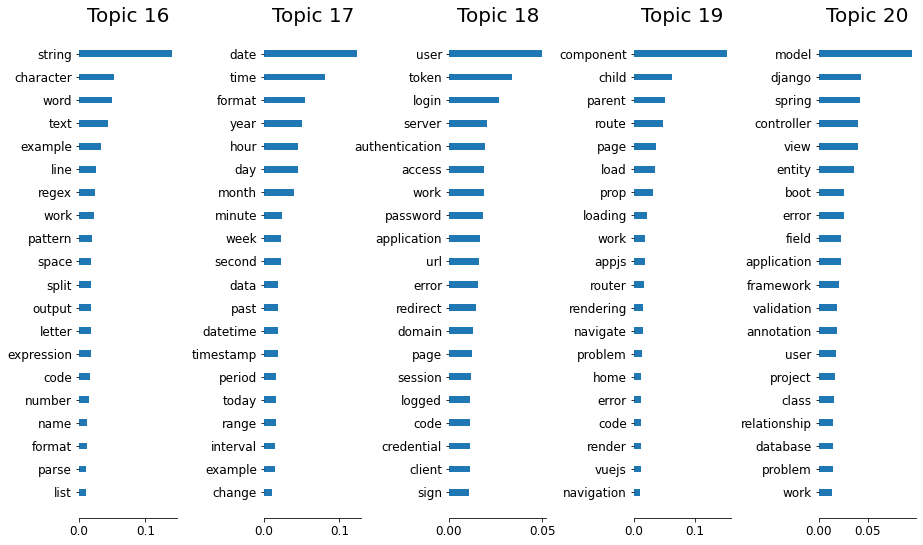

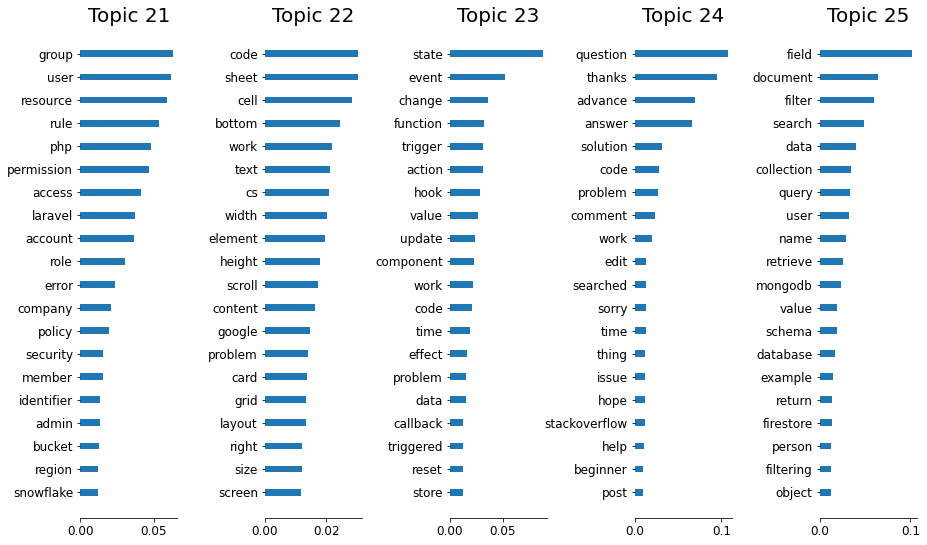

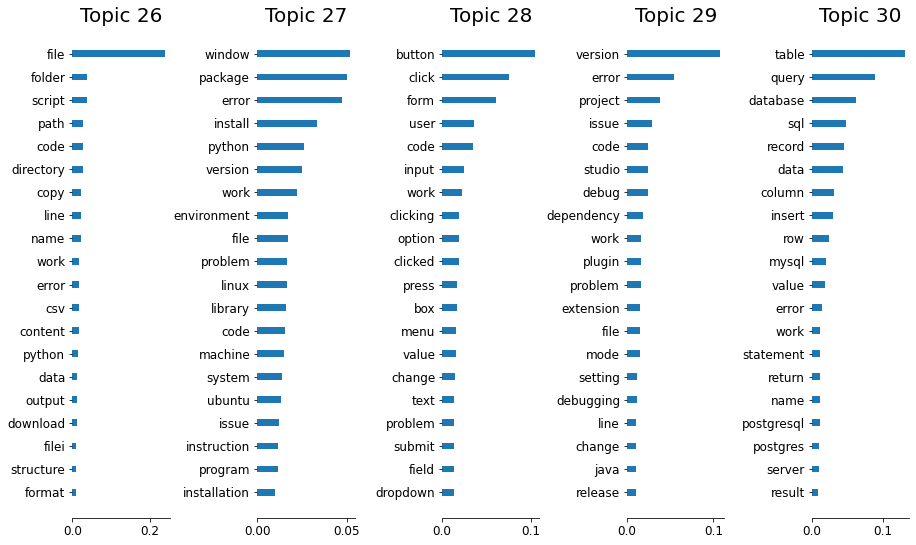

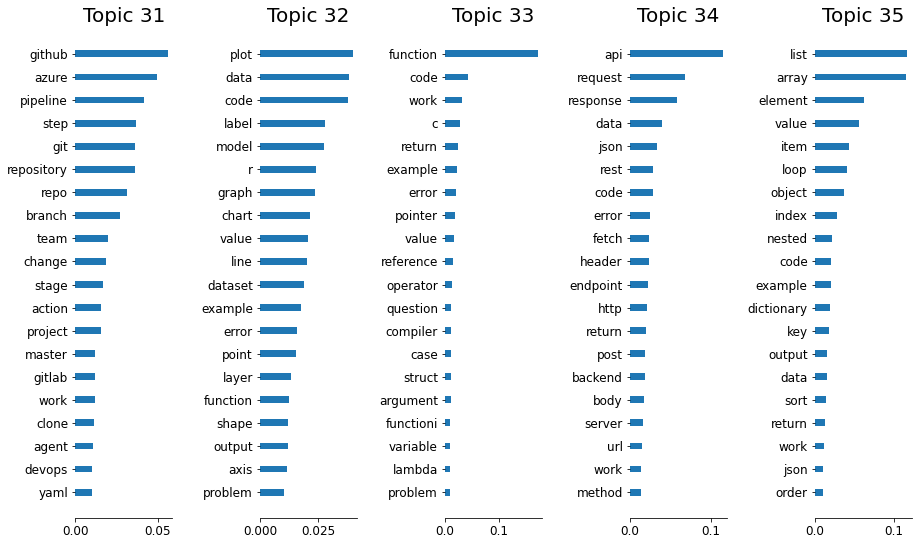

In [80]:
plot_top_words(LDA_optimal_final, list(id2word.itervalues()), 20, "LDA")

**Interprétation des thèmes discernés par le modèle LDA**

   1. Algorithmique
   2. Questions sur la structure du code
   3. Usage d'internet et des navigateurs
   4. Manipulation de données tabulaires/dataframes
   5. Intégration Web de contenu multimédia
   6. Paradigme de programmation
   7. Gestion de réseaux de données
   8. Test de projets informatiques
   9. Mises à jour, changements d'état
   10. Développement d'applciation Android
   11. Gestion de données dans le cloud
   12. Optimisation de calculs
   13. Front End
   14. Programmation Orientée Objet
   15. Gestion des types de données
   16. Manipulation de données textuelles
   17. Manipulation de données temporelles
   18. Gestion de l'authentification
   19. Développement d'interfaces usagers Web
   20. Développement d'applicatifs Web
   21. Back End Web
   22. Front End Web
   23. Gestions d'évènement et programamtion asynchrone
   24. Débuggage du code
   25. Recherche d'information textuelle dans les documents
   26. Manipulation de fichiers et dossiers
   27. Installations de programmes
   28. Front End Web
   29. Gestions de librairies et versionnage
   30. Bases de données relationnelles
   31. Hébergement et gestion de développment de projets
   32. Visualisation de données
   33. Conception des fonctions
   34. Utilisation d'API
   35. Itérateurs
   
**Les thèmes se retrouvent aisément en lisant les 20 mots les plus représentatifs**.

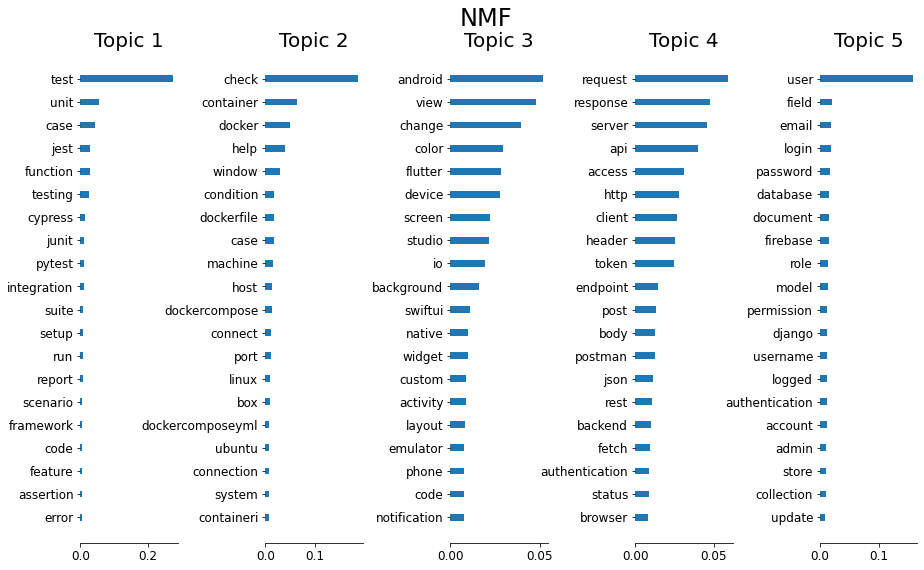

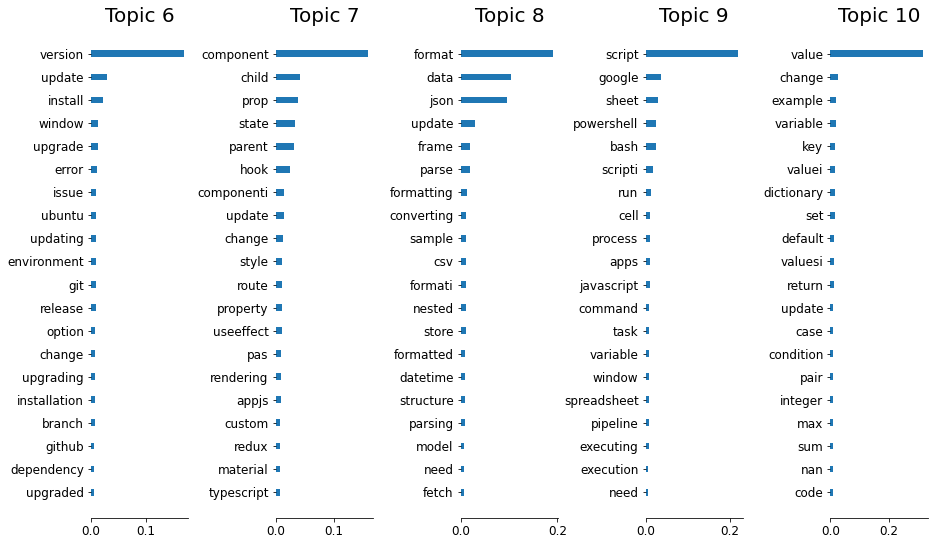

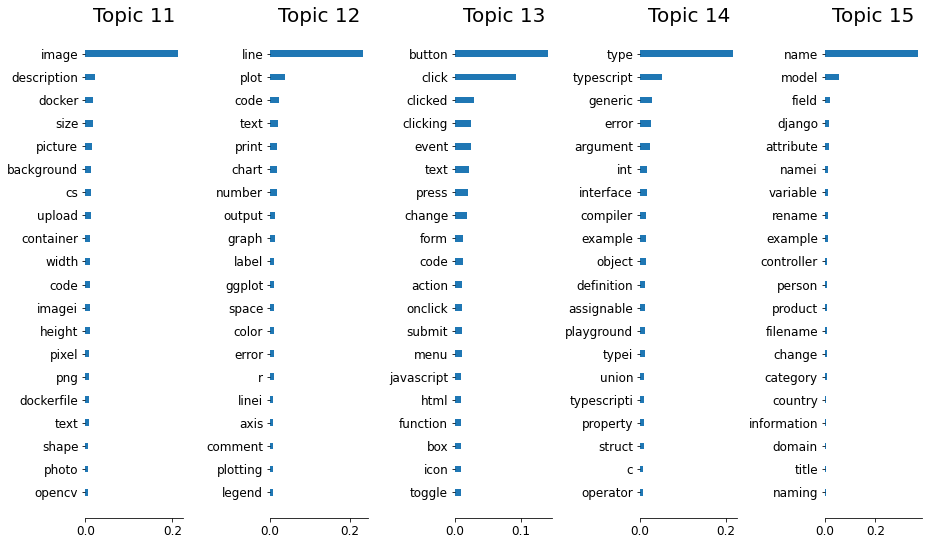

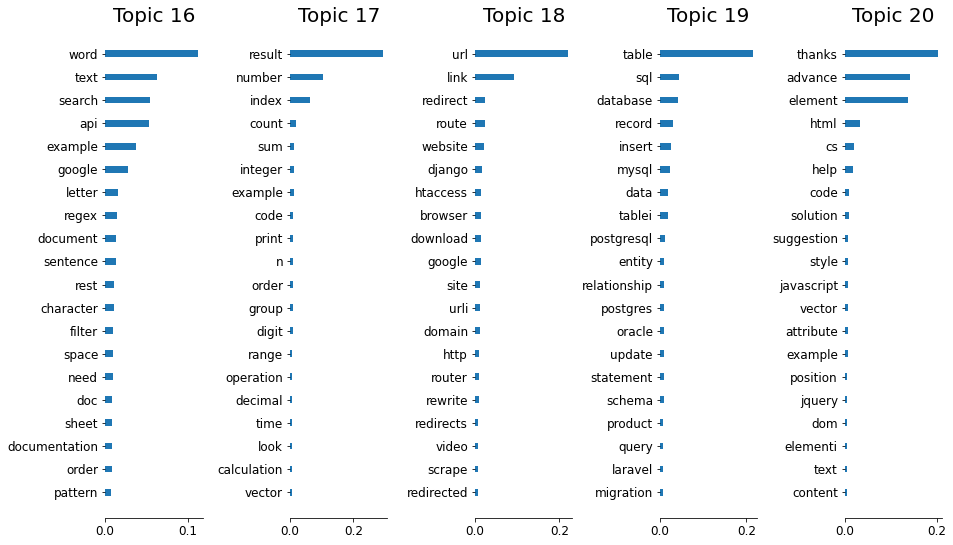

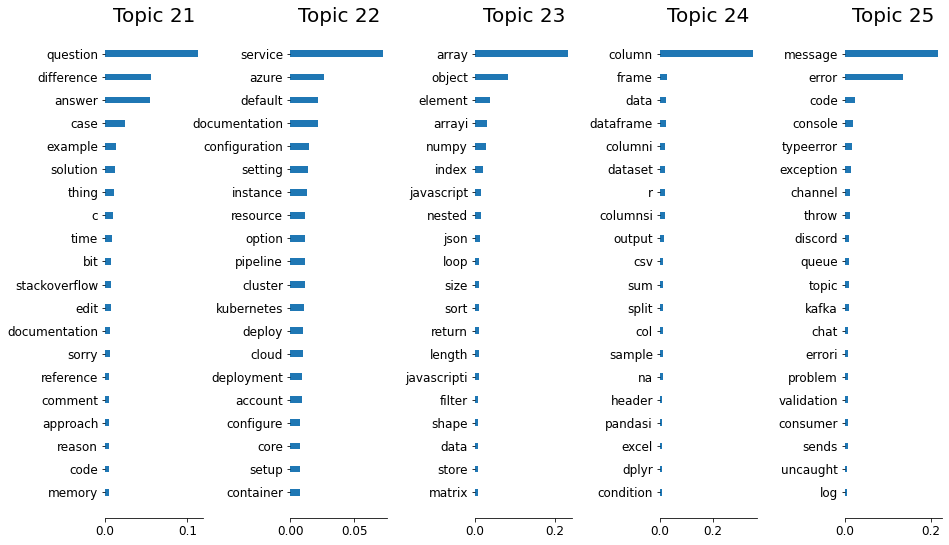

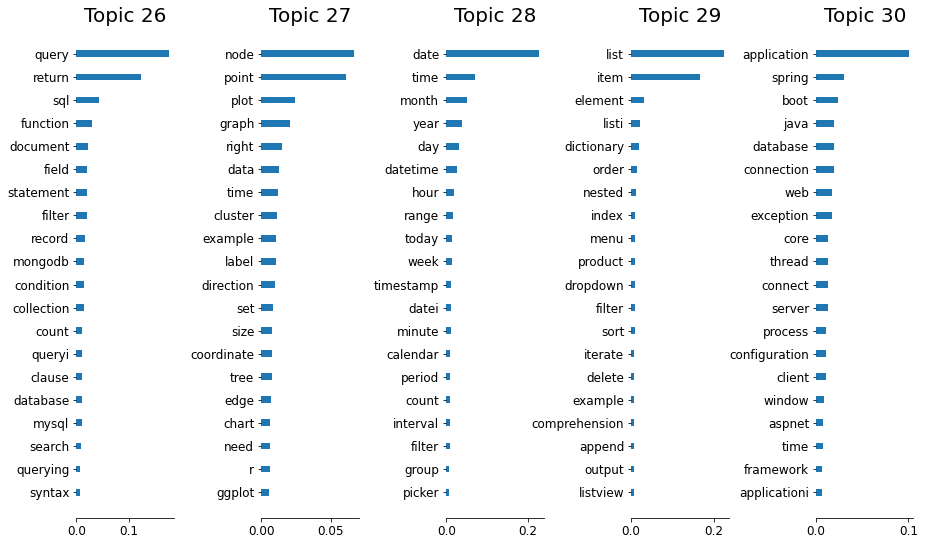

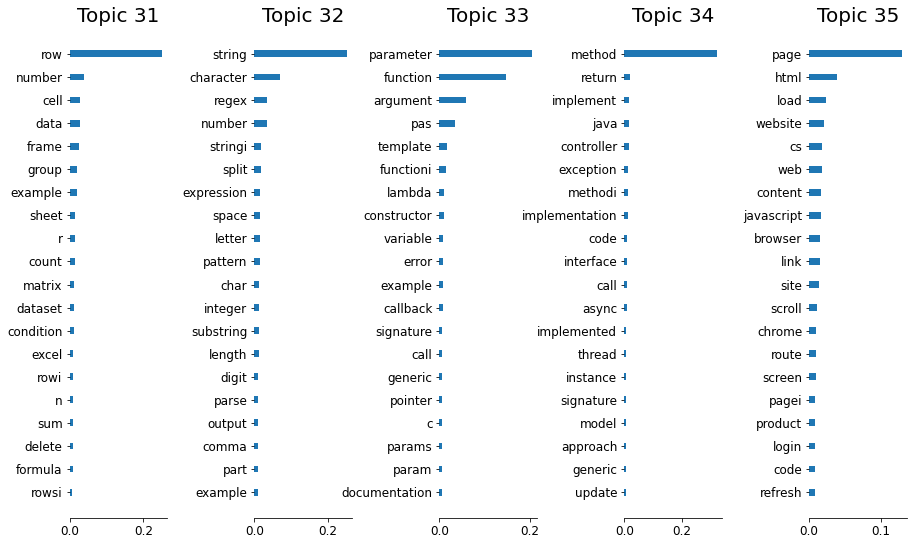

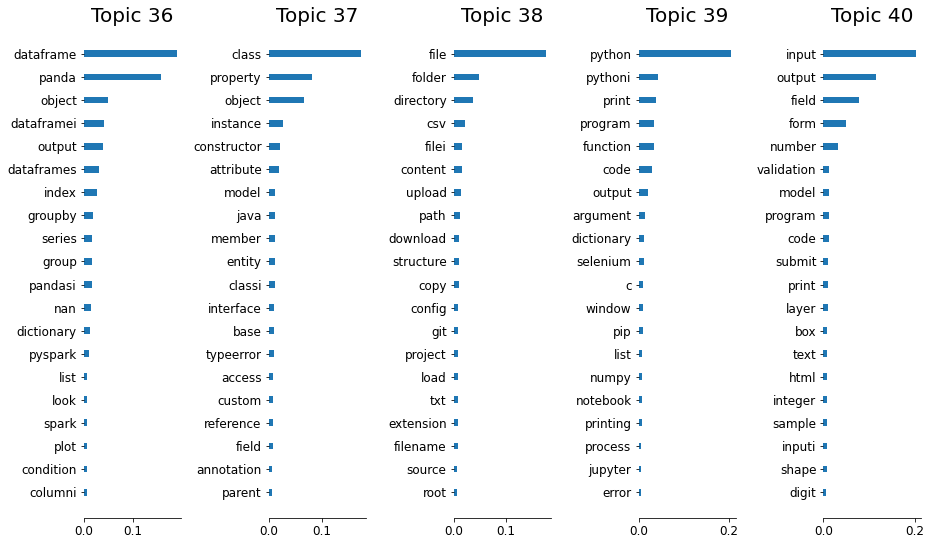

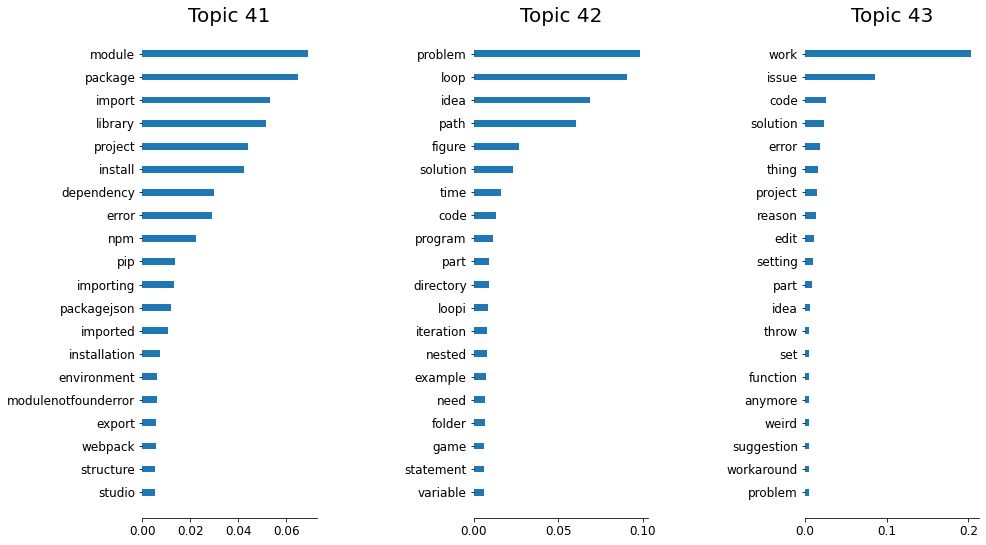

In [81]:
plot_top_words(NMF_optimal_final, list(id2word.itervalues()), 20, "NMF")

**Interprétation des thèmes discernés par le modèle NMF**

   1. Tests de projets informatiques
   2. Gestions de données dans le cloud
   3. Développemeent d'application Android
   4. Gestion de réseaux de données
   5. Gestion de l'auhtentification
   6. Versionnage
   7. Développement d'interfaces usagers Web
   8. Formattage des données ~
   9. Tableurs dans le cloud
   10. Interprétation des données ~
   11. Intégration d'image ~
   12. Visualisation de données
   13. Éléments Web interactable
   14. Gestion de types de données
   15. Développement d'applicatifs Web ~
   16. Recherche d'information textuelle dans les documents ~
   17. Manipulation de données tabulaires (ou liste) ~
   18. Usage d'internet et des navigateurs ~
   19. Bases de données relationnelles
   20. Questions sur le développement HTML/CSS ~
   21. *Questions ~~* (divers ??)
   22. Services cloud
   23. Manipulations de données tabulaires
   24. Navigation dans des données tabulaires
   25. Gestions des erreurs ou exceptions
   26. Recherche d'informations dans un corpus de documents ~
   27. Visualisation de partitionnement ~
   28. Manipulation de données temporelles
   29. Manipulation de listes
   30. Développement d'applicatifs Web
   31. Navigation dans des données tabulaires
   32. Manipulation de chaînes de caractères
   33. Conception des fonctions
   34. Utilisation des méthodes (POO)
   35. Navigation sur internet
   36. Manipulation de dataframes
   37. Programmation Orientée Objet
   39. Programmation avec Python
   40. Gestion de l'I/O
   41. Gestions de librairies et versionnage
   42. Questions sur la structure du code
   43. Débuggage du code ~
   
**Un grand nombre de thèmes sont difficiles à interpréter (12, dont 1 très difficile à interpréter, soit près de 30% des thèmes discernés par le modèle)**.

### <u>Examen actif des documents associés à chaque thème</u>

Maintenant que nous avons interpréter chaque thème, examinons les documents les plus représentatifs de chaque thème pour vérifier la pertinence des partiotionnement réalisés par nos modèles

In [110]:
def format_topics_sentences(ldamodel, corpus):
    # Init output
    df_topics = pd.DataFrame(data={'Dominant_Topic_num':[], 'Perc_Contribution':[], 'Topic_Keywords':[]})

    # Get main topic in each document
    for i in trange(len(ldamodel[corpus])):
        row = ldamodel[corpus][i]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for (word, prop) in wp])
                df_topics = pd.concat([df_topics, 
                                            pd.DataFrame(data = {'Dominant_Topic_num':[int(topic_num)+1],
                                                                 'Perc_Contribution':[round(prop_topic,4)],
                                                                 'Topic_Keywords':[topic_keywords]
                                                                })
                                           ], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    df_topics.set_index(df_supervised.index, inplace=True)
    return df_topics

In [111]:
df_topics = format_topics_sentences(ldamodel=LDA_optimal_final, corpus=bow_corpus_unsupervised)

  0%|          | 0/998596 [00:00<?, ?it/s]

In [117]:
df_topics.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            999990, 999991, 999992, 999993, 999994, 999995, 999996, 999997,
            999998, 999999],
           dtype='int64', length=998596)

Nous pouvons désormais concaténer le résultat de notre fonction prédécente avec le le contenu des paragraphes des posts originaux ainsi que les tags nettoyés :

In [113]:
original_cleaned_keywords = df_lemmas['tags'][df_unsupervised.index]

In [114]:
original_post = df_datas.apply(lambda x: x['title'] + x['body'], axis=1)[df_unsupervised.index]

In [158]:
df_topics_tags =  df_topics.merge(pd.DataFrame(original_post), right_index=True, left_index=True)
df_topics_tags =  df_topics_tags.merge(pd.DataFrame(original_cleaned_keywords), right_index=True, left_index=True)
df_topics_tags.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Tags']

In [159]:
df_topics_tags

Dominant_Topic  Topic_Perc_Contrib  \
0                 17.0              0.3797   
1                  5.0              0.1826   
2                 33.0              0.5433   
3                 28.0              0.5977   
4                 10.0              0.3341   
...                ...                 ...   
999995            26.0              0.3004   
999996            33.0              0.3196   
999997            26.0              0.1937   
999998             1.0              0.4514   
999999            16.0              0.5311   

                                                 Keywords  \
0       date, time, format, year, hour, day, month, mi...   
1       image, code, video, description, game, picture...   
2       function, code, work, c, return, example, erro...   
3       button, click, form, user, code, input, work, ...   
4       android, device, native, io, screen, code, vie...   
...                                                   ...   
999995  file, folder, script, path, code, directory, c...   
999996  function, code, work, c, return, example, erro...   
999997  file, folder, script, path, code, directory, c...   
999998  size, number, time, memory, n, limit, algorith...   
999999  string, character, word, text, example, line, ...   

                                                     Text  \
0       modifying bonita process instance after starte...   
1       what does elevation in drawshadow do exactlyi ...   
2       how to use a trait object that contains a meth...   
3       a way for users to store selections as inputs ...   
4       how to open downloaded photo using gallery app...   
...                                                   ...   
999995  can you do a pull in a mongodb bulk write whic...   
999996  non static method cannot be called staticallyi...   
999997  sorting oslistdirs arbitrary order for desired...   
999998  big o complexity of nested loopwhat could be t...   
999999  how to convert comma separated string to list ...   

                                  Tags  
0                             [bonita]  
1           [c++, dart, flutter, skia]  
2                               [rust]  
3                [r, shiny, shinyapps]  
4       [expo, gallery, linker, react]  
...                                ...  
999995                       [mongodb]  
999996                  [laravel, php]  
999997         [list, python, sorting]  
999998                           [big]  
999999                        [python]  

[998596 rows x 5 columns]

In [161]:
df_topics_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998596 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dominant_Topic      998596 non-null  float64
 1   Topic_Perc_Contrib  998596 non-null  float32
 2   Keywords            998596 non-null  object 
 3   Text                998596 non-null  object 
 4   Tags                998596 non-null  object 
dtypes: float32(1), float64(1), object(3)
memory usage: 74.2+ MB


In [162]:
df_topics_tags['Dominant_Topic'] = df_topics_tags['Dominant_Topic'].astype(np.int8)
df_topics_tags['Topic_Perc_Contrib'] = df_topics_tags['Topic_Perc_Contrib'].astype(np.float16)

In [163]:
df_topics_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998596 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dominant_Topic      998596 non-null  int8   
 1   Topic_Perc_Contrib  998596 non-null  float16
 2   Keywords            998596 non-null  object 
 3   Text                998596 non-null  object 
 4   Tags                998596 non-null  object 
dtypes: float16(1), int8(1), object(3)
memory usage: 65.6+ MB


In [185]:
dict_topics_num_title = {
                           1: "Algorithmique",
                           2: "Questions sur la structure du code",
                           3: "Usage d'internet et des navigateurs",
                           4: "Manipulation de données tabulaires/dataframes",
                           5: "Intégration Web de contenu multimédia",
                           6: "Paradigme de programmation",
                           7: "Gestion de réseaux de données",
                           8: "Test de projets informatiques",
                           9: "Mises à jour, changements d'état",
                           10: "Développement d'applciation Android",
                           11: "Gestion de données dans le cloud",
                           12: "Optimisation de calculs",
                           13: "Front End",
                           14: "Programmation Orientée Objet",
                           15: "Gestion des types de données",
                           16: "Manipulation de données textuelles",
                           17: "Manipulation de données temporelles",
                           18: "Gestion de l'authentification",
                           19: "Développement d'interfaces usagers Web",
                           20: "Développement d'applicatifs Web",
                           21: "Back End Web",
                           22: "Front End Web",
                           23: "Gestions d'évènement et programamtion asynchrone",
                           24: "Débuggage du code",
                           25: "Recherche d'information textuelle dans les documents",
                           26: "Manipulation de fichiers et dossiers",
                           27: "Installations de programmes",
                           28: "Front End Web",
                           29: "Gestions de librairies et versionnage",
                           30: "Bases de données relationnelles",
                           31: "Hébergement et gestion de développment de projets",
                           32: "Visualisation de données",
                           33: "Conception des fonctions",
                           34: "Utilisation d'API",
                           35: "Itérateurs"
}

In [186]:
df_topics_tags['Topic_title'] = df_topics_tags['Dominant_Topic'].replace(dict_topics_num_title)

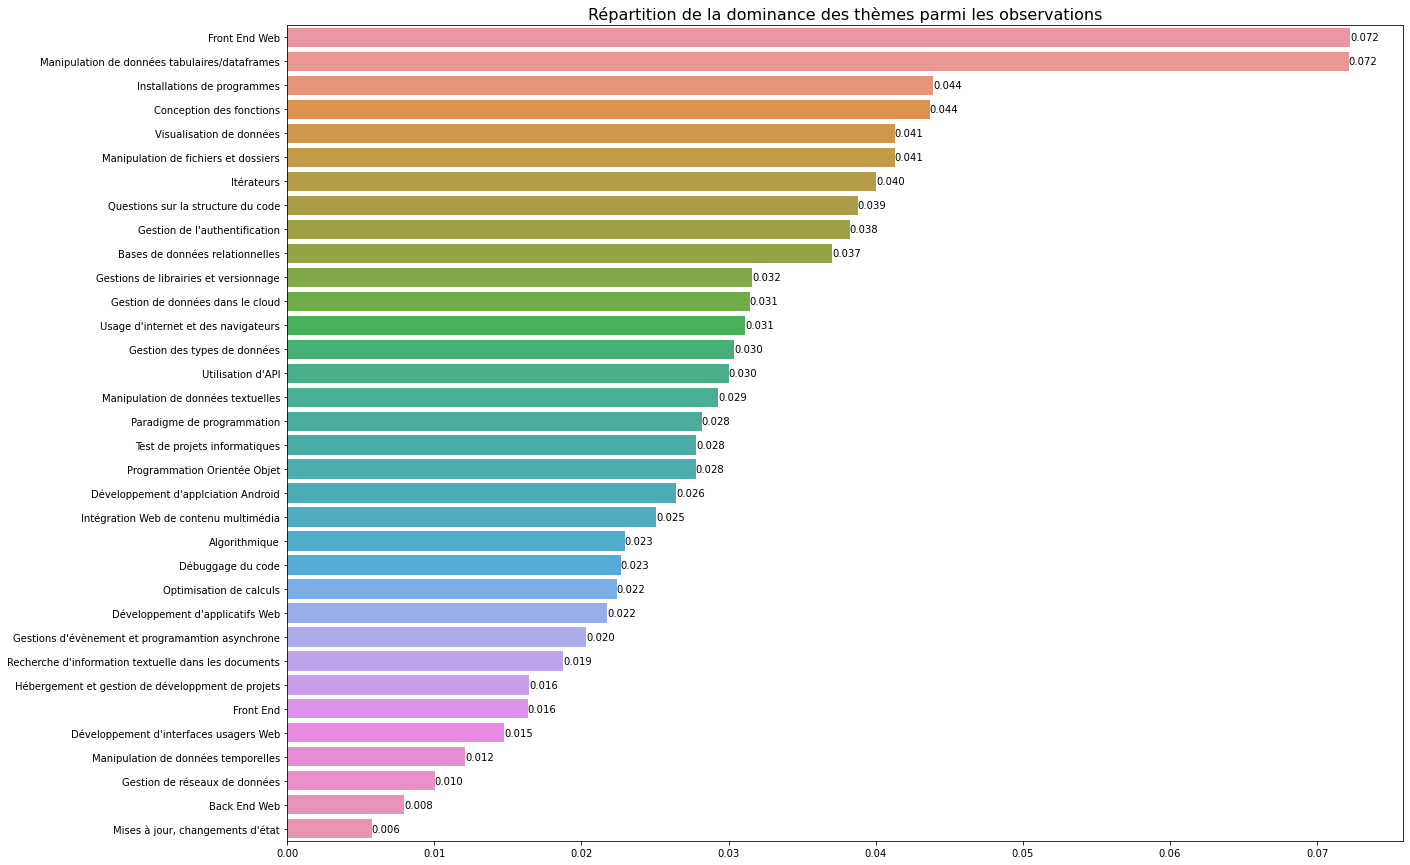

In [225]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=df_topics_tags['Topic_title'].value_counts(normalize=True).values, y=df_topics_tags['Topic_title'].value_counts(normalize=True).index)
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title("Répartition de la dominance des thèmes parmi les observations", fontsize=16);

> Les thèmes **Front End Web** et **Manipulation de données tabulaires/DataFrames** sont les plus récurrents, sont proches dans leur dominance sur l'ensemble des observations et se démarquent du reste des thèmes.

In [187]:
topic_most_representatives_docs = df_topics_tags.groupby(by="Dominant_Topic").agg({'Topic_Perc_Contrib':'max'})
topic_most_representatives_docs

Topic_Perc_Contrib
Dominant_Topic                    
1                         0.939453
2                         0.942871
3                         0.939453
4                         0.959473
5                         0.942871
6                         0.902832
7                         0.935059
8                         0.953613
9                         0.935059
10                        0.939453
11                        0.945801
12                        0.930664
13                        0.925293
14                        0.951172
15                        0.945801
16                        0.942871
17                        0.925293
18                        0.969727
19                        0.959473
20                        0.935059
21                        0.911621
22                        0.955566
23                        0.939453
24                        0.918945
25                        0.942871
26                        0.935059
27                        0.960938
28                        0.951172
29                        0.948730
30                        0.948730
31                        0.942871
32                        0.951172
33                        0.948730
34                        0.951172
35                        0.935059

In [188]:
topic_most_representatives_docs = topic_most_representatives_docs.merge(df_topics_tags[['Topic_title','Topic_Perc_Contrib','Keywords', 'Text', 'Tags']], left_on='Topic_Perc_Contrib', right_on='Topic_Perc_Contrib')
topic_most_representatives_docs

Topic_Perc_Contrib                                        Topic_title  \
0               0.939453  Hébergement et gestion de développment de projets   
1               0.939453      Manipulation de données tabulaires/dataframes   
2               0.939453                        Installations de programmes   
3               0.939453                      Gestion de l'authentification   
4               0.939453      Manipulation de données tabulaires/dataframes   
...                  ...                                                ...   
8533            0.948730      Manipulation de données tabulaires/dataframes   
8534            0.948730      Manipulation de données tabulaires/dataframes   
8535            0.948730      Manipulation de données tabulaires/dataframes   
8536            0.948730      Manipulation de données tabulaires/dataframes   
8537            0.948730      Manipulation de données tabulaires/dataframes   

                                               Keywords  \
0     github, azure, pipeline, step, git, repository...   
1     column, row, value, dataframe, data, panda, ou...   
2     window, package, error, install, python, versi...   
3     user, token, login, server, authentication, ac...   
4     column, row, value, dataframe, data, panda, ou...   
...                                                 ...   
8533  column, row, value, dataframe, data, panda, ou...   
8534  column, row, value, dataframe, data, panda, ou...   
8535  column, row, value, dataframe, data, panda, ou...   
8536  column, row, value, dataframe, data, panda, ou...   
8537  column, row, value, dataframe, data, panda, ou...   

                                                   Text  \
0     gitlab default issue template for all new proj...   
1     pandas isin based on common column for  differ...   
2     centos on virtual box yum install errori am tr...   
3     auth silent auth not working on mobile works f...   
4     select columns in a dataframe conditional on r...   
...                                                 ...   
8533  isolating and joining adjacent columnscells ba...   
8534  groupby two columns and create a new column ba...   
8535  check if values in all n previous rows are gre...   
8536  filling nan based on reverse moving averageto ...   
8537  apply function to one random row per group in ...   

                                                   Tags  
0                        [automation, gitlab, pipeline]  
1                                      [pandas, python]  
2                                  [centos, virtualbox]  
3     [auth, authentication, javascript, oauth, reac...  
4                           [dataframe, pandas, python]  
...                                                 ...  
8533                      [isolate, loops, multiple, r]  
8534       [apply, lambda, pandas, python, subtraction]  
8535                        [dataframe, pandas, python]  
8536               [dataframe, pandas, python, rolling]  
8537                             [dataframe, r, sample]  

[8538 rows x 5 columns]

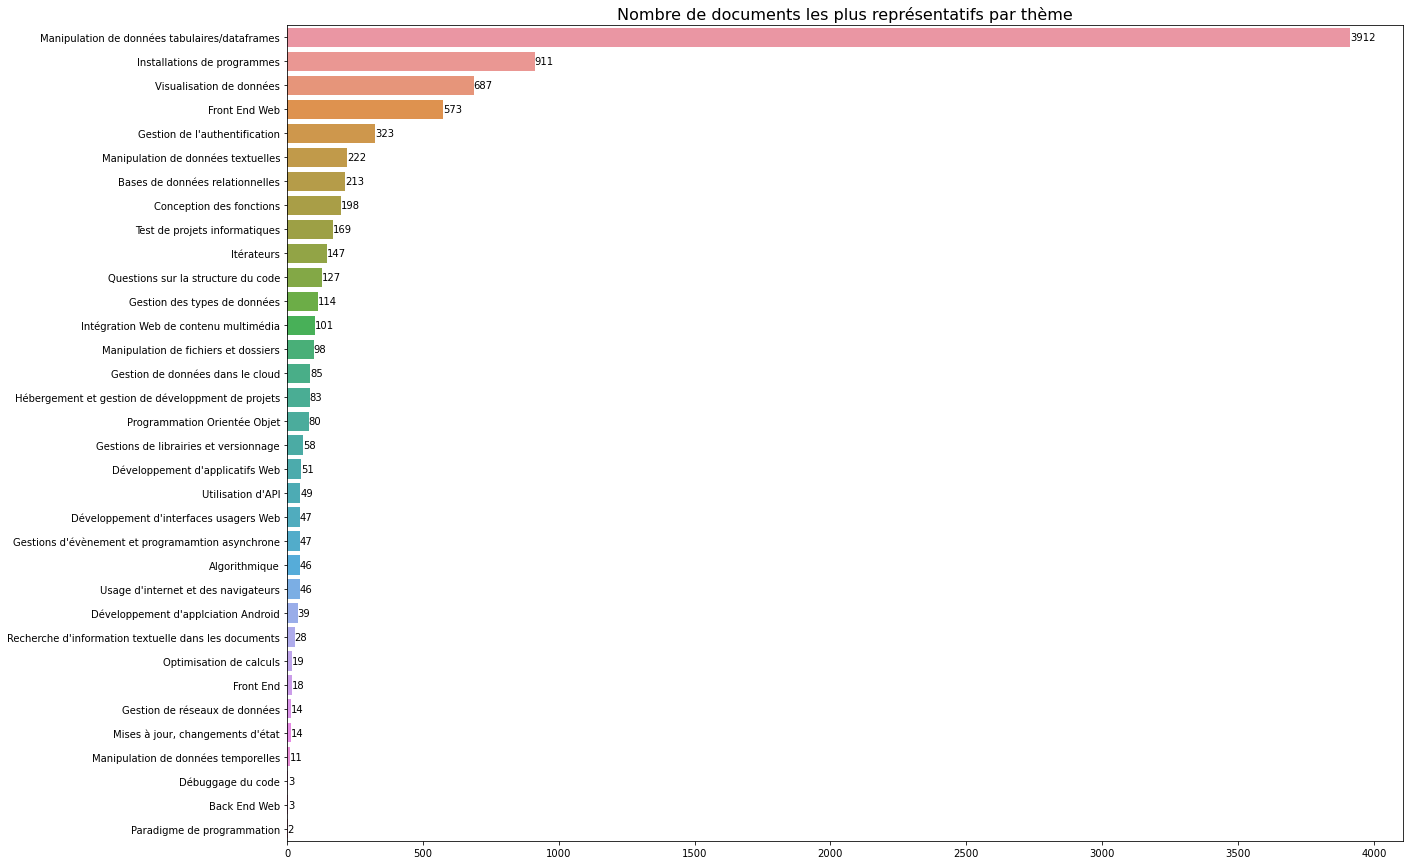

In [192]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=topic_most_representatives_docs['Topic_title'].value_counts().values, 
            y=topic_most_representatives_docs['Topic_title'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title("Nombre de documents les plus représentatifs par thème", fontsize=16);

> Il y a une nette différence entre le thème **Manipulation de données tabulaires/dataframes** et le reste des thèmes.

Étant donné qu'il s'agit du thème dominant dans le plus grand nombre d'observations, nous allons observer les distributions de la variable **Topi_Perc_Contrib** pour vérifier si ce sont les documents attribué au thème **Manipulation de données tabulaires/dataframes** qui sont particulièrement identifiables (distribution skewed vers les hautes valeurs) ou bien si le résultat précédent est le fait d'un plus grand nombre de documents attribués à ce thèmes.

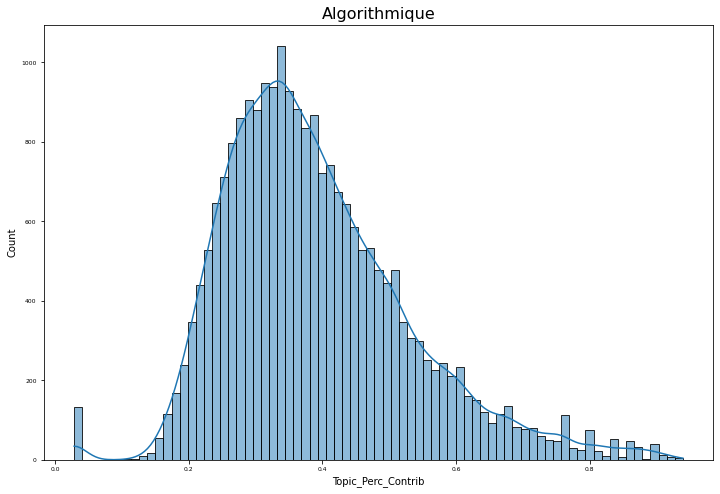

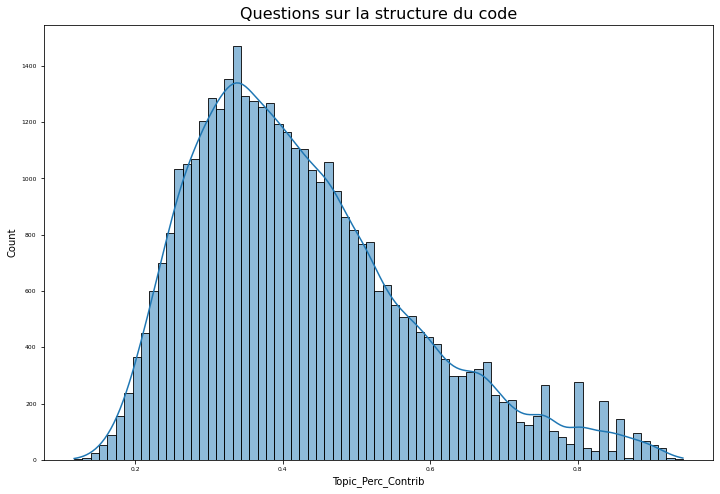

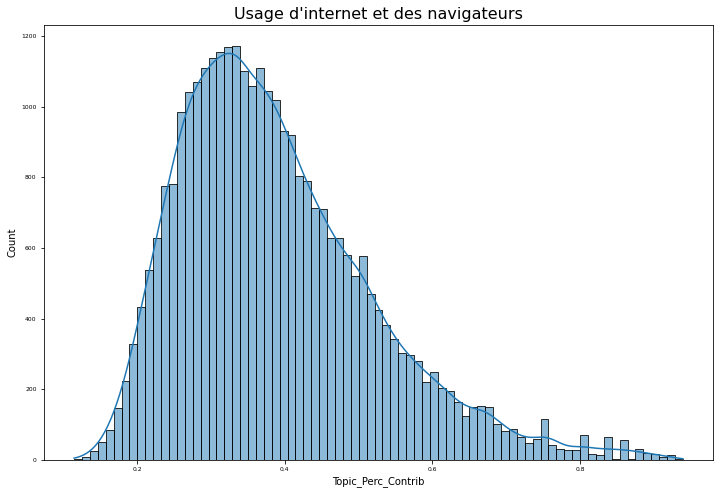

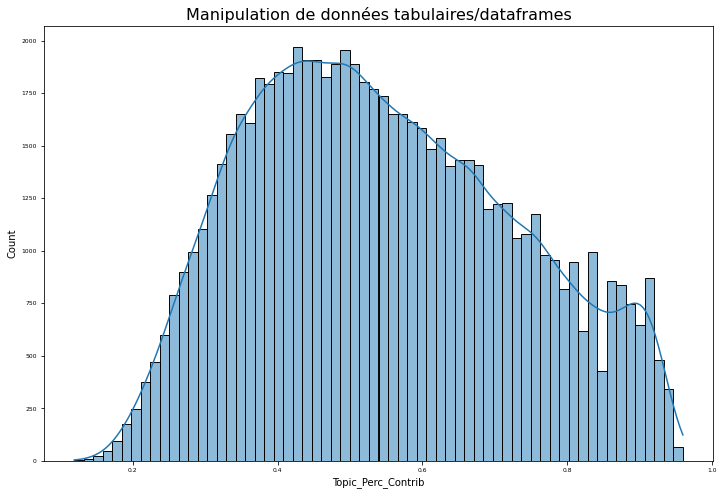

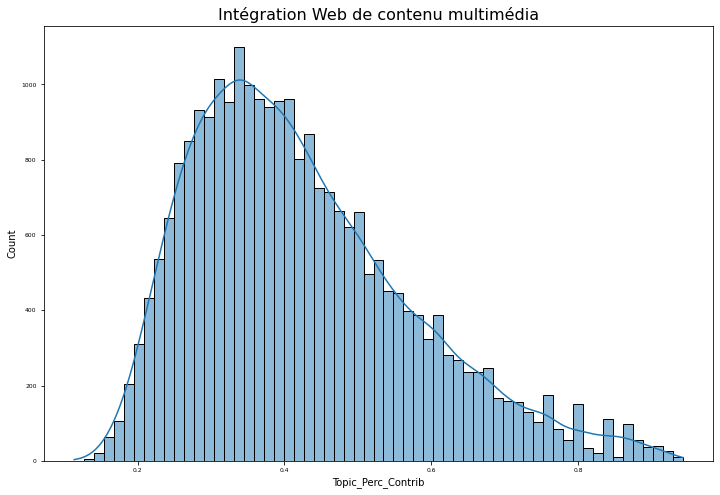

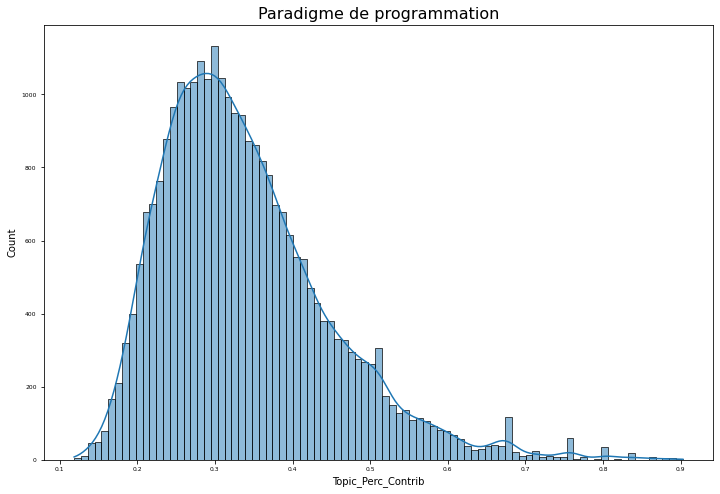

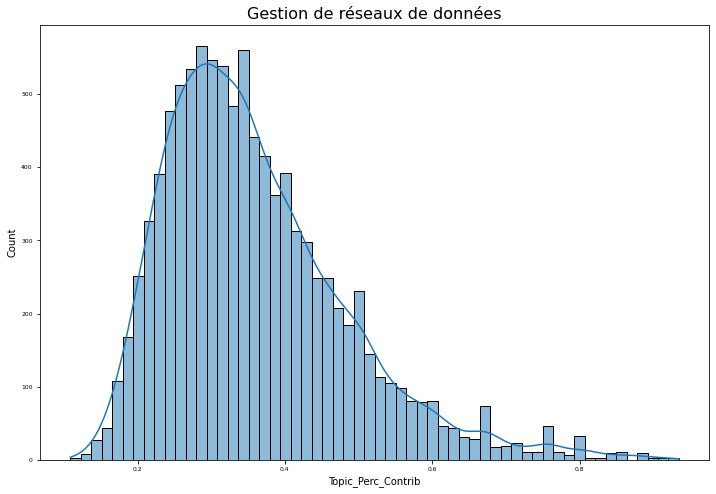

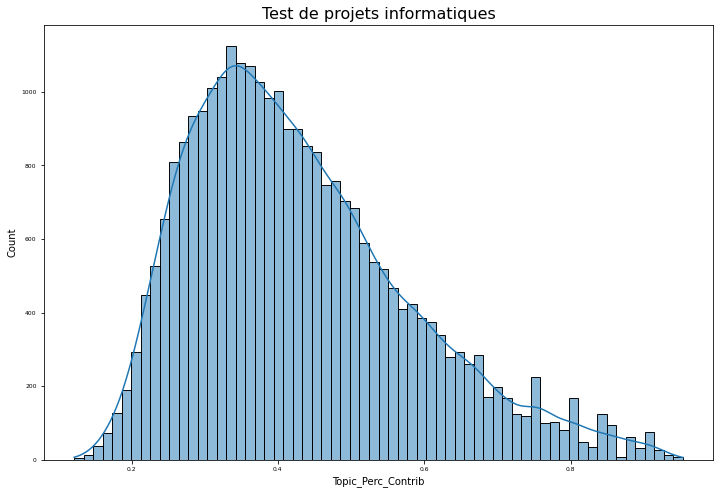

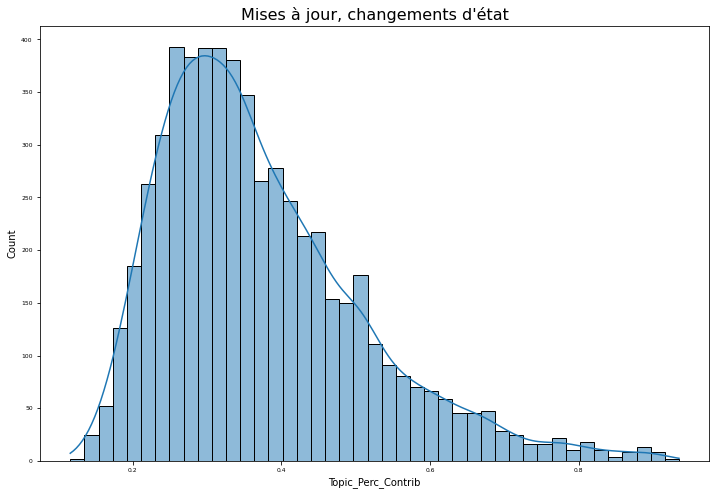

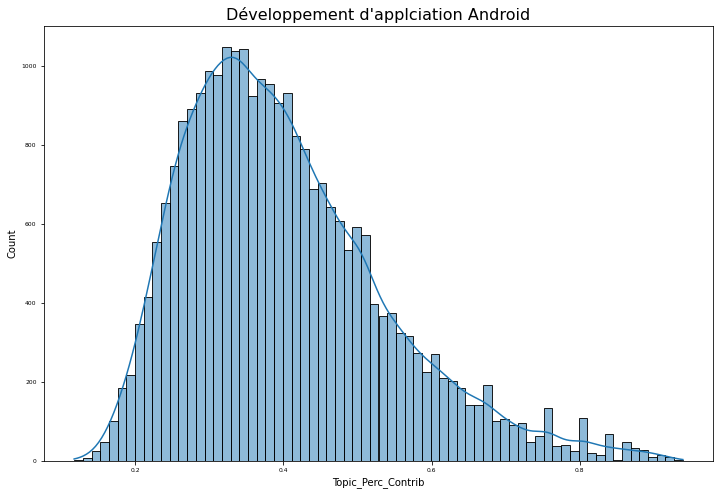

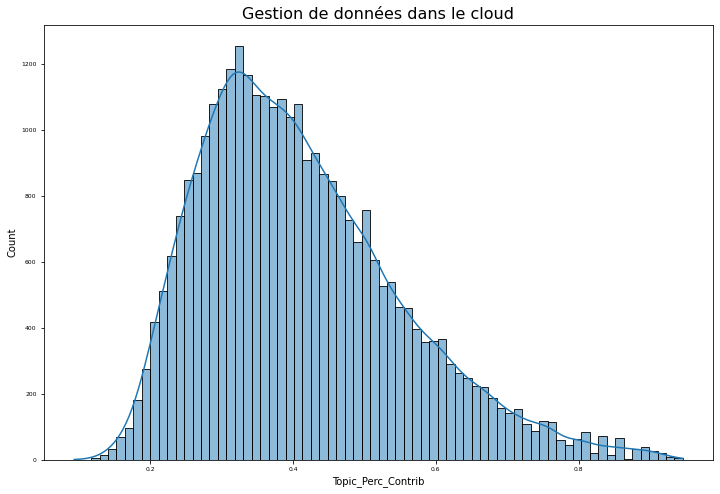

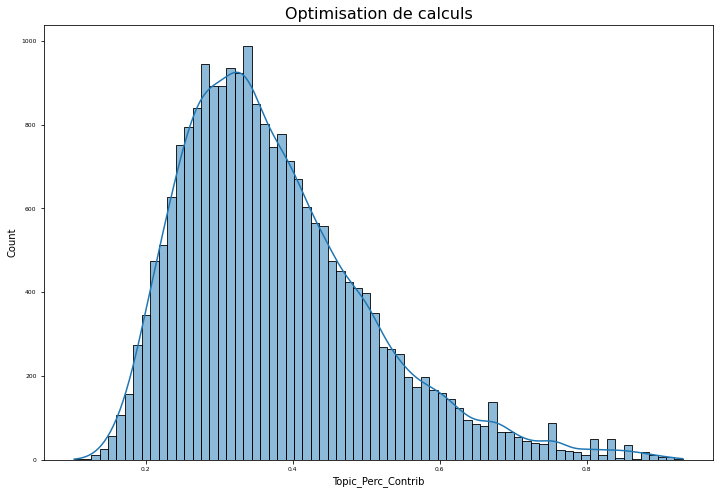

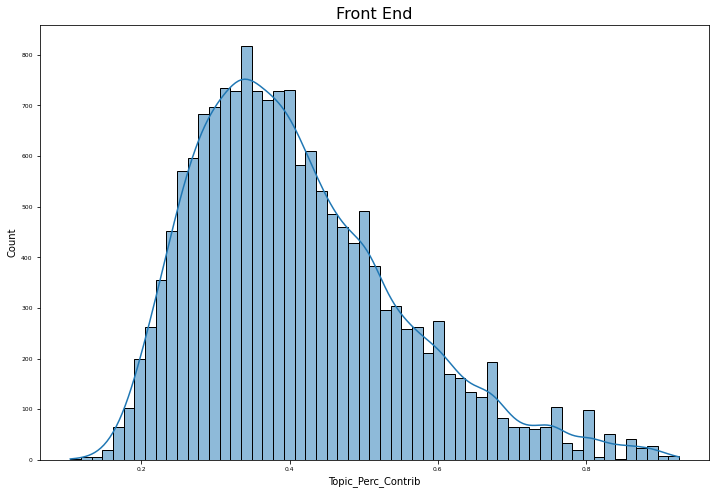

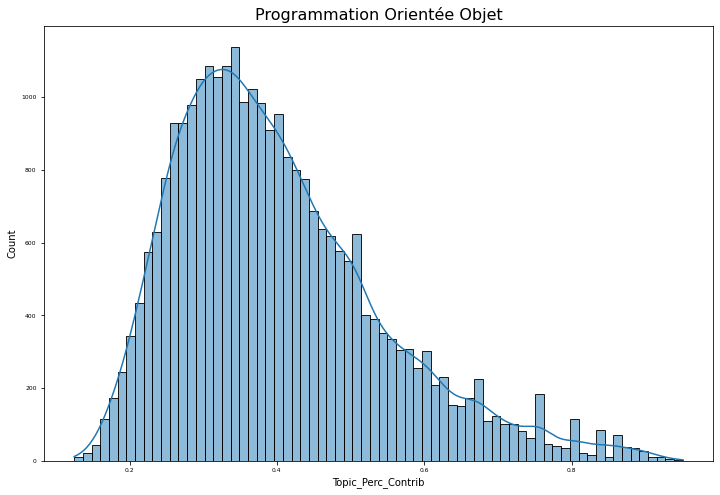

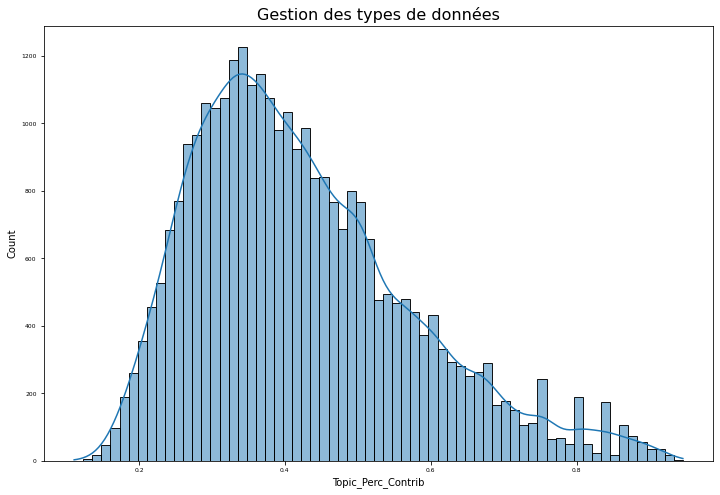

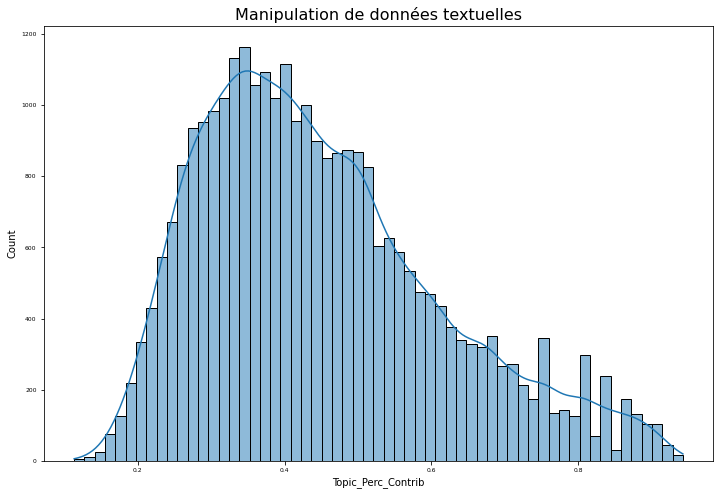

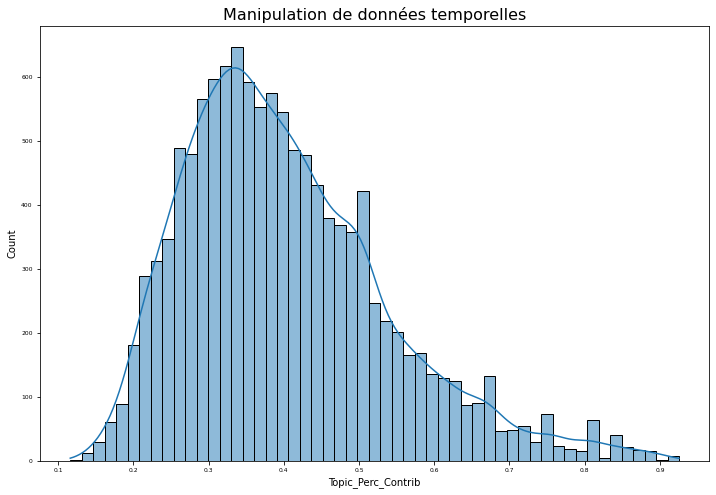

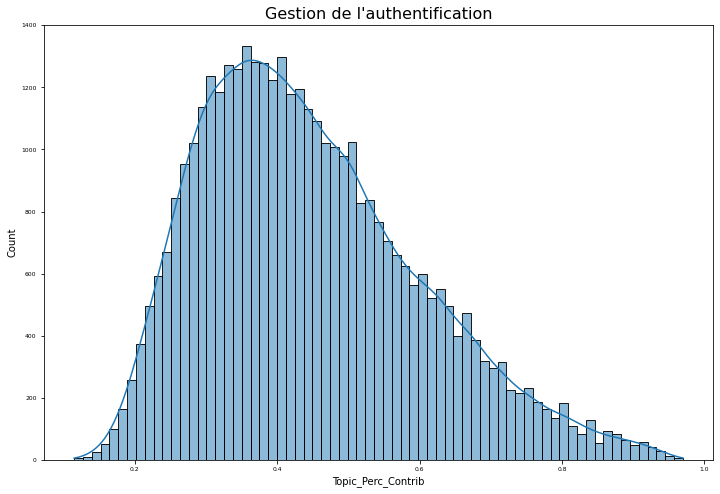

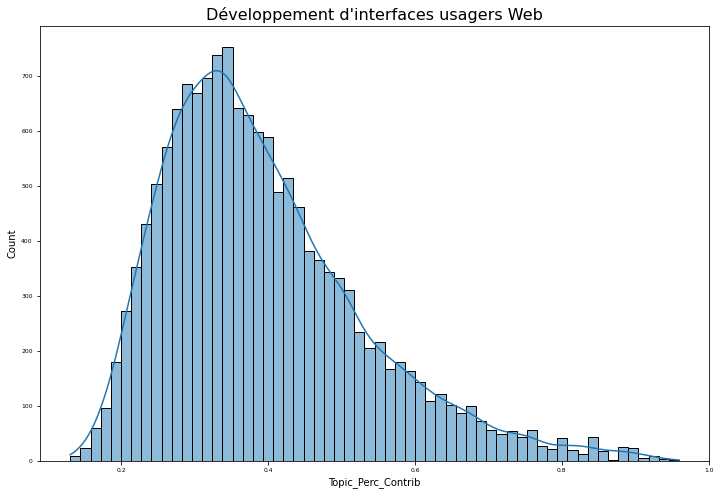

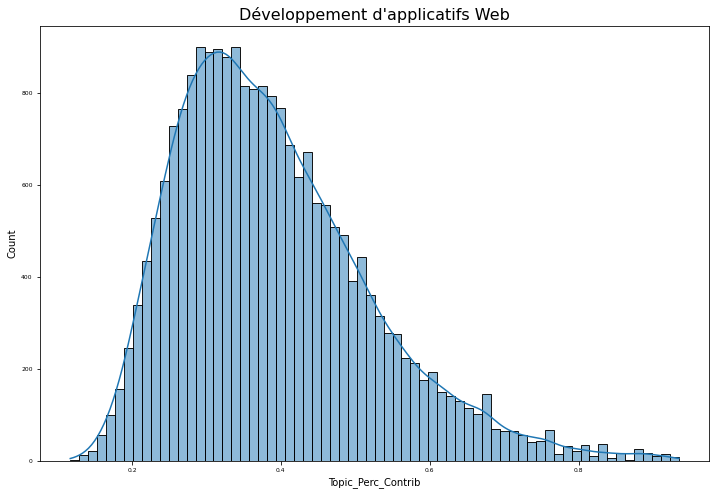

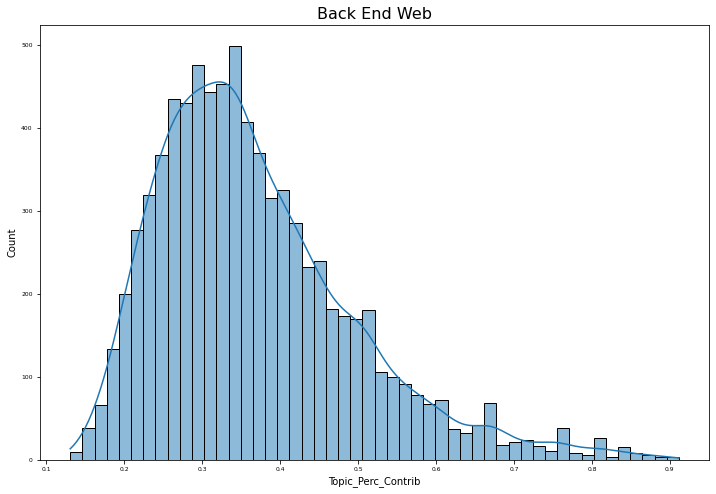

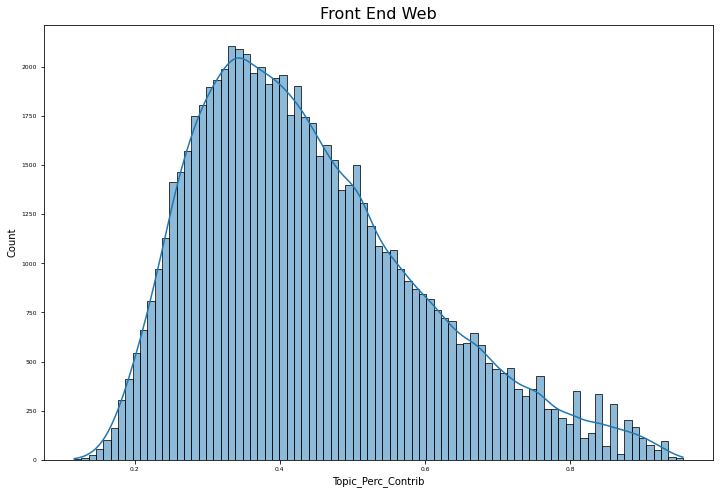

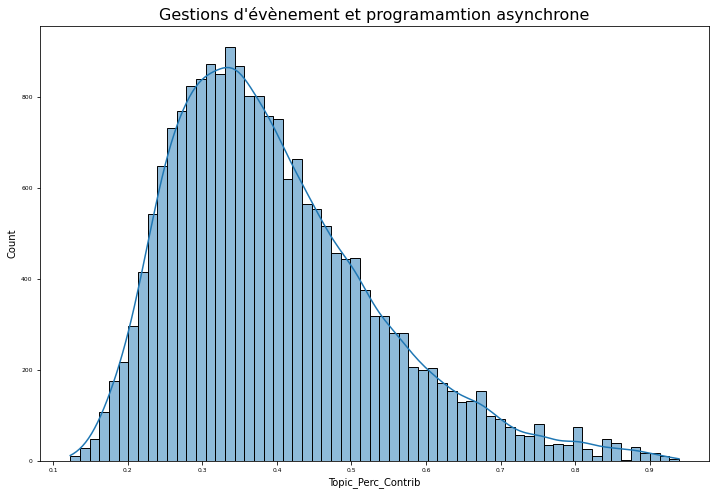

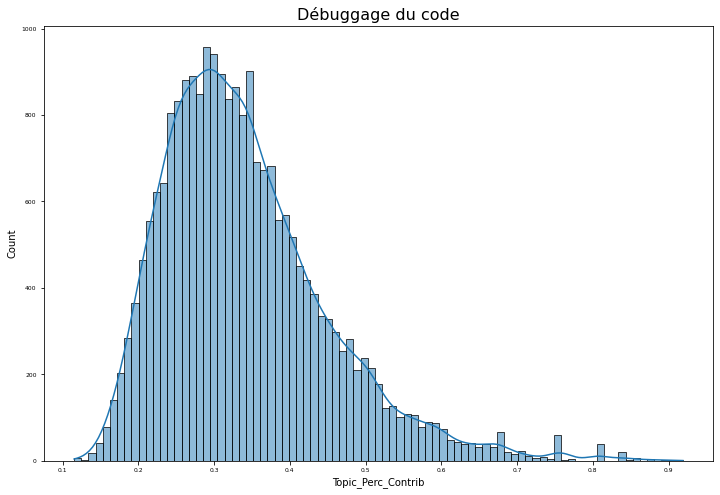

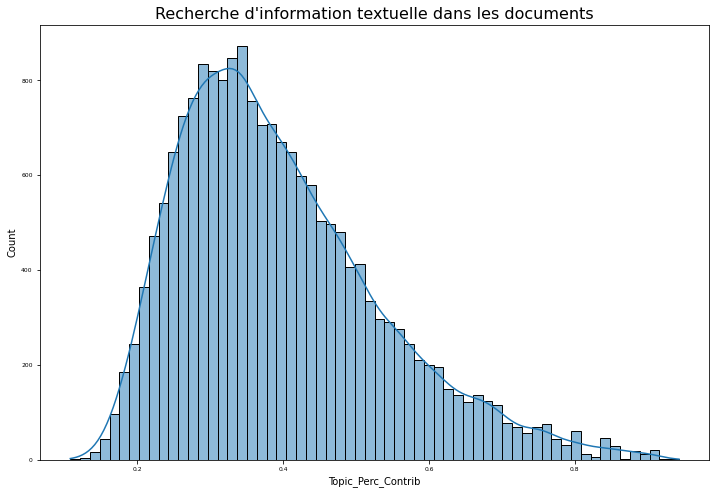

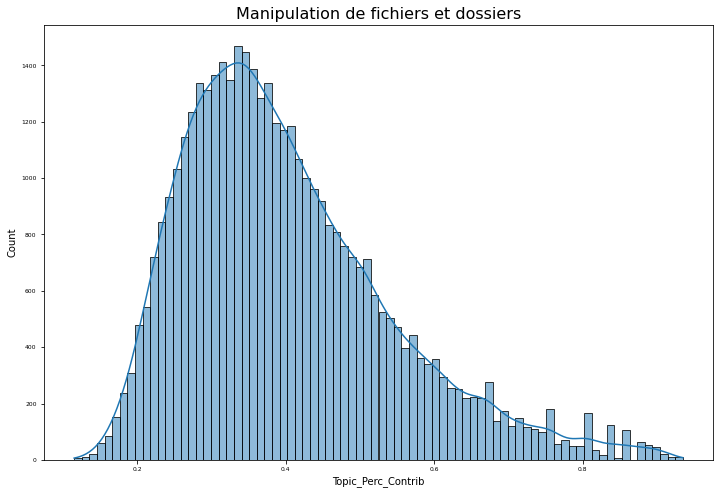

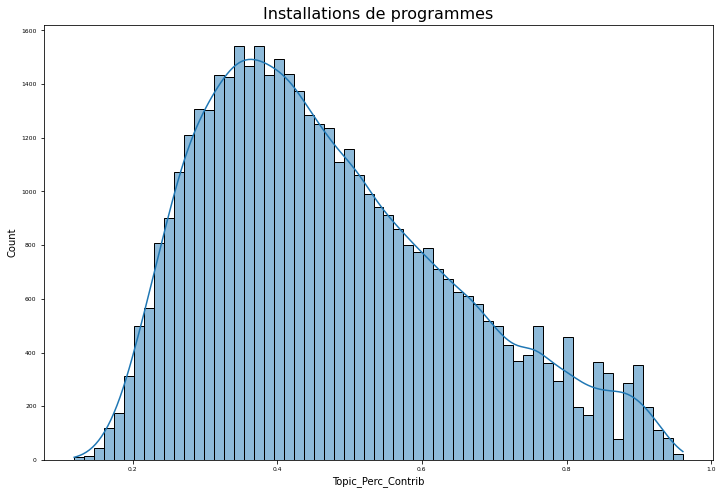

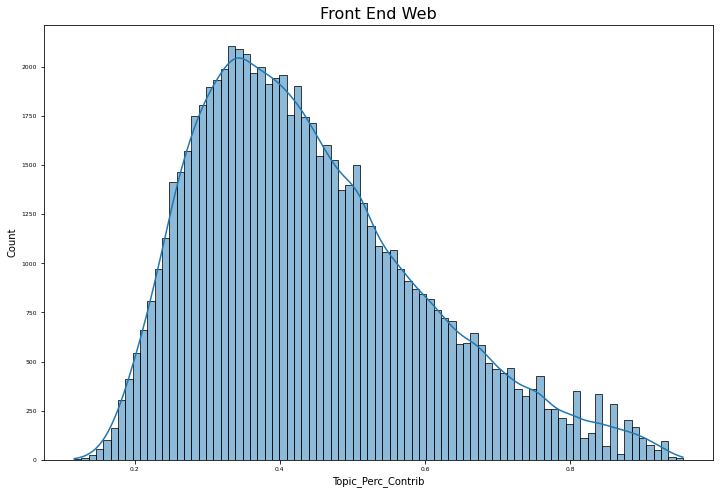

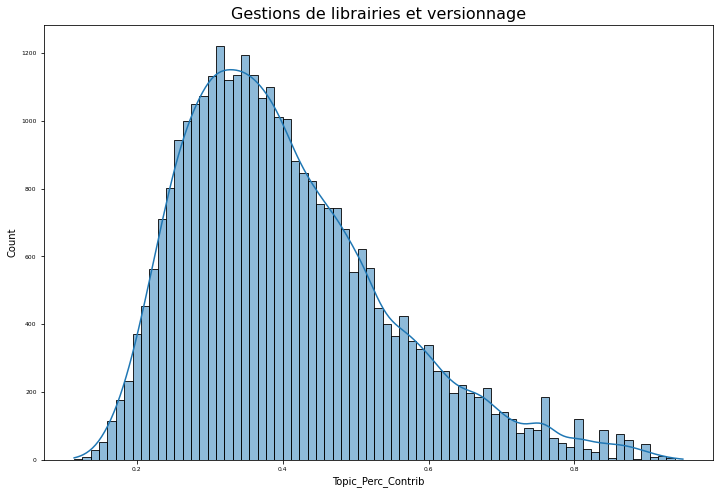

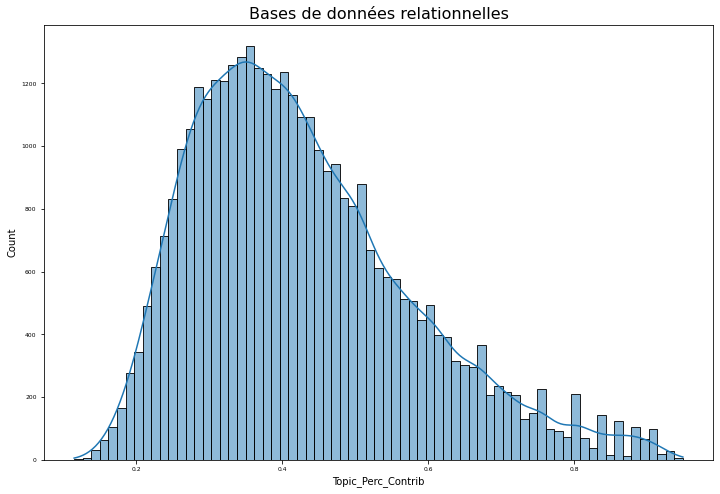

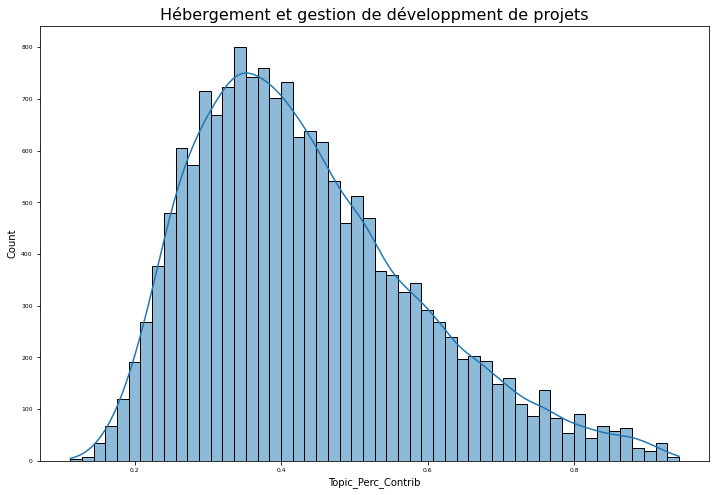

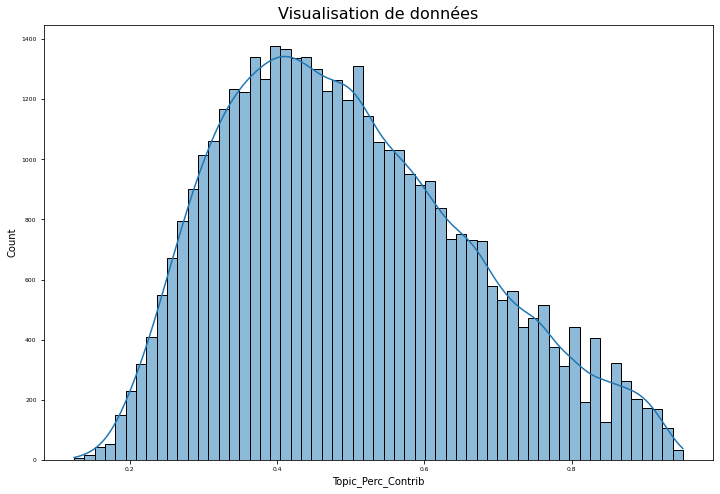

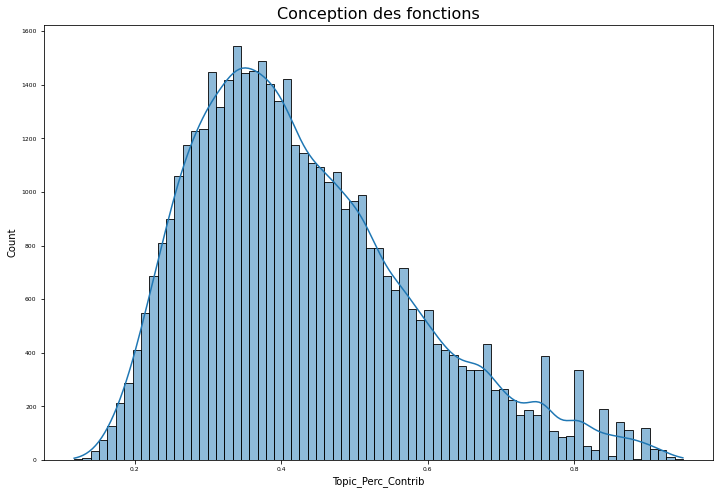

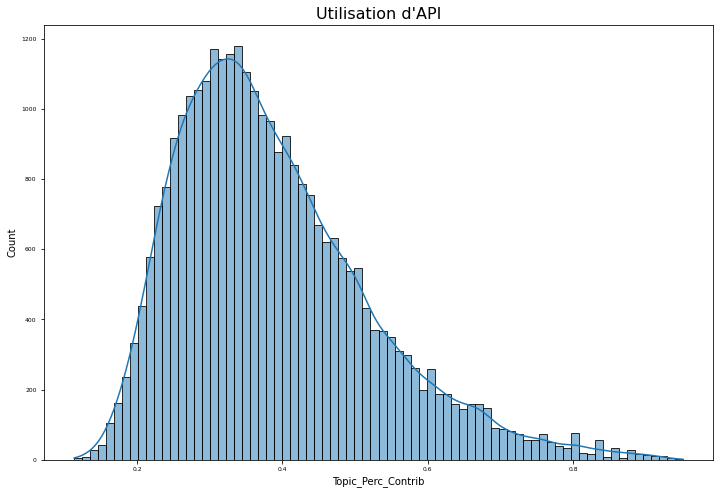

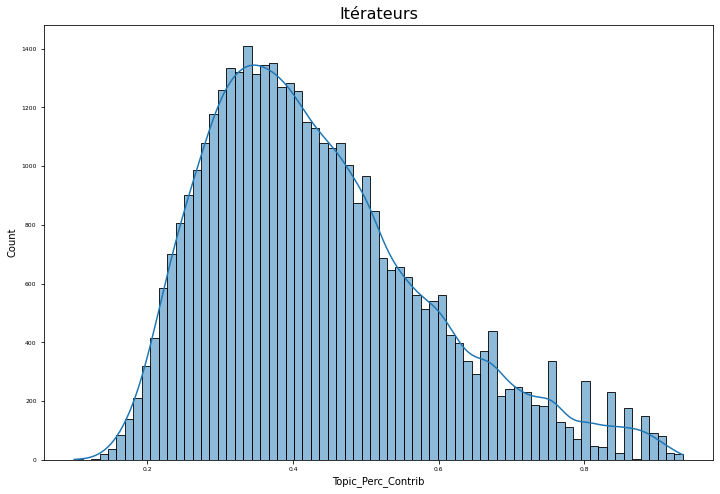

In [204]:
for num, topic in dict_topics_num_title.items():
    
    plt.figure(figsize=(12,8))
    ax = sns.histplot(data=df_topics_tags[df_topics_tags['Topic_title']==topic]['Topic_Perc_Contrib'], kde=True)
    ax.set_title(topic, fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=6)
    plt.show()

> Toutes les distributions sont déviantes vers la gauche (petites valeurs), mais celle du thème **Manipulation de données tabulaires/dataframes** est nettement plus représenté pour les hautes valeurs que les autres.

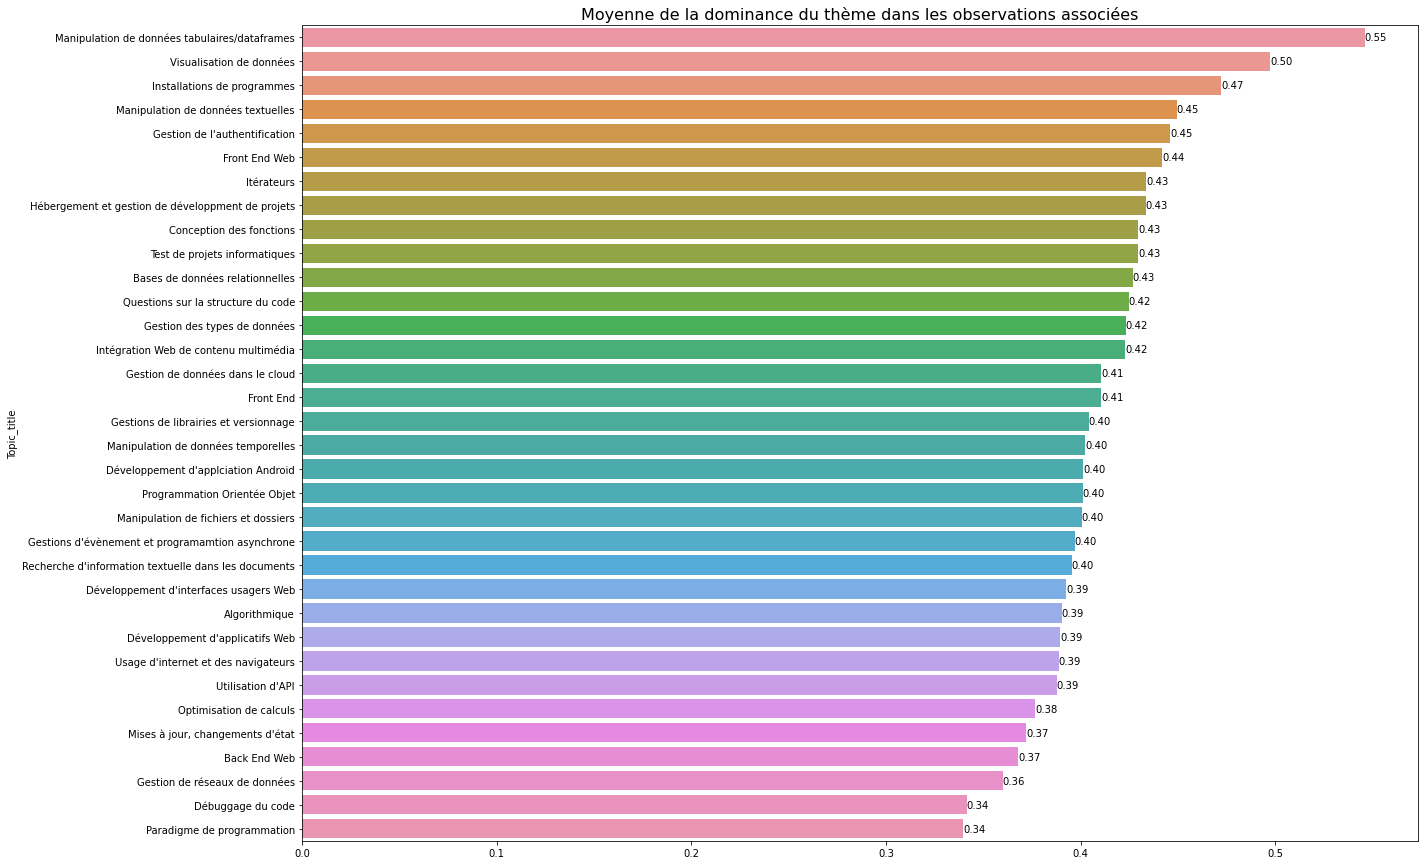

In [214]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=df_topics_tags.groupby(by='Topic_title')['Topic_Perc_Contrib'].mean().sort_values(ascending=False).values,
            y=df_topics_tags.groupby(by='Topic_title')['Topic_Perc_Contrib'].mean().sort_values(ascending=False).index)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title("Moyenne de la dominance du thème dans les observations associées", fontsize=16);

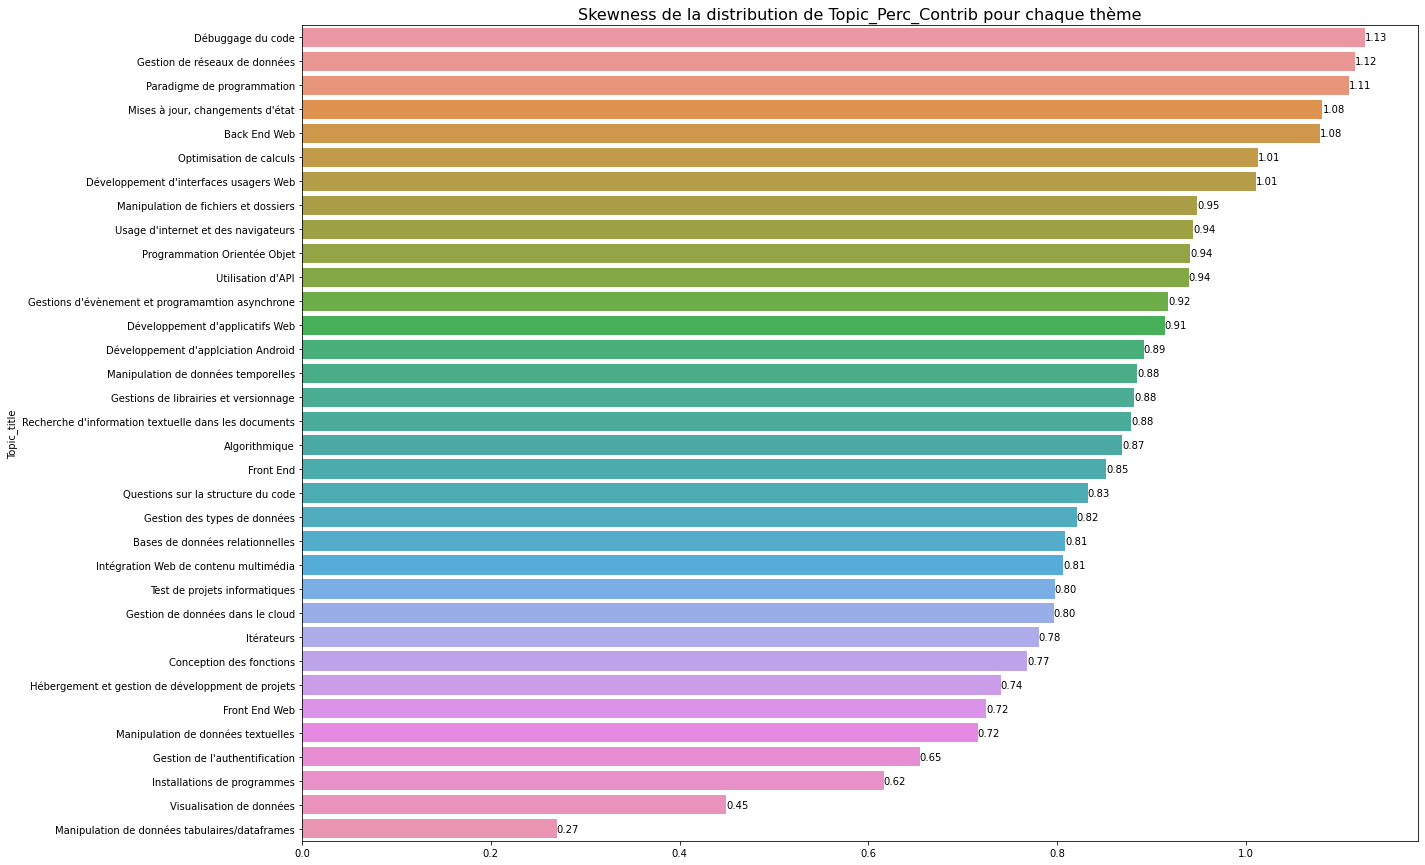

In [231]:
from scipy.stats import skew
plt.figure(figsize=(20,15))
ax = sns.barplot(x=df_topics_tags.groupby(by='Topic_title')['Topic_Perc_Contrib'].apply(lambda x: skew(x, bias=False)).sort_values(ascending=False).fillna(0).values,
            y=df_topics_tags.groupby(by='Topic_title')['Topic_Perc_Contrib'].apply(lambda x: skew(x, bias=False)).sort_values(ascending=False).index)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title("Skewness de la distribution de Topic_Perc_Contrib pour chaque thème", fontsize=16);

> La distribution de **Manipulation de données tabulaires/dataframes** est celle avec la plus grande moyenne et la plus petite asymétrie.

A l'opposé nous avons la distribution du thème **Débuggage du code** qui a la plus faible moyenne et la plus grande asymétrie, et on retrouve que ce thème est quasiment celui qui a le plus faible nombre de documents qui lui sont attribués ayant la valeur maximale de contribution de ce thème.

In [232]:
##################################CONCLUSION SUR le fait que les posts sur les dataframes sont plus interprétables, écrit de manières plus uniformes ?####
##### A vérifier le % de tokens utilisés dans les posts associés à ce thème ####

In [235]:
df_topics_tags['Text_length'] = df_topics_tags['Text'].str.split().apply(len)
df_topics_tags['Tags_nb'] = df_topics_tags['Tags'].apply(len)

### Influence du nombre de tags sur la longueur des posts

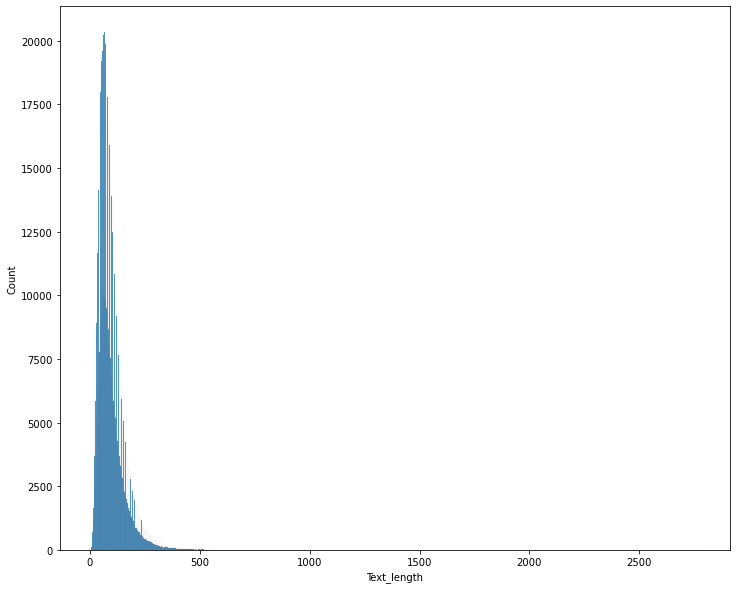

In [101]:
plt.figure(figsize=(12,10))
sns.histplot(data=df_topics_tags['Text_length']);

In [115]:
df_topics_tags['Text_length'].describe()

count    998596.000000
mean         99.992151
std          63.786990
min           4.000000
25%          59.000000
50%          84.000000
75%         123.000000
max        2772.000000
Name: Text_length, dtype: float64

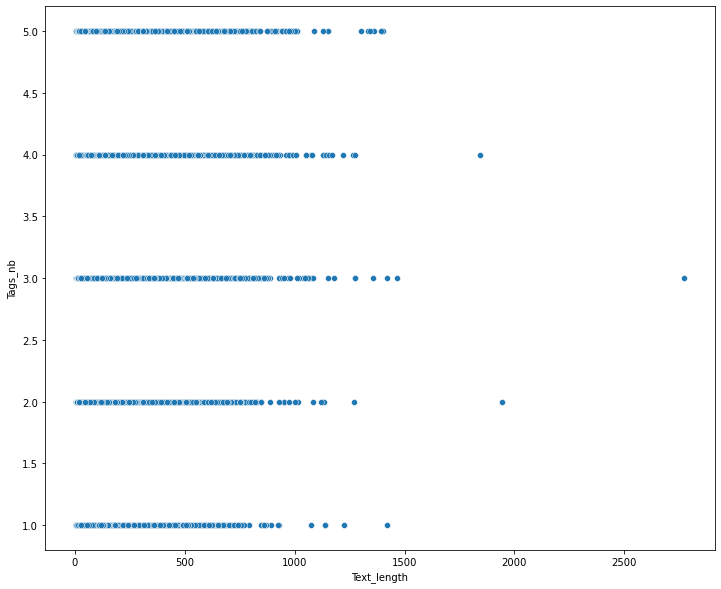

In [100]:
plt.figure(figsize=(12,10))
sns.scatterplot(y=df_topics_tags['Tags_nb'], x=df_topics_tags['Text_length']);

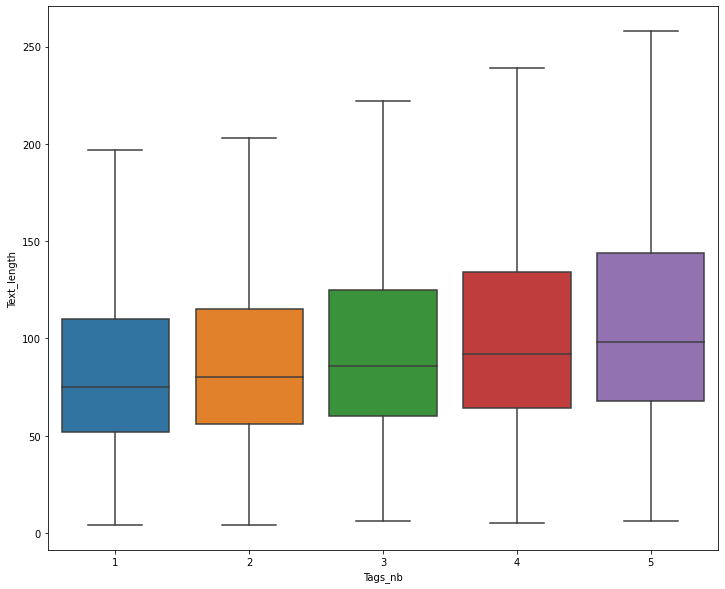

In [11]:
plt.figure(figsize=(12,10))
sns.boxplot(y=df_topics_tags['Text_length'], x=df_topics_tags['Tags_nb'], showfliers=False);

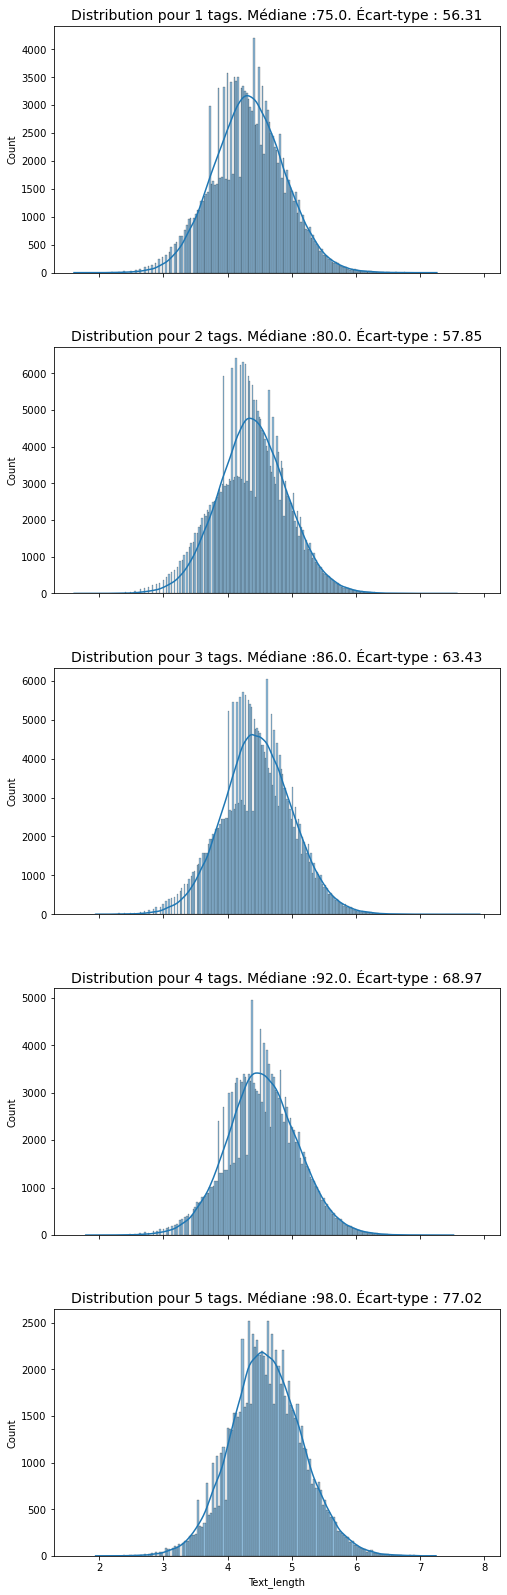

In [48]:
fig, axes = plt.subplots(5,1, figsize=(8, 25), sharex=True)
axes = axes.flatten()

for nb in range(5):
    data = df_topics_tags[df_topics_tags['Tags_nb']==nb+1]['Text_length']
    data_median = round(data.median(),2)
    data_std = round(data.std(),2)
    sns.histplot(data=np.log(data+1), kde=True, ax=axes[nb])
    axes[nb].set_title(f"Distribution pour {nb+1} tags. Médiane :{data_median}. Écart-type : {data_std}", fontsize=14)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
plt.show()

In [31]:
Kruskal_analysis = stats.kruskal(*[df_topics_tags[df_topics_tags['Tags_nb']==nb+1]['Text_length'] for nb in range(5)])
Kruskal_analysis

KruskalResult(statistic=21024.397923806002, pvalue=0.0)

In [46]:
list_permutations = [tuple(y) for y in np.unique([sorted(x) for x in list(itertools.permutations([1, 2, 3, 4, 5], 2))], axis=0)]
list_permutations

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

In [66]:
for i,j in list_permutations:
    print(f"p-value pour le test d'égalité des médianes {i} / {j} :\n{stats.median_test(df_topics_tags[df_topics_tags['Tags_nb']==i]['Text_length'],df_topics_tags[df_topics_tags['Tags_nb']==j]['Text_length'])[1]}")

p-value pour le test d'égalité des médianes 1 / 2 :
2.5322365208447833e-177
p-value pour le test d'égalité des médianes 1 / 3 :
0.0
p-value pour le test d'égalité des médianes 1 / 4 :
0.0
p-value pour le test d'égalité des médianes 1 / 5 :
0.0
p-value pour le test d'égalité des médianes 2 / 3 :
0.0
p-value pour le test d'égalité des médianes 2 / 4 :
0.0
p-value pour le test d'égalité des médianes 2 / 5 :
0.0
p-value pour le test d'égalité des médianes 3 / 4 :
8.417476472300945e-251
p-value pour le test d'égalité des médianes 3 / 5 :
0.0
p-value pour le test d'égalité des médianes 4 / 5 :
2.1035283216821985e-102


**Conlusion**

Les médianes sont toutes différentes une à une, et le **nombre de tags** est un facteur influent.

In [59]:
df_topics_tags['Tags_nb'].median()

3.0

In [102]:
df_topics_tags['Text_length'].median()

84.0

In [58]:
Contingency_test_analysis = stats.chi2_contingency(Median_test_analysis[3])
Contingency_test_analysis

(13775.798658142361,
 0.0,
 4,
 array([[ 80122.40259224, 149522.15168797, 141369.52052882,
          89940.11148953,  46442.81370144],
        [ 77564.59740776, 144748.84831203, 136856.47947118,
          87068.88851047,  44960.18629856]]))

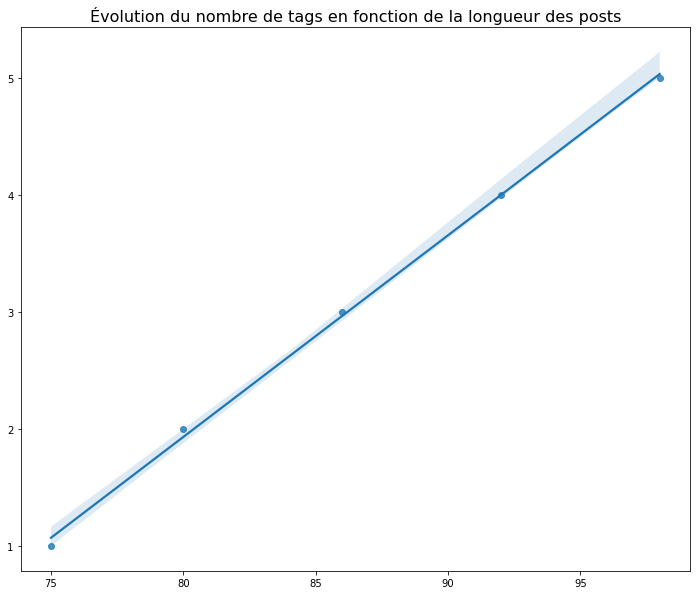

In [80]:
plt.figure(figsize=(12,10))
sns.regplot(y=list(range(1,6)), 
            x=[df_topics_tags[df_topics_tags['Tags_nb']==i+1]['Text_length'].median() for i in range(5)],
            seed=SEED
           );
plt.title("Évolution du nombre de tags en fonction de la longueur des posts", fontsize=16);

> La relation semble **linéaire**.

In [86]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(pd.DataFrame([df_topics_tags[df_topics_tags['Tags_nb']==i+1]['Text_length'].median() for i in range(5)]), pd.DataFrame(list(range(1,6))))

LinearRegression()

In [94]:
lin_reg.coef_[0][0], lin_reg.intercept_[0]

(0.172209026128266, -11.844418052256529)

In [98]:
est_nb_tags = lambda x : lin_reg.coef_[0][0]*x + lin_reg.intercept_[0]

In [117]:
list_text_length_nb_tags_int = [(x-lin_reg.intercept_[0])/lin_reg.coef_[0][0] for x in range(1,6)]
list_text_length_nb_tags_int

[74.58620689655172,
 80.39310344827587,
 86.2,
 92.00689655172414,
 97.81379310344828]

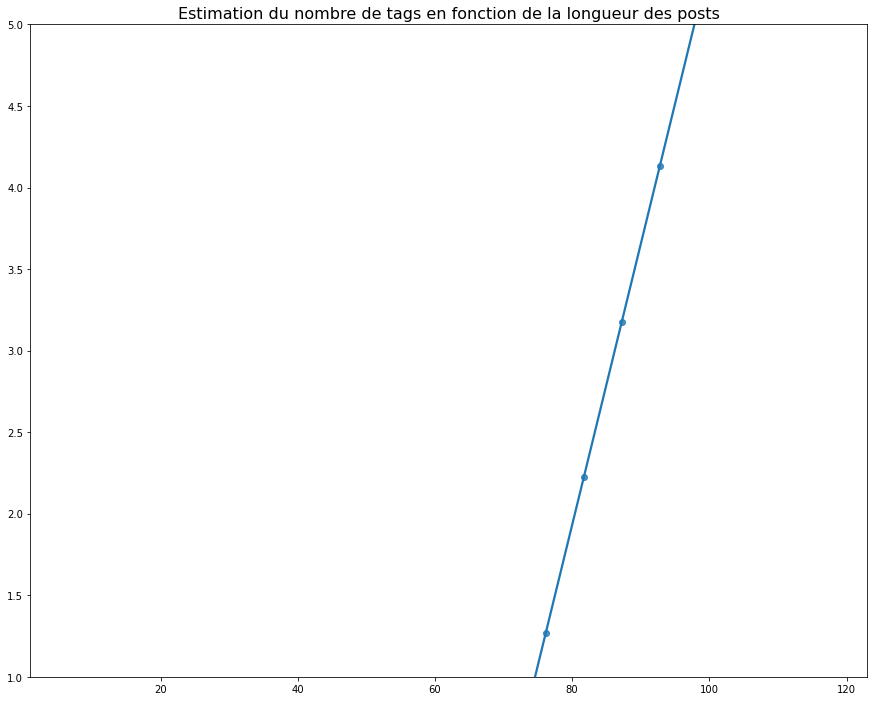

In [116]:
plt.figure(figsize=(15,12))
x_text_length = np.linspace(df_topics_tags['Text_length'].min(), df_topics_tags['Text_length'].max()+1,500)
sns.regplot(x= x_text_length,
            y= [est_nb_tags(x) for x in x_text_length]
           );
plt.ylim(1,5)
plt.xlim(1,123)
plt.title("Estimation du nombre de tags en fonction de la longueur des posts", fontsize=16);

In [240]:
df_topics_tags

Dominant_Topic  Topic_Perc_Contrib  \
0                   17            0.379639   
1                    5            0.182617   
2                   33            0.543457   
3                   28            0.597656   
4                   10            0.333984   
...                ...                 ...   
999995              26            0.300293   
999996              33            0.319580   
999997              26            0.193726   
999998               1            0.451416   
999999              16            0.531250   

                                                 Keywords  \
0       date, time, format, year, hour, day, month, mi...   
1       image, code, video, description, game, picture...   
2       function, code, work, c, return, example, erro...   
3       button, click, form, user, code, input, work, ...   
4       android, device, native, io, screen, code, vie...   
...                                                   ...   
999995  file, folder, script, path, code, directory, c...   
999996  function, code, work, c, return, example, erro...   
999997  file, folder, script, path, code, directory, c...   
999998  size, number, time, memory, n, limit, algorith...   
999999  string, character, word, text, example, line, ...   

                                                     Text  \
0       modifying bonita process instance after starte...   
1       what does elevation in drawshadow do exactlyi ...   
2       how to use a trait object that contains a meth...   
3       a way for users to store selections as inputs ...   
4       how to open downloaded photo using gallery app...   
...                                                   ...   
999995  can you do a pull in a mongodb bulk write whic...   
999996  non static method cannot be called staticallyi...   
999997  sorting oslistdirs arbitrary order for desired...   
999998  big o complexity of nested loopwhat could be t...   
999999  how to convert comma separated string to list ...   

                                  Tags                            Topic_title  \
0                             [bonita]    Manipulation de données temporelles   
1           [c++, dart, flutter, skia]  Intégration Web de contenu multimédia   
2                               [rust]               Conception des fonctions   
3                [r, shiny, shinyapps]                          Front End Web   
4       [expo, gallery, linker, react]    Développement d'applciation Android   
...                                ...                                    ...   
999995                       [mongodb]   Manipulation de fichiers et dossiers   
999996                  [laravel, php]               Conception des fonctions   
999997         [list, python, sorting]   Manipulation de fichiers et dossiers   
999998                           [big]                          Algorithmique   
999999                        [python]     Manipulation de données textuelles   

        Text_length  Tags_nb  
0                21        1  
1               195        4  
2                97        1  
3               157        3  
4               154        4  
...             ...      ...  
999995          118        1  
999996          122        2  
999997          123        3  
999998           28        1  
999999           57        1  

[998596 rows x 8 columns]

In [7]:
# df_topics_tags.to_pickle("datasets/tests/df_topics_tags.pkl")

df_topics_tags = pd.read_pickle("datasets/tests/df_topics_tags.pkl")

## Choix du modèle non-supervisé

Nous choisissons le modèle **LDA** car en dépit d'une plus faible valeur du score de cohérence *c_uci*, les thèmes qu'il distingue sont beaucoup plus facile à interpréter du point de vue du jugement humain.

De fait, les tags qu'il propose, qui sont les mots les plus représentatifs de chaque thème, auront plus de chance de susciter de l'attention auprès de l'auditoire de StackOverFlow compétent dans les domaines relatifs aux posts des utilisateurs qui utiliseront notre application.

Pour clôturer cette partie, nous pouvons visionner la projection des différents thèmes de notre modèle optimal dans le premier plan factoriel suite à une réduction de dimension avec l'algorithme *Multi-Dimensional Scaling* :

In [76]:
from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

In [77]:
# vis_lda = pyLDAvis.gensim_models.prepare(LDA_optimal_final, bow_corpus, id2word)
# pyLDAvis.save_html(vis, 'LDA_optimal_viz.html')
display(HTML('LDA_optimal_viz.html'))

# Approche supervisée

Dans cette partie, nous allons procéder en **2 étapes** :

   1. **Vectorisation** : nous allons numériser nos données nettoyées en utilisant les approches : 
        - **TF-IDF**
        - **Doc2Vec**
        - **BERT**
        - **USE**


   2. **Classification Multi-labels** : nous entraînerons et évaluerons ensuite sur les différents jeux de données vectorisés obtenus, les modèles de classification  suivants : 
       - **Random Forest**
       - **KNNClassifier**
       - **Passive-Agressive**
       - **Multinomial Naive Bayes**

In [12]:
df_supervised = pd.read_pickle("datasets/tests/lemmatized_datas.pkl")

## Réduction de la dimension de la variable cible

Dans un soucis de réduction de dimensions de notre jeu de données vectorisé, nous n'allons conserver que les posts dont les tags sont une combinaisons des **100 tags les plus fréquents**.

En effet, nous sommes ici dans le cadre d'une **classification multi-labels**, et chaque vecteur cible à la dimension du nombre de labels différents.

In [31]:
tags_count = Counter()
for token in df_supervised['tags'].to_list():
    tags_count.update(token)

In [32]:
tags_count.most_common(100)

[('python', 177112),
 ('javascript', 111290),
 ('reactjs', 56649),
 ('java', 51054),
 ('r', 46681),
 ('pandas', 40665),
 ('html', 39963),
 ('android', 38975),
 ('c#', 37104),
 ('google', 36236),
 ('node', 30565),
 ('css', 29915),
 ('react', 29819),
 ('flutter', 27650),
 ('c++', 27567),
 ('typescript', 25838),
 ('sql', 25015),
 ('php', 23047),
 ('dataframe', 22567),
 ('amazon', 21026),
 ('azure', 19929),
 ('angular', 19263),
 ('spring', 18924),
 ('c', 18660),
 ('arrays', 17856),
 ('django', 17817),
 ('swift', 16741),
 ('ios', 15279),
 ('json', 14162),
 ('apache', 14094),
 ('asp', 14000),
 ('dart', 13787),
 ('vue', 13736),
 ('firebase', 13698),
 ('docker', 13602),
 ('visual', 12570),
 ('kotlin', 12190),
 ('laravel', 12108),
 ('mysql', 12079),
 ('jquery', 12027),
 ('postgresql', 10941),
 ('numpy', 10798),
 ('regex', 10715),
 ('mongodb', 10251),
 ('aws', 9977),
 ('list', 9291),
 ('web', 9153),
 ('tensorflow', 9102),
 ('kubernetes', 8983),
 ('excel', 8818),
 ('swiftui', 8564),
 ('data', 812

In [40]:
list_100_tags = [x[0] for x in tags_count.most_common(100)]
list_100_tags

['python',
 'javascript',
 'reactjs',
 'java',
 'r',
 'pandas',
 'html',
 'android',
 'c#',
 'google',
 'node',
 'css',
 'react',
 'flutter',
 'c++',
 'typescript',
 'sql',
 'php',
 'dataframe',
 'amazon',
 'azure',
 'angular',
 'spring',
 'c',
 'arrays',
 'django',
 'swift',
 'ios',
 'json',
 'apache',
 'asp',
 'dart',
 'vue',
 'firebase',
 'docker',
 'visual',
 'kotlin',
 'laravel',
 'mysql',
 'jquery',
 'postgresql',
 'numpy',
 'regex',
 'mongodb',
 'aws',
 'list',
 'web',
 'tensorflow',
 'kubernetes',
 'excel',
 'swiftui',
 'data',
 'git',
 'string',
 'powershell',
 'linux',
 'selenium',
 'ruby',
 'windows',
 'dplyr',
 'github',
 'rust',
 'matplotlib',
 'go',
 'wordpress',
 'ggplot',
 'bash',
 'express',
 'api',
 'database',
 'vba',
 'function',
 'next',
 'discord',
 'xcode',
 'algorithm',
 'keras',
 'material',
 'dictionary',
 'oracle',
 'image',
 'pyspark',
 'loops',
 'xml',
 'macos',
 'unity',
 'vuejs',
 'npm',
 'scala',
 'machine',
 'datetime',
 'pytorch',
 'unit',
 'csv',
 'ht

In [38]:
load_pickle("list_100_tags")

Variable créée sous le nom 'list_100_tags' 


In [36]:
df_supervised['is_in_tags_100'] = df_supervised['tags'].apply(lambda tags_list: len([tag for tag in tags_list if tag in list_100_tags]) == len(tags_list))

In [14]:
# df_100_tags = df_supervised[df_supervised['is_in_tags_100']][['tokens', 'tags']]
# df_100_tags.to_pickle("datasets/tests/df_100_tags.pkl")
df_100_tags = pd.read_pickle("datasets/tests/df_100_tags.pkl")
df_100_tags

tokens  \
2       [trait, error, circumstance, way, code, object...   
7       [alarmmanager, manifest, problem, myalarm, ala...   
9       [demo, matstepis, event, element, click, stack...   
16      [docker, update, parameter, name, network, for...   
17      [year, update, item, array, choice, field, sto...   
...                                                   ...   
999985  [year, postgresqli, day, deduct, month, date, ...   
999992  [boolean, column, apologize, value, thanks, da...   
999995  [update, bulkwrite, array, script, example, hi...   
999996  [staticallyi, approach, calculation, rename, b...   
999999  [water, coffee, comma, item, pythoni, text, py...   

                                      tags  
2                                   [rust]  
7                          [android, java]  
9        [angular, javascript, typescript]  
16                                [docker]  
17                      [firebase, google]  
...                                    ...  
999985                   [postgresql, sql]  
999992  [dataframe, numpy, pandas, python]  
999995                           [mongodb]  
999996                      [laravel, php]  
999999                            [python]  

[318940 rows x 2 columns]

In [44]:
vocab_supervised = Counter()
for token in df_100_tags["tokens"]:
    vocab_supervised.update(token)

In [45]:
vocab_supervised.most_common(1000)

[('code', 106360),
 ('error', 71697),
 ('value', 71436),
 ('work', 67751),
 ('data', 54484),
 ('file', 50954),
 ('example', 48295),
 ('column', 47598),
 ('function', 46083),
 ('problem', 44079),
 ('user', 35160),
 ('thanks', 32034),
 ('change', 31979),
 ('time', 31641),
 ('output', 31164),
 ('row', 30521),
 ('list', 29181),
 ('object', 27971),
 ('type', 27456),
 ('name', 27182),
 ('string', 27102),
 ('number', 27027),
 ('question', 26581),
 ('issue', 26232),
 ('array', 25269),
 ('method', 24264),
 ('table', 23725),
 ('line', 21903),
 ('image', 21455),
 ('element', 21420),
 ('page', 21409),
 ('solution', 21333),
 ('return', 20965),
 ('python', 20882),
 ('dataframe', 20500),
 ('class', 20223),
 ('component', 20109),
 ('case', 20008),
 ('need', 18896),
 ('button', 18709),
 ('project', 17998),
 ('input', 17917),
 ('idea', 17422),
 ('update', 17414),
 ('text', 16712),
 ('api', 16370),
 ('field', 16251),
 ('query', 16027),
 ('message', 15841),
 ('check', 15189),
 ('version', 15078),
 ('item'

In [46]:
len(vocab_supervised.values())

455731

On observe que pour un peu moins d'un tiers du nombre d'observations total, nous avons un vocabulaire diminué dans les mêmes proportions.

(**455 731** contre **1 379 766**)

### Limitations matérielles

En raison des limites de nos capacités de mémoire de travail et de nombre de cellules de calculs, nous sommes contraints de réduire la taille de notre jeu de données de travail à **50 000** observations.

En effet, en prenant la totalité des **318 940** observations ci-haut, avec le jeu d'entraînement (80% des observations), nous devons crééer une matrice **TF-IDF** de forme **(379618, 39955)** qui nécessite une occuperait en mémoire un volume de **113. GiB** avec des données de type **float16**...

> En divisant par 6 le nombre d'observations, nous espérons réduire d'un même facteur le vocabulaire, et ramener à des ordres de grandeurs manipulables localement la taille de nos jeux de données.

### Séparation du jeu de données

In [50]:
# df_100_tags_red = df_100_tags.sample(50000)
# df_100_tags_red.to_pickle("datasets/tests/df_100_tags_red.pkl")
df_100_tags_red = pd.read_pickle("datasets/tests/df_100_tags_red.pkl")

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_100_tags_red['tokens'], df_100_tags_red['tags'], test_size=0.2, random_state=SEED)

In [50]:
# X_train.to_pickle("datasets/tests/X_train.pkl")
# X_test.to_pickle("datasets/tests/X_test.pkl")
# y_train.to_pickle("datasets/tests/y_train.pkl")
# y_test.to_pickle("datasets/tests/y_test.pkl")

In [54]:
X_train = pd.read_pickle("datasets/tests/X_train.pkl")
X_test = pd.read_pickle("datasets/tests/X_test.pkl")
y_train = pd.read_pickle("datasets/tests/y_train.pkl")
y_test = pd.read_pickle("datasets/tests/y_test.pkl")

<u>**Il faut nous assurer que nous rencontrons bien tous les tags possibles durant la phase d'entraînement**</u> !!!

In [51]:
y_train

791974    [javascript, reactjs]
985640                    [c++]
580833    [javascript, reactjs]
166913                      [r]
195136             [typescript]
                  ...          
389015                     [c#]
940396    [angular, typescript]
395971                   [http]
408129            [amazon, aws]
126106             [javascript]
Name: tags, Length: 40000, dtype: object

In [52]:
verif_tags = Counter()
for token in y_train.to_list():
    verif_tags.update(token)
len(verif_tags.values())

100

Nous avons bien tous les tags possibles dans notre jeu d'entraînement.

## Vectorisation

### TF-IDF

On entraîne un **dictionnaire** sur les données d'entraînement, ainsi que le modèle de **TF-IDF** sur le **Bag-Of-Words** d'entraînement, et on crée le **Bag_Of_Words** de test séparément.

Nous créons ensuite les **matrices TF-IDF** d'entraînement et de test à partir du modèle **TF-IDF** entraîné appliqué aux vecteurs **Bag-Of-Words** d'une part des documents d'entraînement, d'autre part sur les documents de test.

In [55]:
# Dictionnaire, Bag-Of-Words d'entraînement et entraînement du modèle TF-IDF
# nous prenons bien soin de conserver dans le vocabulaire l'ensemble des tags à prédire !

corpus_train = X_train.to_list()

id2word_train = corpora.Dictionary(corpus_train)
id2word_train.filter_extremes(keep_tokens=list_100_tags)

bow_corpus_train = [id2word_train.doc2bow(doc) for doc in corpus_train]

tfidf = TfidfModel(bow_corpus_train)

vocab = list(id2word_train.values())
len(vocab)

7241

Pour le jeu de test, nous gardons pour chaque document, uniquement les tokens du vocabulaire vu à l'entraînement :

In [56]:
X_test_vocab = pd.DataFrame(X_test)['tokens'].apply(lambda x: [y for y in x if y in vocab])

In [57]:
# Bag-Of-Words de test

corpus_test = X_test_vocab.to_list()
bow_corpus_test = [id2word_train.doc2bow(doc) for doc in corpus_test]

Nous pouvons maintenant obtenir les vecteurs **TF-IDF** de nos jeux d'entraînement et de test :

In [58]:
tfidf_corpus_train = [tfidf[bow] for bow in bow_corpus_train]

tfidf_corpus_test = [tfidf[bow] for bow in bow_corpus_test]

Puis les matrices **TF-IDF** associées :

In [59]:
X_train_tfidf = pd.DataFrame(data=np.zeros((len(tfidf_corpus_train), len(vocab))),
                             index=X_train.index,
                             columns=vocab
                            )

list_train_index = list(X_train.index)

for doc_index in range(len(list_train_index)):
    for token_index, freq in tfidf[bow_corpus_train[doc_index]]:
        X_train_tfidf.loc[list_train_index[doc_index], id2word_train[token_index]] = freq

X_train_tfidf

box    change   console   default     error     event    export  \
791974  0.274742  0.149723  0.229799  0.225452  0.097935  0.240495  0.308918   
985640  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
580833  0.000000  0.000000  0.000000  0.000000  0.118314  0.000000  0.000000   
166913  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
195136  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
389015  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
940396  0.000000  0.000000  0.000000  0.000000  0.202916  0.000000  0.000000   
395971  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
408129  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
126106  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            fire     home  onchange  ...  runing  minutesi  previewview  \
791974  0.366495  0.31019  0.397562  ...     0.0       0.0          0.0   
985640  0.000000  0.00000  0.000000  ...     0.0       0.0          0.0   
580833  0.000000  0.00000  0.000000  ...     0.0       0.0          0.0   
166913  0.000000  0.00000  0.000000  ...     0.0       0.0          0.0   
195136  0.000000  0.00000  0.000000  ...     0.0       0.0          0.0   
...          ...      ...       ...  ...     ...       ...          ...   
389015  0.000000  0.00000  0.000000  ...     0.0       0.0          0.0   
940396  0.000000  0.00000  0.000000  ...     0.0       0.0          0.0   
395971  0.000000  0.00000  0.000000  ...     0.0       0.0          0.0   
408129  0.000000  0.00000  0.000000  ...     0.0       0.0          0.0   
126106  0.000000  0.00000  0.000000  ...     0.0       0.0          0.0   

        inout  cellphone  profilejs   wc  bump  createdby  sugar  
791974    0.0        0.0        0.0  0.0   0.0        0.0    0.0  
985640    0.0        0.0        0.0  0.0   0.0        0.0    0.0  
580833    0.0        0.0        0.0  0.0   0.0        0.0    0.0  
166913    0.0        0.0        0.0  0.0   0.0        0.0    0.0  
195136    0.0        0.0        0.0  0.0   0.0        0.0    0.0  
...       ...        ...        ...  ...   ...        ...    ...  
389015    0.0        0.0        0.0  0.0   0.0        0.0    0.0  
940396    0.0        0.0        0.0  0.0   0.0        0.0    0.0  
395971    0.0        0.0        0.0  0.0   0.0        0.0    0.0  
408129    0.0        0.0        0.0  0.0   0.0        0.0    0.0  
126106    0.0        0.0        0.0  0.0   0.0        0.0    0.0  

[40000 rows x 7241 columns]

In [60]:
X_train_tfidf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 791974 to 126106
Columns: 7241 entries, box to sugar
dtypes: float64(7241)
memory usage: 2.2 GB


> En divisant par **4** la taille de notre jeu de données de départ, nous avons réduit par **3** notre vocabulaire, soit une réduction par **12** de la taille de notre matrice **TF-IDF** et par **16** l'espace en mémoire.

In [61]:
X_test_tfidf = pd.DataFrame(data=np.zeros((len(tfidf_corpus_test), len(vocab))),
                             index=X_test.index,
                             columns=vocab
                            )

list_test_index = list(X_test.index)

for doc_index in range(len(list_test_index)):
    for token_index, freq in tfidf[bow_corpus_test[doc_index]]:
        X_test_tfidf.loc[list_test_index[doc_index], id2word_train[token_index]] = freq

X_test_tfidf

box    change  console  default     error  event  export  fire  \
570244  0.0  0.000000      0.0      0.0  0.000000    0.0     0.0   0.0   
658972  0.0  0.000000      0.0      0.0  0.059674    0.0     0.0   0.0   
560643  0.0  0.000000      0.0      0.0  0.000000    0.0     0.0   0.0   
760231  0.0  0.000000      0.0      0.0  0.000000    0.0     0.0   0.0   
71319   0.0  0.000000      0.0      0.0  0.120314    0.0     0.0   0.0   
...     ...       ...      ...      ...       ...    ...     ...   ...   
795292  0.0  0.000000      0.0      0.0  0.081893    0.0     0.0   0.0   
804764  0.0  0.000000      0.0      0.0  0.000000    0.0     0.0   0.0   
839304  0.0  0.118671      0.0      0.0  0.000000    0.0     0.0   0.0   
404411  0.0  0.000000      0.0      0.0  0.000000    0.0     0.0   0.0   
204496  0.0  0.000000      0.0      0.0  0.000000    0.0     0.0   0.0   

            home  onchange  ...  runing  minutesi  previewview  inout  \
570244  0.000000       0.0  ...     0.0       0.0          0.0    0.0   
658972  0.189005       0.0  ...     0.0       0.0          0.0    0.0   
560643  0.000000       0.0  ...     0.0       0.0          0.0    0.0   
760231  0.000000       0.0  ...     0.0       0.0          0.0    0.0   
71319   0.000000       0.0  ...     0.0       0.0          0.0    0.0   
...          ...       ...  ...     ...       ...          ...    ...   
795292  0.000000       0.0  ...     0.0       0.0          0.0    0.0   
804764  0.000000       0.0  ...     0.0       0.0          0.0    0.0   
839304  0.000000       0.0  ...     0.0       0.0          0.0    0.0   
404411  0.000000       0.0  ...     0.0       0.0          0.0    0.0   
204496  0.000000       0.0  ...     0.0       0.0          0.0    0.0   

        cellphone  profilejs   wc  bump  createdby  sugar  
570244        0.0        0.0  0.0   0.0        0.0    0.0  
658972        0.0        0.0  0.0   0.0        0.0    0.0  
560643        0.0        0.0  0.0   0.0        0.0    0.0  
760231        0.0        0.0  0.0   0.0        0.0    0.0  
71319         0.0        0.0  0.0   0.0        0.0    0.0  
...           ...        ...  ...   ...        ...    ...  
795292        0.0        0.0  0.0   0.0        0.0    0.0  
804764        0.0        0.0  0.0   0.0        0.0    0.0  
839304        0.0        0.0  0.0   0.0        0.0    0.0  
404411        0.0        0.0  0.0   0.0        0.0    0.0  
204496        0.0        0.0  0.0   0.0        0.0    0.0  

[10000 rows x 7241 columns]

In [62]:
# X_train_tfidf.to_pickle("datasets/tests/X_train_tfidf.pkl")
# X_test_tfidf.to_pickle("datasets/tests/X_test_tfidf.pkl")
# save_pickle(corpus_train, "corpus_train")
# save_pickle(id2word_train, "id2word_train")
# save_pickle(bow_corpus_train, "bow_corpus_train")
# save_pickle(tfidf, "tfidf")
# save_pickle(tfidf_corpus_train, "tfidf_corpus_train")
# save_pickle(tfidf_corpus_test, "tfidf_corpus_test")

Fichier enregistré sous le nom 'corpus_train' 
Fichier enregistré sous le nom 'id2word_train' 
Fichier enregistré sous le nom 'bow_corpus_train' 
Fichier enregistré sous le nom 'tfidf' 
Fichier enregistré sous le nom 'tfidf_corpus_train' 
Fichier enregistré sous le nom 'tfidf_corpus_test' 


In [83]:
X_train_tfidf = pd.read_pickle("datasets/tests/X_train_tfidf.pkl")
X_test_tfidf = pd.read_pickle("datasets/tests/X_test_tfidf.pkl")

### Doc2Vec

Pour l'entraînement de notre modèle **Doc2Vec**, nous partons de notre corpus nettoyés, mais non lemmatisé.

In [22]:
# df_no_lemmas = pd.read_pickle("datasets/tests/df_datas_nouns.pkl")
# df_no_lemmas_red = df_no_lemmas.loc[df_100_tags_red.index]
# df_no_lemmas_red.to_pickle("datasets/tests/df_no_lemmas_red")
df_no_lemmas_red = pd.read_pickle("datasets/tests/df_no_lemmas_red")

In [53]:
df_no_lemmas_red

tokens  \
375306  [workingi, mysql, regex, test, marks, database...   
807325  [size, population, number, truncate, functions...   
31013   [urli, download, upload, uploaded, uploads, pr...   
594745  [authenticate, username, userpool, attribute, ...   
599083  [fields, playground, figure, correctlyi, types...   
...                                                   ...   
625692  [internet, oauth, stack, issue, controller, cl...   
772060  [getxcontroller, initialized, stack, orderscon...   
955087  [change, component, parent, logout, question, ...   
105665  [data, vueconfigjs, project, outputs, json, fo...   
524091  [customerusagereportsgetplease, httpsdeveloper...   

                                tags  
375306                [mysql, regex]  
807325                           [r]  
31013   [firebase, html, javascript]  
594745                 [amazon, aws]  
599083                  [typescript]  
...                              ...  
625692                      [spring]  
772060               [dart, flutter]  
955087      [javascript, vue, vuejs]  
105665                [vue, webpack]  
524091                      [google]  

[50000 rows x 2 columns]

In [65]:
df_no_lemmas_red['tokens'] = df_no_lemmas_red['tokens'].str.join(' ')
df_no_lemmas_red

tokens  \
375306  workingi mysql regex test marks database javas...   
807325  size population number truncate functions solu...   
31013   urli download upload uploaded uploads printed ...   
594745  authenticate username userpool attribute advan...   
599083  fields playground figure correctlyi types code...   
...                                                   ...   
625692  internet oauth stack issue controller class se...   
772060  getxcontroller initialized stack orderscontrol...   
955087  change component parent logout question navbar...   
105665  data vueconfigjs project outputs json folder i...   
524091  customerusagereportsgetplease httpsdevelopersg...   

                                tags  
375306                [mysql, regex]  
807325                           [r]  
31013   [firebase, html, javascript]  
594745                 [amazon, aws]  
599083                  [typescript]  
...                              ...  
625692                      [spring]  
772060               [dart, flutter]  
955087      [javascript, vue, vuejs]  
105665                [vue, webpack]  
524091                      [google]  

[50000 rows x 2 columns]

In [66]:
df_no_lemmas_red.columns = ['text', 'tags']

In [67]:
from gensim.models import Doc2Vec
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument

In [55]:
train_df = df_no_lemmas_red.loc[X_train.index]
test_df = df_no_lemmas_red.loc[X_test.index]

In [69]:
train_tagged_df = train_df.apply(lambda doc: TaggedDocument(words=doc['text'].split(), tags=doc['tags']), axis=1)
test_tagged_df = test_df.apply(lambda doc: TaggedDocument(words=doc['text'].split(), tags=doc['tags']), axis=1)

In [70]:
def Doc2VecTraining(train_tagged_df, no_epochs):
    
    ## building a distributed bag of words model 
    
    print("Construction du modèle, apprentissage du vocabulaire")
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=2, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged_df.values)])
    
    ## training the model
    
    print("Entraînement du modèle durant", no_epochs, "époques" )
    for epoch in trange(no_epochs):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged_df.values)]), 
                total_examples=len(train_tagged_df.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    return model_dbow

In [71]:
doc2vec = Doc2VecTraining(train_tagged_df, 30)

Construction du modèle, apprentissage du vocabulaire


  0%|          | 0/40000 [00:00<?, ?it/s]

Entraînement du modèle durant 30 époques


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

In [72]:
# enregistrement du modèle doc2vec

# doc2vec_file = datapath("doc2vec")
# doc2vec.save(doc2vec_file)

doc2vec = Doc2Vec.load(doc2vec_file)

On peut désormais créer nos données d'entraînement et de test pour nos modèles de classification :

In [73]:
def doc2vec_features(model, tagged_dataset):
    sents = tagged_dataset.values
    list_features = [model.infer_vector(doc.words) for doc in sents]
    return list_features

In [74]:
list_feat_train_doc2vec = doc2vec_features(doc2vec, train_tagged_df)

In [75]:
list_feat_test_doc2vec = doc2vec_features(doc2vec, test_tagged_df)

In [8]:
X_train_doc2vec = pd.DataFrame(data=list_feat_train_doc2vec, index=train_df.index)

X_test_doc2vec = pd.DataFrame(data=list_feat_test_doc2vec, index=test_df.index)

NameError: name 'list_feat_train_doc2vec' is not defined

In [77]:
# X_train_doc2vec.to_pickle("datasets/tests/X_train_doc2vec.pkl")
# X_test_doc2vec.to_pickle("datasets/tests/X_test_doc2vec.pkl")

In [84]:
X_train_doc2vec = pd.read_pickle("datasets/tests/X_train_doc2vec.pkl")
X_test_doc2vec = pd.read_pickle("datasets/tests/X_test_doc2vec.pkl")

## BERT

In [49]:
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('all-MiniLM-L6-v2')

In [8]:
load_pickle('sentences_train')

Variable créée sous le nom 'sentences_train' 


In [10]:
X_train_bert = bert.encode(sentences_train, show_progress_bar=True)

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

In [171]:
np.shape(X_train_bert)

(40000, 384)

In [79]:
X_train_bert = pd.read_pickle("datasets/tests/X_train_bert.pkl")

## USE

In [13]:
import tensorflow_hub as hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [17]:
batch_size = 500

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    start = timeit.default_timer()

    for step in trange(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = use_model(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate([features,feat])

    duration = round(timeit.default_timer() - start,0)
    print(f"Durée total du traitement : {duration} secondes" )
    return features

In [18]:
X_train_use = feature_USE_fct(sentences_train, batch_size)

  0%|          | 0/80 [00:00<?, ?it/s]

Durée total du traitement : 7.0 secondes


In [172]:
np.shape(X_train_use)

(40000, 512)

In [92]:
X_train_use

array([[-0.03289396, -0.04551011, -0.01885777, ..., -0.04524931,
        -0.03867836,  0.03870545],
       [ 0.06237169, -0.07302643, -0.03633885, ...,  0.07707246,
         0.02593587, -0.02230162],
       [ 0.02004296, -0.02839455, -0.00500629, ...,  0.05845023,
        -0.01278163, -0.0172794 ],
       ...,
       [-0.04557318,  0.0586141 ,  0.06330036, ..., -0.01428497,
         0.01101695, -0.06389253],
       [ 0.05987926, -0.07307418, -0.01018701, ...,  0.07604813,
         0.00147952, -0.05990424],
       [-0.04336659, -0.06213217, -0.00144972, ...,  0.08035618,
         0.01276803,  0.02946266]], dtype=float32)

In [ ]:
X_train_use = pd.read_pickle("datasets/tests/X_train_use.pkl")

## Mise en forme de la cible pour la classification multi-label

Afin de permettre à nos modèles d'appréhender la multiplicité des labels à prédire, nous allons transformer notre valeur cible en un tableau binaire avec autant de colonne que de labels (300) et avec spour chaque ligne un 1 si l'observation possède le label en colone, un 0 sinon.

In [434]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=list_100_tags)

In [108]:
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.transform(y_test)

In [109]:
# save_pickle(y_train_mlb, "y_train_mlb")
# save_pickle(y_test_mlb, "y_test_mlb")

Fichier enregistré sous le nom 'y_train_mlb' 
Fichier enregistré sous le nom 'y_test_mlb' 


In [81]:
load_pickle("y_train_mlb")
load_pickle("y_test_mlb")

Variable créée sous le nom 'y_train_mlb' 
Variable créée sous le nom 'y_test_mlb' 


## Évaluation des modèles de classification

Afin de contourner le problème frontal de classification multi-label qui n'est pas supporté nativement par tous les modèles de classifieur, nous allons utiliser la classe **OneVsRestClassifier** qui permet d'entraîner un ensemble de classificateurs binaires (un par label de type *One-Vs-All*).

Nous évaluerons nos modèle en réalisant une validation croisée (3 passes) et nous conserverons la moyenne des résultats obtenus lors de chacun des passes.

### Métriques de performances

Dans le cadre d'un problème de classificaion multi-classe ou multi-label, nous ne pouvons nous contenter de mesurer simplement les métriques de performance de classification telles quelles.

Nous devons les analyser pour chaque classe, et en proposer la synthèse.

C'est pour quoi, nous utiliserons utiliserons le **classification_report** proposé par *scikit-learn* qui permet de calculer pour chaque classe les métriques suivantes :

   - **Precision**
   - **Recall**
   - **F1_Score**
   - **Support**

Ce rapport fournit également pour chacune de ces métriques, les moyennes :

   - **micro**
   - **macro**
   - **weighted**
   - **samples**
   
Nous rajoutons à ce rapport la mesure du **score de similarité jaccard**.

### Synthèse des métriques déterminante

Étant donnée que les labels à prédire apparaissent dans des proportions inégales, il apparaît important de se concentrer sur la <u>**moyenne micro**</u> des métriques de performances citées plus haut, afin de rendre compte de la fréquence d'apparition des labels dans la mesure de leur moyenne.

En effet, la précision de nos modèles pour classer une observation dans un label présent souvent, importe plus que celle de classer une observation dans un label rare.

In [39]:
from sklearn.base import clone

from sklearn.metrics import classification_report, jaccard_score

from sklearn.model_selection import KFold

# modèles nativements multilabels

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# modèles supportant nativement la classification multi-classe "One-Vs-The-Rest"

from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import PassiveAggressiveClassifier

In [95]:
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=SEED, verbose=1)
kn_clf = KNeighborsClassifier(n_jobs=+1)
nb_clf = OneVsRestClassifier(make_pipeline(MinMaxScaler(),MultinomialNB()), n_jobs=-1, verbose=5)
pass_agg_clf = OneVsRestClassifier(PassiveAggressiveClassifier(n_jobs=-1, random_state=SEED), n_jobs=-1, verbose=5)

In [ ]:
models_to_train = {
                   'RandomForest':rf_clf,
                   'KNeighboors':kn_clf,
                   'PassiveAggressive':pass_agg_clf,
                   'MultinomialNB':nb_clf
                  }

In [68]:
kfold = KFold(n_splits=2, shuffle=True, random_state=SEED)

In [69]:
def mean_df(*list_df):
    if list_df:
        results = list_df[0]
        for i in range(1,len(list_df)):
            results += list_df[i]
        return results/len(list_df)
    else:
        None

In [70]:
def cross_val_models(X_train, dict_name):

    X = np.array(X_train.copy())
    
    y = y_train_mlb.copy()
    
    for mdl_name, model in models_to_train.items():
        
        training_durations = list()
        df_class_reports = list()
        jaccard_similiraties = list()
        
        i=0
        
        print(f"Début de l'entraînement du modèle {mdl_name}..\n")
        
        for train_index, test_index in kfold.split(X):
            
            print(f"\tPasse n°{i+1} de la validation croisée\n")
            
            mdl = clone(model)

            start_fit_time = timeit.default_timer()
            
            mdl.fit(X[train_index], y[train_index])
            
            fit_duration =  round(timeit.default_timer() - start_fit_time, 2)
            
            training_durations.append(fit_duration)
            print(f"\t\tDurée de l'entraînement n°{i+1} : {fit_duration}secondes\n")
            i+=1
            
            y_pred = mdl.predict(X[test_index])
            
            print(f"\t\tÉvaluation du modèle\n")
            class_report_df = pd.DataFrame(data=classification_report(y[test_index], y_pred, 
                                                                      target_names=list_100_tags, 
                                                                      zero_division=0, output_dict=True
                                                                     )
                                          )
            jac_sim_df = pd.DataFrame(data=jaccard_score(y[test_index], y_pred, average=None).reshape(1,-1), 
                                      columns=list_100_tags, 
                                      index=['jaccard_score'])
                                                      
            for avg_mode in ['micro', 'macro', 'weighted', 'samples']:
                jac_sim_df[avg_mode+' avg'] = jaccard_score(y[test_index], y_pred, average=avg_mode)
            print(f"\t\tEnregistrement des métriques d'évaluation...\n")    
            df_class_reports.append(pd.concat([class_report_df, jac_sim_df]))
        
        if dict_name in globals():
            globals()[dict_name][mdl_name] = dict()
            globals()[dict_name][mdl_name]['training_duration'] = np.mean(training_durations)
            globals()[dict_name][mdl_name]['avg_class_report'] = mean_df(*df_class_reports)
        else:
            globals()[dict_name] = dict()
            globals()[dict_name][mdl_name] = dict()
            globals()[dict_name][mdl_name]['training_duration'] = np.mean(training_durations)
            globals()[dict_name][mdl_name]['avg_class_report'] = mean_df(*df_class_reports)
    
    print("Évaluation des modèles terminée.\n")
    print(f"Les résultats ont été enregistrés dans la variable '{dict_name}'.")

In [56]:
def display_results(dict_results):
    """
        But : 
            Afficher les informations pertinentes sur les validations croisées des modèles
        
        Arguments : 
            dictionnaire des résulats des validations croisées des modèles
        
        Valeur retournée : 
            None. Affiche les informations pertinentes sur les validations croisées des modèles
    """
    
    for mdl_name in dict_results.keys():
        print(mdl_name+'\n')
        print(f"Durée moyenne d'entraînement : {round(dict_results[mdl_name]['training_duration'],2)} secondes.\n")
        
        tmp_df = dict_results[mdl_name]['avg_class_report'].drop(index=['support'])
        nb_null_supports = tmp_df.loc[:, tmp_df.mean()==0.0].shape[1]
        print(f"Nombre de labels non-classés : {nb_null_supports}.\n")
        
        tmp_df = dict_results[mdl_name]['avg_class_report'].loc['support', tmp_df.loc[:, tmp_df.mean()==0.0].columns]
        mean_null_supports = round(tmp_df.mean(),2) if not np.isnan(tmp_df.mean()) else 'NC'
        print(f"Moyenne des supports des labels non-classés : {mean_null_supports}.")
        
        display(dict_results[mdl_name]['avg_class_report'])
        print('\n')

Nous allons réaliser une validation croisée sur nos 4 jeux d'entraînement obtenus par différentes **features extractions** pour valider le modèle que nous allons retenir pour effectuer les prédictions :

#### TF-IDF

In [103]:
# cross_val_models(X_train_tfidf, 'dict_eval_tfidf')

Début de l'entraînement du modèle RandomForest..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


		Durée de l'entraînement n°1 : 101.99secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.2s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


		Durée de l'entraînement n°2 : 92.21secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.4s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


		Durée de l'entraînement n°3 : 101.42secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.4s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 3.22secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 3.31secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée

		Durée de l'entraînement n°3 : 3.36secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


		Durée de l'entraînement n°1 : 169.25secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished


		Durée de l'entraînement n°2 : 161.52secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished


		Durée de l'entraînement n°3 : 166.61secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle MultinomialNB..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


		Durée de l'entraînement n°1 : 110.9secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


		Durée de l'entraînement n°2 : 103.2secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished


		Durée de l'entraînement n°3 : 101.87secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_tfidf'.


In [196]:
display_results(dict_eval_tfidf)

RandomForest

Durée moyenne d'entraînement : 98.54 secondes.

Nombre de labels non-classés : 20.

Moyenne des supports des labels non-classés : 59.58.


python   javascript      reactjs        java           r  \
precision         0.856646     0.797680     0.862559    0.834474    0.943762   
recall            0.696548     0.231621     0.391599    0.187689    0.474704   
f1-score          0.768294     0.358836     0.537703    0.306213    0.631233   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.623814     0.218724     0.367986    0.180868    0.461471   

                    pandas        html     android          c#      google  \
precision         0.884273    0.764712    0.933571    0.729493    0.903801   
recall            0.783720    0.275427    0.514054    0.049606    0.500133   
f1-score          0.830941    0.404440    0.662985    0.092821    0.643413   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.710884    0.253496    0.495923    0.048707    0.474439   

               ...       http  bootstrap    mongoose  date  multithreading  \
precision      ...   0.000000   0.783333    0.942610   0.0        0.000000   
recall         ...   0.000000   0.071448    0.304671   0.0        0.000000   
f1-score       ...   0.000000   0.129425    0.459091   0.0        0.000000   
support        ...  28.333333  79.333333  103.666667  52.0       34.666667   
jaccard_score  ...   0.000000   0.069705    0.298713   0.0        0.000000   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.875758      0.890172      0.663996      0.802562   
recall          0.126316      0.359883      0.222956      0.359883   
f1-score        0.216974      0.512548      0.304692      0.461633   
support        59.333333  26242.000000  26242.000000  26242.000000   
jaccard_score   0.122643      0.344588      0.215605      0.340383   

                samples avg  
precision          0.537827  
recall             0.396778  
f1-score           0.435741  
support        26242.000000  
jaccard_score      0.383233  

[5 rows x 104 columns]



KNeighboors

Durée moyenne d'entraînement : 3.3 secondes.

Nombre de labels non-classés : 10.

Moyenne des supports des labels non-classés : 46.63.


python   javascript      reactjs        java           r  \
precision         0.774369     0.623499     0.845578    0.562055    0.887939   
recall            0.387281     0.152479     0.267739    0.181372    0.264653   
f1-score          0.509150     0.240818     0.401308    0.260885    0.401966   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.344543     0.138020     0.253512    0.151460    0.254059   

                    pandas        html     android          c#      google  \
precision         0.811610    0.655898    0.913896    0.708827    0.920269   
recall            0.399323    0.144432    0.333901    0.067882    0.257594   
f1-score          0.528103    0.232051    0.485233    0.122299    0.397787   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.362415    0.132636    0.322420    0.065662    0.250778   

               ...       http  bootstrap    mongoose       date  \
precision      ...   0.000000   0.791667    0.847222   0.166667   
recall         ...   0.000000   0.095117    0.174491   0.006173   
f1-score       ...   0.000000   0.166986    0.283909   0.011905   
support        ...  28.333333  79.333333  103.666667  52.000000   
jaccard_score  ...   0.000000   0.091569    0.169204   0.006061   

               multithreading    webpack     micro avg     macro avg  \
precision            0.857143   0.925926      0.805461      0.703452   
recall               0.120223   0.139796      0.235887      0.177423   
f1-score             0.207278   0.242679      0.361296      0.267230   
support             34.666667  59.333333  26242.000000  26242.000000   
jaccard_score        0.116442   0.138620      0.221977      0.169437   

               weighted avg   samples avg  
precision          0.771380      0.349756  
recall             0.235887      0.256243  
f1-score           0.344120      0.280560  
support        26242.000000  26242.000000  
jaccard_score      0.221103      0.242971  

[5 rows x 104 columns]



PassiveAggressive

Durée moyenne d'entraînement : 165.79 secondes.

Nombre de labels non-classés : 0.

Moyenne des supports des labels non-classés : NC.


python   javascript      reactjs        java           r  \
precision         0.757757     0.545894     0.579293    0.439963    0.797544   
recall            0.689168     0.435086     0.688724    0.391884    0.703144   
f1-score          0.719109     0.471759     0.627044    0.412607    0.745734   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.561492     0.309169     0.456973    0.259942    0.594642   

                    pandas        html     android          c#      google  \
precision         0.800792    0.488665    0.683721    0.381283    0.781226   
recall            0.744910    0.514652    0.702879    0.332386    0.635049   
f1-score          0.771111    0.492883    0.690737    0.350347    0.698307   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.627610    0.327278    0.527692    0.212447    0.536820   

               ...       http  bootstrap    mongoose       date  \
precision      ...   0.277778   0.656237    0.828680   0.077172   
recall         ...   0.020679   0.494866    0.549717   0.045385   
f1-score       ...   0.038492   0.563126    0.653233   0.056993   
support        ...  28.333333  79.333333  103.666667  52.000000   
jaccard_score  ...   0.019841   0.393193    0.488509   0.029966   

               multithreading    webpack     micro avg     macro avg  \
precision            0.608696   0.800037      0.658527      0.626320   
recall               0.314317   0.544049      0.566346      0.473964   
f1-score             0.414141   0.646259      0.608772      0.528353   
support             34.666667  59.333333  26242.000000  26242.000000   
jaccard_score        0.272847   0.479195      0.437586      0.397532   

               weighted avg   samples avg  
precision          0.660541      0.627551  
recall             0.566346      0.601805  
f1-score           0.601681      0.578209  
support        26242.000000  26242.000000  
jaccard_score      0.454726      0.494770  

[5 rows x 104 columns]



MultinomialNB

Durée moyenne d'entraînement : 105.32 secondes.

Nombre de labels non-classés : 12.

Moyenne des supports des labels non-classés : 49.06.


python   javascript      reactjs        java           r  \
precision         0.702911     0.568402     0.740504    0.473313    0.745218   
recall            0.750788     0.476430     0.608384    0.177498    0.586461   
f1-score          0.726045     0.518089     0.667639    0.257856    0.656362   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.569938     0.349692     0.501118    0.148021    0.489010   

                    pandas        html     android          c#      google  \
precision         0.665752    0.576377    0.789610    0.531302    0.767035   
recall            0.807770    0.477282    0.635955    0.120230    0.423402   
f1-score          0.729835    0.522111    0.704489    0.196075    0.545219   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.574661    0.353286    0.543901    0.108827    0.375491   

               ...       http  bootstrap    mongoose  date  multithreading  \
precision      ...   0.000000   0.083333    0.539757   0.0        0.083333   
recall         ...   0.000000   0.004167    0.057509   0.0        0.009804   
f1-score       ...   0.000000   0.007937    0.103839   0.0        0.017544   
support        ...  28.333333  79.333333  103.666667  52.0       34.666667   
jaccard_score  ...   0.000000   0.004016    0.054893   0.0        0.009009   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.714815      0.685535      0.524516      0.640988   
recall          0.125819      0.400963      0.205171      0.400963   
f1-score        0.212534      0.505941      0.267417      0.459129   
support        59.333333  26242.000000  26242.000000  26242.000000   
jaccard_score   0.119208      0.338653      0.179493      0.328011   

                samples avg  
precision          0.471716  
recall             0.415807  
f1-score           0.412657  
support        26242.000000  
jaccard_score      0.353709  

[5 rows x 104 columns]

Nous constatons que les modèles ont du mal à prédire les classes qui ont un faible support (le modèle **Passive_aggressive** semble pour l'instant épargner).



#### Doc2Vec

In [105]:
# cross_val_models(X_train_doc2vec, 'dict_eval_doc2vec')

Début de l'entraînement du modèle RandomForest..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°1 : 227.18secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.6s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°2 : 216.65secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.2s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°3 : 218.01secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 0.17secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 0.14secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée

		Durée de l'entraînement n°3 : 0.16secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


		Durée de l'entraînement n°1 : 8.26secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


		Durée de l'entraînement n°2 : 4.96secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


		Durée de l'entraînement n°3 : 4.84secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle MultinomialNB..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


		Durée de l'entraînement n°1 : 3.73secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished


		Durée de l'entraînement n°2 : 3.7secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


		Durée de l'entraînement n°3 : 3.54secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_doc2vec'.


In [197]:
display_results(dict_eval_doc2vec)

RandomForest

Durée moyenne d'entraînement : 220.61 secondes.

Nombre de labels non-classés : 98.

Moyenne des supports des labels non-classés : 229.04.


python   javascript      reactjs        java           r  \
precision         0.649227     0.000000     0.000000    0.000000    0.000000   
recall            0.032524     0.000000     0.000000    0.000000    0.000000   
f1-score          0.061855     0.000000     0.000000    0.000000    0.000000   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.031942     0.000000     0.000000    0.000000    0.000000   

                    pandas   html     android     c#      google  ...  \
precision         0.848485    0.0    0.000000    0.0    0.000000  ...   
recall            0.006104    0.0    0.000000    0.0    0.000000  ...   
f1-score          0.012101    0.0    0.000000    0.0    0.000000  ...   
support        1078.333333  794.0  703.666667  363.0  797.333333  ...   
jaccard_score     0.006093    0.0    0.000000    0.0    0.000000  ...   

                    http  bootstrap    mongoose  date  multithreading  \
precision       0.000000   0.000000    0.000000   0.0        0.000000   
recall          0.000000   0.000000    0.000000   0.0        0.000000   
f1-score        0.000000   0.000000    0.000000   0.0        0.000000   
support        28.333333  79.333333  103.666667  52.0       34.666667   
jaccard_score   0.000000   0.000000    0.000000   0.0        0.000000   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.000000      0.657943      0.014977      0.102131   
recall          0.000000      0.003620      0.000386      0.003620   
f1-score        0.000000      0.007199      0.000740      0.006906   
support        59.333333  26242.000000  26242.000000  26242.000000   
jaccard_score   0.000000      0.003613      0.000380      0.003560   

                samples avg  
precision          0.006625  
recall             0.003229  
f1-score           0.004161  
support        26242.000000  
jaccard_score      0.003198  

[5 rows x 104 columns]



KNeighboors

Durée moyenne d'entraînement : 0.16 secondes.

Nombre de labels non-classés : 76.

Moyenne des supports des labels non-classés : 128.5.


python   javascript      reactjs        java           r  \
precision         0.315566     0.202825     0.146332    0.060847    0.162698   
recall            0.127972     0.043120     0.011483    0.001261    0.009596   
f1-score          0.182035     0.071084     0.021285    0.002468    0.018115   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.100152     0.036857     0.010759    0.001236    0.009147   

                    pandas        html     android     c#      google  ...  \
precision         0.326729    0.183459    0.191028    0.0    0.101737  ...   
recall            0.050970    0.010528    0.007187    0.0    0.003743  ...   
f1-score          0.088142    0.019896    0.013831    0.0    0.007214  ...   
support        1078.333333  794.000000  703.666667  363.0  797.333333  ...   
jaccard_score     0.046115    0.010057    0.006976    0.0    0.003621  ...   

                    http  bootstrap    mongoose  date  multithreading  \
precision       0.000000   0.000000    0.000000   0.0        0.000000   
recall          0.000000   0.000000    0.000000   0.0        0.000000   
f1-score        0.000000   0.000000    0.000000   0.0        0.000000   
support        28.333333  79.333333  103.666667  52.0       34.666667   
jaccard_score   0.000000   0.000000    0.000000   0.0        0.000000   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.000000      0.259680      0.046125      0.124380   
recall          0.000000      0.020882      0.003197      0.020882   
f1-score        0.000000      0.038656      0.005282      0.032194   
support        59.333333  26242.000000  26242.000000  26242.000000   
jaccard_score   0.000000      0.019709      0.002774      0.017244   

                samples avg  
precision          0.034637  
recall             0.019901  
f1-score           0.023779  
support        26242.000000  
jaccard_score      0.018897  

[5 rows x 104 columns]



PassiveAggressive

Durée moyenne d'entraînement : 6.02 secondes.

Nombre de labels non-classés : 39.

Moyenne des supports des labels non-classés : 78.17.


python   javascript      reactjs        java           r  \
precision         0.522186     0.408789     0.613184    0.136427    0.118495   
recall            0.044133     0.118994     0.050685    0.028185    0.614555   
f1-score          0.068047     0.097913     0.066488    0.033018    0.091099   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.036762     0.055450     0.035989    0.017192    0.047946   

                    pandas        html     android          c#      google  \
precision         0.414033    0.241602    0.250000    0.078704    0.363107   
recall            0.173606    0.154796    0.001370    0.002742    0.218455   
f1-score          0.207979    0.151353    0.002725    0.005274    0.054112   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.118879    0.083095    0.001368    0.002649    0.029291   

               ...       http  bootstrap    mongoose  date  multithreading  \
precision      ...   0.000000   0.030303    0.016260   0.0        0.000000   
recall         ...   0.000000   0.012500    0.006734   0.0        0.000000   
f1-score       ...   0.000000   0.017699    0.009524   0.0        0.000000   
support        ...  28.333333  79.333333  103.666667  52.0       34.666667   
jaccard_score  ...   0.000000   0.009091    0.004831   0.0        0.000000   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.000000      0.068188      0.112420      0.239846   
recall          0.000000      0.075413      0.039466      0.075413   
f1-score        0.000000      0.069961      0.019730      0.048952   
support        59.333333  26242.000000  26242.000000  26242.000000   
jaccard_score   0.000000      0.036289      0.010505      0.026691   

                samples avg  
precision          0.055666  
recall             0.076913  
f1-score           0.058571  
support        26242.000000  
jaccard_score      0.039942  

[5 rows x 104 columns]



MultinomialNB

Durée moyenne d'entraînement : 3.66 secondes.

Nombre de labels non-classés : 39.

Moyenne des supports des labels non-classés : 236.23.


python   javascript      reactjs        java           r  \
precision         0.237438     0.000000     0.098222    0.040099    0.067843   
recall            0.364356     0.000000     0.124302    0.003164    0.127222   
f1-score          0.287187     0.000000     0.109441    0.005857    0.087603   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.167677     0.000000     0.057895    0.002942    0.045834   

                    pandas   html     android          c#      google  ...  \
precision         0.103520    0.0    0.071697    0.040474    0.087698  ...   
recall            0.292924    0.0    0.087310    0.232263    0.400364  ...   
f1-score          0.152633    0.0    0.074027    0.068634    0.143877  ...   
support        1078.333333  794.0  703.666667  363.000000  797.333333  ...   
jaccard_score     0.082643    0.0    0.038464    0.035550    0.077520  ...   

                    http  bootstrap    mongoose  date  multithreading  \
precision       0.003742   0.000000    0.000000   0.0        0.005569   
recall          0.303704   0.000000    0.000000   0.0        0.230515   
f1-score        0.007385   0.000000    0.000000   0.0        0.010871   
support        28.333333  79.333333  103.666667  52.0       34.666667   
jaccard_score   0.003708   0.000000    0.000000   0.0        0.005466   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.008768      0.041696      0.016849      0.049909   
recall          0.429733      0.132043      0.091794      0.132043   
f1-score        0.017182      0.063360      0.022196      0.063935   
support        59.333333  26242.000000  26242.000000  26242.000000   
jaccard_score   0.008666      0.032717      0.011704      0.035362   

                samples avg  
precision          0.046324  
recall             0.136152  
f1-score           0.053163  
support        26242.000000  
jaccard_score      0.035307  

[5 rows x 104 columns]

La vectorisation **Doc2Vec** ne donne visiblement pas de bons résultats car nous observons une explosion dans le nombre de labels non-classifiés par tous les modèles (le modèle **RandomForest** reste qui est le plus concerné), ainsi qu'une chute drastique dans leurs performances.


#### Bert

In [107]:
# cross_val_models(X_train_bert, 'dict_eval_bert')

Début de l'entraînement du modèle RandomForest..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°1 : 163.96secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.6s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°2 : 163.12secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.7s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°3 : 161.33secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.1s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 0.15secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 0.13secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée

		Durée de l'entraînement n°3 : 0.14secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished


		Durée de l'entraînement n°1 : 9.07secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


		Durée de l'entraînement n°2 : 6.5secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


		Durée de l'entraînement n°3 : 6.52secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle MultinomialNB..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


		Durée de l'entraînement n°1 : 4.4secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


		Durée de l'entraînement n°2 : 4.45secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


		Durée de l'entraînement n°3 : 4.42secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_bert'.


In [198]:
display_results(dict_eval_bert)

RandomForest

Durée moyenne d'entraînement : 162.8 secondes.

Nombre de labels non-classés : 73.

Moyenne des supports des labels non-classés : 132.78.


python   javascript      reactjs        java           r  \
precision         0.890817     0.820884     0.943004    0.333333    1.000000   
recall            0.522988     0.055592     0.181220    0.000642    0.053453   
f1-score          0.658987     0.104031     0.303957    0.001282    0.101251   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.491461     0.054933     0.179269    0.000642    0.053453   

                    pandas        html     android     c#      google  ...  \
precision         0.916512    0.819684    0.968182    0.0    0.666667  ...   
recall            0.615510    0.031912    0.030376    0.0    0.001280  ...   
f1-score          0.736395    0.061429    0.058891    0.0    0.002555  ...   
support        1078.333333  794.000000  703.666667  363.0  797.333333  ...   
jaccard_score     0.582781    0.031688    0.030349    0.0    0.001280  ...   

                    http  bootstrap    mongoose  date  multithreading  \
precision       0.000000   0.000000    0.000000   0.0        0.000000   
recall          0.000000   0.000000    0.000000   0.0        0.000000   
f1-score        0.000000   0.000000    0.000000   0.0        0.000000   
support        28.333333  79.333333  103.666667  52.0       34.666667   
jaccard_score   0.000000   0.000000    0.000000   0.0        0.000000   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.000000      0.906772      0.211854      0.527913   
recall          0.000000      0.107882      0.021627      0.107882   
f1-score        0.000000      0.192814      0.032002      0.148250   
support        59.333333  26242.000000  26242.000000  26242.000000   
jaccard_score   0.000000      0.106696      0.020947      0.103111   

                samples avg  
precision          0.156117  
recall             0.103085  
f1-score           0.118405  
support        26242.000000  
jaccard_score      0.100572  

[5 rows x 104 columns]



KNeighboors

Durée moyenne d'entraînement : 0.14 secondes.

Nombre de labels non-classés : 7.

Moyenne des supports des labels non-classés : 46.67.


python   javascript      reactjs        java           r  \
precision         0.785763     0.607092     0.763714    0.650006    0.885853   
recall            0.802196     0.454878     0.597493    0.291242    0.599390   
f1-score          0.793877     0.519876     0.670169    0.401667    0.714770   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.658239     0.351284     0.504020    0.251373    0.556212   

                    pandas        html     android          c#      google  \
precision         0.819342    0.645422    0.847101    0.691560    0.814298   
recall            0.868759    0.514276    0.627084    0.218529    0.541871   
f1-score          0.843234    0.572408    0.720394    0.331734    0.650615   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.728991    0.401008    0.562987    0.198873    0.482191   

               ...       http  bootstrap    mongoose       date  \
precision      ...   0.000000   0.685307    0.676172   0.222222   
recall         ...   0.000000   0.155575    0.476679   0.019506   
f1-score       ...   0.000000   0.253502    0.557344   0.035505   
support        ...  28.333333  79.333333  103.666667  52.000000   
jaccard_score  ...   0.000000   0.145172    0.386346   0.018298   

               multithreading    webpack     micro avg     macro avg  \
precision            0.629433   0.681908      0.758928      0.656267   
recall               0.446598   0.541073      0.533143      0.396481   
f1-score             0.517426   0.601222      0.626306      0.469264   
support             34.666667  59.333333  26242.000000  26242.000000   
jaccard_score        0.349036   0.429919      0.455939      0.347785   

               weighted avg   samples avg  
precision          0.732186      0.656301  
recall             0.533143      0.564244  
f1-score           0.598627      0.576855  
support        26242.000000  26242.000000  
jaccard_score      0.457506      0.505791  

[5 rows x 104 columns]



PassiveAggressive

Durée moyenne d'entraînement : 7.36 secondes.

Nombre de labels non-classés : 1.

Moyenne des supports des labels non-classés : 56.33.


python   javascript      reactjs        java           r  \
precision         0.846305     0.471545     0.678029    0.714177    0.771701   
recall            0.708705     0.703997     0.652910    0.310695    0.729057   
f1-score          0.763554     0.558270     0.635568    0.432580    0.740274   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.619053     0.387282     0.466988    0.276786    0.588383   

                    pandas        html     android          c#      google  \
precision         0.916279    0.563324    0.747792    0.622140    0.738349   
recall            0.717066    0.587256    0.727835    0.226391    0.638715   
f1-score          0.801898    0.495067    0.723595    0.322015    0.684419   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.670958    0.337218    0.568972    0.195779    0.521083   

               ...       http  bootstrap    mongoose       date  \
precision      ...   0.019608   0.602832    0.787984   0.261538   
recall         ...   0.037037   0.564170    0.656544   0.093305   
f1-score       ...   0.025641   0.531283    0.710451   0.102315   
support        ...  28.333333  79.333333  103.666667  52.000000   
jaccard_score  ...   0.013333   0.362975    0.551779   0.055902   

               multithreading    webpack     micro avg     macro avg  \
precision            0.592531   0.725961      0.661824      0.650365   
recall               0.523501   0.661924      0.597273      0.492260   
f1-score             0.555154   0.690154      0.627694      0.522938   
support             34.666667  59.333333  26242.000000  26242.000000   
jaccard_score        0.385004   0.530151      0.457449      0.393495   

               weighted avg   samples avg  
precision          0.708024      0.629012  
recall             0.597273      0.625027  
f1-score           0.615022      0.590390  
support        26242.000000  26242.000000  
jaccard_score      0.471276      0.504040  

[5 rows x 104 columns]



MultinomialNB

Durée moyenne d'entraînement : 4.42 secondes.

Nombre de labels non-classés : 96.

Moyenne des supports des labels non-classés : 220.83.


python   javascript      reactjs        java           r  \
precision         0.884318     0.000000     0.000000    0.000000    0.000000   
recall            0.278243     0.000000     0.000000    0.000000    0.000000   
f1-score          0.423219     0.000000     0.000000    0.000000    0.000000   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.268517     0.000000     0.000000    0.000000    0.000000   

                    pandas   html     android     c#      google  ...  \
precision         0.945713    0.0    0.000000    0.0    0.000000  ...   
recall            0.203591    0.0    0.000000    0.0    0.000000  ...   
f1-score          0.335019    0.0    0.000000    0.0    0.000000  ...   
support        1078.333333  794.0  703.666667  363.0  797.333333  ...   
jaccard_score     0.201245    0.0    0.000000    0.0    0.000000  ...   

                    http  bootstrap    mongoose  date  multithreading  \
precision       0.000000   0.000000    0.000000   0.0        0.000000   
recall          0.000000   0.000000    0.000000   0.0        0.000000   
f1-score        0.000000   0.000000    0.000000   0.0        0.000000   
support        28.333333  79.333333  103.666667  52.0       34.666667   
jaccard_score   0.000000   0.000000    0.000000   0.0        0.000000   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.000000      0.897022      0.026078      0.148447   
recall          0.000000      0.037218      0.004841      0.037218   
f1-score        0.000000      0.071469      0.007628      0.057679   
support        59.333333  26242.000000  26242.000000  26242.000000   
jaccard_score   0.000000      0.037060      0.004720      0.036114   

                samples avg  
precision          0.057000  
recall             0.030977  
f1-score           0.038210  
support        26242.000000  
jaccard_score      0.030467  

[5 rows x 104 columns]

Les 2 modèles **KNeighbors** et **Passive_agressive** présentent tous les 2 beaucoup moins de lables non-classés, et obtiennent des scores **F1** beaucoup plus élevés que **RandomForest** et **MultinomialNB**, au prix d'une précision moindre (mais calculée sur un bien plus grand nombre de classes différentes).

#### USE

In [109]:
# cross_val_models(X_train_use, 'dict_eval_use')

Début de l'entraînement du modèle RandomForest..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°1 : 186.24secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.5s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°2 : 188.98secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°3 : 186.62secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.5s finished


		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 0.17secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 0.14secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée

		Durée de l'entraînement n°3 : 0.16secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.4s finished


		Durée de l'entraînement n°1 : 10.9secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished


		Durée de l'entraînement n°2 : 7.9secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


		Durée de l'entraînement n°3 : 8.24secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle MultinomialNB..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished


		Durée de l'entraînement n°1 : 5.71secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


		Durée de l'entraînement n°2 : 5.92secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°3 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished


		Durée de l'entraînement n°3 : 5.9secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_use'.


In [199]:
display_results(dict_eval_use)

RandomForest

Durée moyenne d'entraînement : 187.28 secondes.

Nombre de labels non-classés : 56.

Moyenne des supports des labels non-classés : 112.08.


python   javascript      reactjs        java           r  \
precision         0.857459     0.770118     0.841548    0.812780    0.948163   
recall            0.579757     0.184485     0.054082    0.014336    0.083261   
f1-score          0.691761     0.297525     0.101576    0.028148    0.152943   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.528804     0.174774     0.053554    0.014279    0.082880   

                    pandas        html     android          c#      google  \
precision         0.882128    0.739347    0.915881    0.666667    0.811111   
recall            0.605220    0.246472    0.433078    0.001834    0.005457   
f1-score          0.717883    0.369080    0.587950    0.003658    0.010841   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.559949    0.226418    0.416389    0.001834    0.005451   

               ...       http  bootstrap    mongoose  date  multithreading  \
precision      ...   0.000000   0.000000    0.361111   0.0        0.000000   
recall         ...   0.000000   0.000000    0.012464   0.0        0.000000   
f1-score       ...   0.000000   0.000000    0.024088   0.0        0.000000   
support        ...  28.333333  79.333333  103.666667  52.0       34.666667   
jaccard_score  ...   0.000000   0.000000    0.012319   0.0        0.000000   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.000000      0.868497      0.381850      0.648320   
recall          0.000000      0.173210      0.064210      0.173210   
f1-score        0.000000      0.288813      0.096878      0.237899   
support        59.333333  26242.000000  26242.000000  26242.000000   
jaccard_score   0.000000      0.168781      0.062172      0.163382   

                samples avg  
precision          0.251808  
recall             0.177398  
f1-score           0.197881  
support        26242.000000  
jaccard_score      0.170830  

[5 rows x 104 columns]



KNeighboors

Durée moyenne d'entraînement : 0.16 secondes.

Nombre de labels non-classés : 5.

Moyenne des supports des labels non-classés : 50.27.


python   javascript      reactjs        java           r  \
precision         0.755674     0.583233     0.614993    0.567254    0.758887   
recall            0.753520     0.411070     0.422070    0.202137    0.487899   
f1-score          0.754551     0.482138     0.499957    0.297750    0.593751   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.605872     0.317679     0.333370    0.175072    0.422814   

                    pandas        html     android          c#      google  \
precision         0.756278    0.605419    0.814615    0.640232    0.769634   
recall            0.806462    0.456719    0.595168    0.216551    0.407991   
f1-score          0.780446    0.520659    0.687775    0.323063    0.532785   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.639968    0.351963    0.524448    0.193116    0.363186   

               ...       http  bootstrap    mongoose       date  \
precision      ...   0.000000   0.698990    0.710877   0.166667   
recall         ...   0.000000   0.283846    0.485464   0.006173   
f1-score       ...   0.000000   0.402097    0.576049   0.011905   
support        ...  28.333333  79.333333  103.666667  52.000000   
jaccard_score  ...   0.000000   0.251909    0.405813   0.006061   

               multithreading    webpack     micro avg     macro avg  \
precision            0.644231   0.616243      0.707821      0.626097   
recall               0.315592   0.453551      0.450062      0.330979   
f1-score             0.412890   0.520435      0.550240      0.401913   
support             34.666667  59.333333  26242.000000  26242.000000   
jaccard_score        0.263442   0.352869      0.379551      0.284983   

               weighted avg   samples avg  
precision          0.677130      0.561803  
recall             0.450062      0.473576  
f1-score           0.517013      0.487828  
support        26242.000000  26242.000000  
jaccard_score      0.376546      0.424865  

[5 rows x 104 columns]



PassiveAggressive

Durée moyenne d'entraînement : 9.01 secondes.

Nombre de labels non-classés : 0.

Moyenne des supports des labels non-classés : NC.


python   javascript      reactjs        java           r  \
precision         0.716144     0.518199     0.717209    0.590502    0.742346   
recall            0.748186     0.535951     0.290999    0.377154    0.596900   
f1-score          0.722872     0.516549     0.401289    0.446785    0.644119   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.566330     0.348659     0.253758    0.288377    0.476252   

                    pandas        html     android          c#      google  \
precision         0.768364    0.563409    0.685581    0.646586    0.646637   
recall            0.754824    0.533037    0.664171    0.161876    0.560551   
f1-score          0.736531    0.518316    0.616551    0.249343    0.598044   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.584266    0.350803    0.448624    0.143887    0.426623   

               ...       http  bootstrap    mongoose       date  \
precision      ...   0.027778   0.573877    0.804729   0.157070   
recall         ...   0.018519   0.513219    0.446042   0.094568   
f1-score       ...   0.022222   0.534621    0.544619   0.117116   
support        ...  28.333333  79.333333  103.666667  52.000000   
jaccard_score  ...   0.011494   0.365239    0.388288   0.065157   

               multithreading    webpack     micro avg     macro avg  \
precision            0.597436   0.566051      0.628918      0.613789   
recall               0.481093   0.598295      0.491783      0.385810   
f1-score             0.527852   0.557458      0.551462      0.432221   
support             34.666667  59.333333  26242.000000  26242.000000   
jaccard_score        0.359067   0.388676      0.380739      0.306702   

               weighted avg   samples avg  
precision          0.658270      0.554115  
recall             0.491783      0.518451  
f1-score           0.523050      0.502753  
support        26242.000000  26242.000000  
jaccard_score      0.378984      0.426342  

[5 rows x 104 columns]



MultinomialNB

Durée moyenne d'entraînement : 5.84 secondes.

Nombre de labels non-classés : 1.

Moyenne des supports des labels non-classés : 68.67.


python   javascript      reactjs        java           r  \
precision         0.699328     0.529433     0.523466    0.654097    0.313739   
recall            0.616995     0.407988     0.389880    0.065068    0.635106   
f1-score          0.655583     0.460568     0.446360    0.118092    0.419885   
support        2718.000000  1949.333333  1100.666667  533.333333  658.333333   
jaccard_score     0.487636     0.299192     0.287328    0.062773    0.265834   

                    pandas        html     android          c#      google  \
precision         0.653352    0.512019    0.632113    0.684259    0.617704   
recall            0.846686    0.618764    0.606066    0.077143    0.252075   
f1-score          0.737480    0.560263    0.618765    0.138452    0.358032   
support        1078.333333  794.000000  703.666667  363.000000  797.333333   
jaccard_score     0.584156    0.389214    0.448150    0.074390    0.218052   

               ...       http  bootstrap    mongoose       date  \
precision      ...   0.012821   0.269409    0.446825   0.138761   
recall         ...   0.018519   0.524212    0.666440   0.318129   
f1-score       ...   0.015152   0.355103    0.534417   0.192842   
support        ...  28.333333  79.333333  103.666667  52.000000   
jaccard_score  ...   0.007752   0.215942    0.364722   0.107176   

               multithreading    webpack     micro avg     macro avg  \
precision            0.609668   0.305650      0.480317      0.460810   
recall               0.456891   0.724370      0.479923      0.413369   
f1-score             0.520342   0.429346      0.480099      0.395483   
support             34.666667  59.333333  26242.000000  26242.000000   
jaccard_score        0.351697   0.274380      0.315879      0.272073   

               weighted avg   samples avg  
precision          0.538065      0.406317  
recall             0.479923      0.478396  
f1-score           0.477372      0.396350  
support        26242.000000  26242.000000  
jaccard_score      0.335792      0.319577  

[5 rows x 104 columns]

Ici encore le modèle **RandomForest** présente beaucoup plus de labels non classés que les autres modèles, qui entraînés sur le jeu de données vectorisé en utilisant le modèle **USE** en présentent tous très peu.

In [111]:
# save_pickle(dict_eval_tfidf, 'dict_eval_tfidf')
# save_pickle(dict_eval_doc2vec, 'dict_eval_doc2vec')
# save_pickle(dict_eval_bert, 'dict_eval_bert')
# save_pickle(dict_eval_use, 'dict_eval_use')

Fichier enregistré sous le nom 'dict_eval_tfidf' 
Fichier enregistré sous le nom 'dict_eval_doc2vec' 
Fichier enregistré sous le nom 'dict_eval_bert' 
Fichier enregistré sous le nom 'dict_eval_use' 


In [99]:
load_pickle('dict_eval_tfidf')
load_pickle('dict_eval_doc2vec')
load_pickle('dict_eval_bert')
load_pickle('dict_eval_use')

Variable créée sous le nom 'dict_eval_tfidf' 
Variable créée sous le nom 'dict_eval_doc2vec' 
Variable créée sous le nom 'dict_eval_bert' 
Variable créée sous le nom 'dict_eval_use' 


## Comparaison des performances

Maintenant que nous avons évaluer nos modèles sur différentes préparations des données, nous allons les comparer pour choisir la combinaison **modèle/feature_extraction** optimale pour notre problématique.

In [205]:
dict_eval_list = {
                    'dict_eval_tfidf':dict_eval_tfidf,
                    'dict_eval_doc2vec':dict_eval_doc2vec,
                    'dict_eval_bert':dict_eval_bert,
                    'dict_eval_use':dict_eval_use
}
a
synth_perf_models = pd.DataFrame(index=['precision', 'recall', 'f1-score', 'support',
                                        'jaccard_score', 'nb_null_labels', 'fit_duration'])

for dict_name, dict_eval in dict_eval_list.items():
    
    ft_extract_name = dict_name.split('dict_eval_')[1]
    
    for mdl_name in dict_eval.keys():
        
        col_name = mdl_name + '_' + ft_extract_name
        synth_perf_models[col_name] = 0
        
        synth_perf_models.loc[['precision', 'recall', 'f1-score', 'support', 'jaccard_score'], 
                              col_name] = dict_eval[mdl_name]['avg_class_report']['micro avg']
        
        tmp_df = dict_eval[mdl_name]['avg_class_report'].drop(index=['support'])
        nb_null_supports = tmp_df.loc[:, tmp_df.mean()==0.0].shape[1]
        synth_perf_models.loc['nb_null_labels', col_name] = nb_null_supports
        
        tmp_df = dict_eval[mdl_name]['avg_class_report'].loc['support', tmp_df.loc[:, tmp_df.mean()==0.0].columns]
        mean_null_supports = round(tmp_df.mean(),2) if not np.isnan(tmp_df.mean()) else 0
        synth_perf_models.loc['mean_null_supports', col_name] = mean_null_supports
        
        synth_perf_models.loc['fit_duration', col_name] = dict_eval[mdl_name]['training_duration']

synth_perf_models.drop(index=['support'], inplace=True)

In [103]:
cm = sns.light_palette("orange", as_cmap=True)

synth_perf_models.style.background_gradient(cmap=cm, axis=1)

In [7]:
# synth_perf_models.to_pickle("datasets/tests/synth_perf_models.pkl")
synth_perf_models = pd.read_pickle("datasets/tests/synth_perf_models.pkl")

A ce stade, nous savons que nous voulons un modèle qui ait :

   - la plus **grande précisison** (assignation des bons tags aux posts)
   - le plus **grand rappel** (non omition d'assignation de tags pertinents)
   - le plus **faible nombre de labels non classés**
   - *accessoirement la plus faible durée d'entraînement (car nous serons amener à ré-entraîner notre modèle au fil du temps pour agrandir son vocabulaire et l'actualiser pour palier aux problèmes de **Model-Drift**)*
   
Comme nous pouvons le voir ci-après, le score de similarité **jaccard** est très corrélé au **rappel** ainsi qu'au score **f1**, nous nous en passerons donc pour comparer nos modèles.

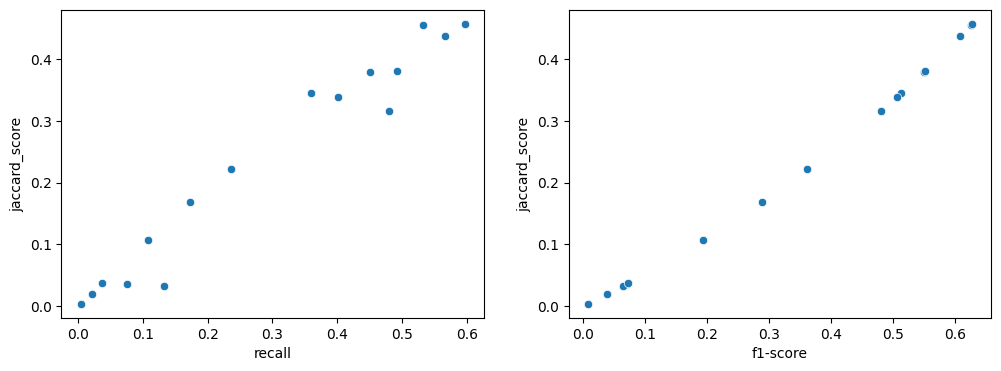

In [221]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.scatterplot(x=synth_perf_models.T['recall'], y=synth_perf_models.T['jaccard_score'], ax=ax[0])
sns.scatterplot(x=synth_perf_models.T['f1-score'], y=synth_perf_models.T['jaccard_score'], ax=ax[1]);

In [8]:
synth_perf_models_to_plot = synth_perf_models.T[['precision', 'recall', 'f1-score', 'nb_null_labels']].copy()
synth_perf_models_to_plot['model'] = pd.Series(synth_perf_models_to_plot.index, index=synth_perf_models_to_plot.index).apply(lambda x: x.split('_')[0])
synth_perf_models_to_plot['feat_extract'] = pd.Series(synth_perf_models_to_plot.index, index=synth_perf_models_to_plot.index).apply(lambda x: x.split('_')[1])

synth_perf_models_to_plot

precision    recall  f1-score  nb_null_labels  \
RandomForest_tfidf          0.890172  0.359883  0.512548            20.0   
KNeighboors_tfidf           0.805461  0.235887  0.361296            10.0   
PassiveAggressive_tfidf     0.658527  0.566346  0.608772             0.0   
MultinomialNB_tfidf         0.685535  0.400963  0.505941            12.0   
RandomForest_doc2vec        0.657943  0.003620  0.007199            98.0   
KNeighboors_doc2vec         0.259680  0.020882  0.038656            76.0   
PassiveAggressive_doc2vec   0.068188  0.075413  0.069961            39.0   
MultinomialNB_doc2vec       0.041696  0.132043  0.063360            39.0   
RandomForest_bert           0.906772  0.107882  0.192814            73.0   
KNeighboors_bert            0.758928  0.533143  0.626306             7.0   
PassiveAggressive_bert      0.661824  0.597273  0.627694             1.0   
MultinomialNB_bert          0.897022  0.037218  0.071469            96.0   
RandomForest_use            0.868497  0.173210  0.288813            56.0   
KNeighboors_use             0.707821  0.450062  0.550240             5.0   
PassiveAggressive_use       0.628918  0.491783  0.551462             0.0   
MultinomialNB_use           0.480317  0.479923  0.480099             1.0   

                                       model feat_extract  
RandomForest_tfidf              RandomForest        tfidf  
KNeighboors_tfidf                KNeighboors        tfidf  
PassiveAggressive_tfidf    PassiveAggressive        tfidf  
MultinomialNB_tfidf            MultinomialNB        tfidf  
RandomForest_doc2vec            RandomForest      doc2vec  
KNeighboors_doc2vec              KNeighboors      doc2vec  
PassiveAggressive_doc2vec  PassiveAggressive      doc2vec  
MultinomialNB_doc2vec          MultinomialNB      doc2vec  
RandomForest_bert               RandomForest         bert  
KNeighboors_bert                 KNeighboors         bert  
PassiveAggressive_bert     PassiveAggressive         bert  
MultinomialNB_bert             MultinomialNB         bert  
RandomForest_use                RandomForest          use  
KNeighboors_use                  KNeighboors          use  
PassiveAggressive_use      PassiveAggressive          use  
MultinomialNB_use              MultinomialNB          use

In [107]:
from sklearn.preprocessing import OrdinalEncoder

title = "Visualisation des modèles selon leur précision, rappel et nombre de labels non classés "

df = synth_perf_models_to_plot.copy()

fig = px.scatter_3d(df, x='precision', y='recall', z='nb_null_labels', opacity=0.8, color='f1-score',
                     symbol=OrdinalEncoder().fit_transform(pd.DataFrame(df['model'])).ravel(),
                     size=OrdinalEncoder().fit_transform(pd.DataFrame(df['feat_extract'])).ravel(),
                    title=title)

fig.update_layout(legend=dict(
    orientation="h",
    entrywidth=70,
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

fig.show()

**Légende**

   - **losange** : KNeighbors
   - **croix** : MultinomialNB
   - **carré** : Passive_Aggressive
   - **rond** : RandomForest
   

Les coordonnées de notre modèle idéal dans cet espace 3D sont **(1,1,0)**.

Nous pouvons donc mesurer la distance de chacun de nos modèles avec ces coordonnées, et le modèle le plus proche sera le modèle optimal selon nos critères :

In [71]:
synth_perf_models_to_plot['dist_to_perfection'] = synth_perf_models_to_plot.apply(lambda x: np.linalg.norm((1-x['precision'], 1-x['recall'], x['nb_null_labels'])), axis=1)
synth_perf_models_to_plot.sort_values('dist_to_perfection')

precision    recall  f1-score  nb_null_labels  \
PassiveAggressive_tfidf     0.658527  0.566346  0.608772             0.0   
PassiveAggressive_use       0.628918  0.491783  0.551462             0.0   
PassiveAggressive_bert      0.661824  0.597273  0.627694             1.0   
MultinomialNB_use           0.480317  0.479923  0.480099             1.0   
KNeighboors_use             0.707821  0.450062  0.550240             5.0   
KNeighboors_bert            0.758928  0.533143  0.626306             7.0   
KNeighboors_tfidf           0.805461  0.235887  0.361296            10.0   
MultinomialNB_tfidf         0.685535  0.400963  0.505941            12.0   
RandomForest_tfidf          0.890172  0.359883  0.512548            20.0   
MultinomialNB_doc2vec       0.041696  0.132043  0.063360            39.0   
PassiveAggressive_doc2vec   0.068188  0.075413  0.069961            39.0   
RandomForest_use            0.868497  0.173210  0.288813            56.0   
RandomForest_bert           0.906772  0.107882  0.192814            73.0   
KNeighboors_doc2vec         0.259680  0.020882  0.038656            76.0   
MultinomialNB_bert          0.897022  0.037218  0.071469            96.0   
RandomForest_doc2vec        0.657943  0.003620  0.007199            98.0   

                                       model feat_extract  dist_to_perfection  
PassiveAggressive_tfidf    PassiveAggressive        tfidf            0.551960  
PassiveAggressive_use      PassiveAggressive          use            0.629275  
PassiveAggressive_bert     PassiveAggressive         bert            1.129846  
MultinomialNB_use              MultinomialNB          use            1.241189  
KNeighboors_use                  KNeighboors          use            5.038631  
KNeighboors_bert                 KNeighboors         bert            7.019692  
KNeighboors_tfidf                KNeighboors        tfidf           10.031038  
MultinomialNB_tfidf            MultinomialNB        tfidf           12.019057  
RandomForest_tfidf              RandomForest        tfidf           20.010543  
MultinomialNB_doc2vec          MultinomialNB      doc2vec           39.021426  
PassiveAggressive_doc2vec  PassiveAggressive      doc2vec           39.022085  
RandomForest_use                RandomForest          use           56.006257  
RandomForest_bert               RandomForest         bert           73.005511  
KNeighboors_doc2vec              KNeighboors      doc2vec           76.009912  
MultinomialNB_bert             MultinomialNB         bert           96.004883  
RandomForest_doc2vec            RandomForest      doc2vec           98.005662

Pour notre problématique nous cherchons à évaluer nos modèles en répondant à 2 questions :

   1. *Les tags proposés sont ils pertinents ?* : <u>**Precision**</u>
   

   2. *Combien de tags parmi ceux qui sont pertinents sont proposés ?* : <u>**Recall**</u>
   
La réponse à la première question est fournie par le modèle **RandomForest** et la réponse à la seconde par le modèle **PassiveAggressive**.


### Méthodes  d'ensemble

Il serait intéressant de combiner nos modèles en espérant qu'ils compensent leurs faiblesses et forment des modèles plus perofrmants.

In [60]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain

In [ ]:
estimators_stacking = [
    ('kn_clf', kn_clf),
    ('pass_agg_clf', PassiveAggressiveClassifier(n_jobs=-1, random_state=SEED))
]

estimators_voting = [
    ('kn_clf', kn_clf),
    ('rf_clf', rf_clf),
]

In [ ]:
stacking_clf = OneVsRestClassifier(StackingClassifier(estimators=estimators_stacking, 
                                                      final_estimator=LogisticRegression(random_state=SEED, n_jobs=-1),
                                                      stack_method='predict',
                                                      cv=2,
                                                      verbose=7,
                                                      n_jobs=-1
                                                     ), n_jobs=1, verbose=7)

In [ ]:
voting_clf = OneVsRestClassifier(VotingClassifier(estimators=estimators_voting,
                                                  n_jobs=-1,
                                                  verbose=7,
                                                  voting='soft'), n_jobs=1, verbose=7)

In [90]:
bagging_pass_agg_clf = OneVsRestClassifier(BaggingClassifier(estimator=PassiveAggressiveClassifier(n_jobs=-1, random_state=SEED), 
                                                             max_features= 0.7,
                                                             max_samples=0.7,
                                                             n_jobs=-1,
                                                             verbose=5,
                                                             random_state=SEED
                                                            ), n_jobs=1, verbose=7)

bagging_kn_clf = OneVsRestClassifier(BaggingClassifier(estimator=kn_clf, 
                                                         max_features= 0.7,
                                                         max_samples=0.7,
                                                         n_jobs=-1,
                                                         verbose=5,
                                                         random_state=SEED
                                                        ), n_jobs=1, verbose=7)

In [88]:
chain_pass_agg_clf = ClassifierChain(PassiveAggressiveClassifier(n_jobs=-1, random_state=SEED), random_state=SEED, verbose=5
)

chain_kn_clf = ClassifierChain(kn_clf, random_state=SEED, verbose=5
)

In [143]:
# cross_val_models(X_train_bert, 'dict_eval_bert_ensembles')

Début de l'entraînement du modèle stack_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 90.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


		Durée de l'entraînement n°1 : 5447.86secondes



[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Paral

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 89.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


		Durée de l'entraînement n°2 : 5364.45secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Usi

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle voting_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   56.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 27.9min finished


		Durée de l'entraînement n°1 : 1676.73secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 28.4min finished


		Durée de l'entraînement n°2 : 1701.87secondes



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_bert_ensembles'.


In [59]:
display_results(dict_eval_bert_ensembles)

stack_clf

Durée moyenne d'entraînement : 5406.16 secondes.

Nombre de labels non-classés : 31.

Moyenne des supports des labels non-classés : 124.16.


python   javascript      reactjs        java           r  \
precision         0.804881     0.583707     0.791328    0.545748    0.635909   
recall            0.792836     0.503432     0.550410    0.525731    0.802269   
f1-score          0.798810     0.369893     0.643247    0.517090    0.679864   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.665039     0.235957     0.475173    0.348733    0.521375   

                    pandas         html      android          c#       google  \
precision         0.852078     0.556740     0.754260    0.216758     0.780394   
recall            0.807579     0.630634     0.738034    0.222846     0.599459   
f1-score          0.822942     0.586448     0.745972    0.219760     0.675108   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.699325     0.414975     0.594917    0.140828     0.509729   

               ...  http   bootstrap    mongoose  date  multithreading  \
precision      ...   0.0    0.304762    0.823385   0.0             0.0   
recall         ...   0.0    0.268908    0.559374   0.0             0.0   
f1-score       ...   0.0    0.285714    0.664460   0.0             0.0   
support        ...  42.5  119.000000  155.500000  78.0            52.0   
jaccard_score  ...   0.0    0.200000    0.497542   0.0             0.0   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.400000      0.700570      0.497175      0.655919   
recall          0.347826      0.537612      0.396336      0.537612   
f1-score        0.372093      0.605819      0.420038      0.552956   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.296296      0.434556      0.327008      0.430651   

                samples avg  
precision          0.631054  
recall             0.574009  
f1-score           0.566470  
support        39363.000000  
jaccard_score      0.484862  

[5 rows x 104 columns]



voting_clf

Durée moyenne d'entraînement : 1689.3 secondes.

Nombre de labels non-classés : 16.

Moyenne des supports des labels non-classés : 78.16.


python   javascript      reactjs        java           r  \
precision         0.847895     0.723218     0.862421    0.809942    0.955115   
recall            0.744587     0.313464     0.467732    0.116375    0.463234   
f1-score          0.792757     0.437307     0.606287    0.202509    0.623854   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.656669     0.279847     0.435069    0.112962    0.453362   

                    pandas         html      android          c#       google  \
precision         0.875922     0.742416     0.937616    0.842885     0.919350   
recall            0.817129     0.332477     0.470006    0.050754     0.330703   
f1-score          0.845405     0.459242     0.626103    0.095156     0.486151   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.732209     0.298076     0.455753    0.050101     0.321456   

               ...  http   bootstrap    mongoose  date  multithreading  \
precision      ...   0.0    0.833333    0.852815   0.0        0.888889   
recall         ...   0.0    0.029412    0.223611   0.0        0.072917   
f1-score       ...   0.0    0.056590    0.354167   0.0        0.128100   
support        ...  42.5  119.000000  155.500000  78.0       52.000000   
jaccard_score  ...   0.0    0.029134    0.215385   0.0        0.070761   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.973684      0.864788      0.708496      0.814331   
recall          0.197042      0.381133      0.234028      0.381133   
f1-score        0.327392      0.529059      0.312043      0.477135   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.195840      0.359681      0.223873      0.355692   

                samples avg  
precision          0.546548  
recall             0.407351  
f1-score           0.444375  
support        39363.000000  
jaccard_score      0.387856  

[5 rows x 104 columns]

In [73]:
load_pickle('dict_eval_stacking_voting')

Fichier enregistré sous le nom 'dict_eval_stacking_voting' 


In [135]:
load_pickle('dict_eval_bert_all_models')

Fichier enregistré sous le nom 'dict_eval_bert_all_models' 


In [91]:
models_to_train = {'bagging_pass_agg_clf':bagging_pass_agg_clf,
                   'bagging_kn_clf':bagging_kn_clf,
                   'chain_pass_agg_clf':chain_pass_agg_clf,
                   'chain_kn_clf':chain_kn_clf
                  }

In [96]:
# cross_val_models(X_train_bert, 'dict_eval_bagging_chain')

Début de l'entraînement du modèle bagging_pass_agg_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

		Durée de l'entraînement n°1 : 94.01secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Para

		Durée de l'entraînement n°2 : 93.94secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle bagging_kn_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.7s remaining:    1.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.0s
[Para

		Durée de l'entraînement n°1 : 83.5secondes



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.0s remaining:   20.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.1s remaining:    7.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   11.9s remaining:   19.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   11.9s remaining:    7.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.0s remaining:   20.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.1s remaining:    7.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.5s remaining:   20.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.6s remaining:    7.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   18.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   17.5s remaining:   29.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   18.0s remaining:   10.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   29.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   18.0s remaining:   30.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   18.9s remaining:   11.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   24.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   13.1s remaining:   21.9s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   13.1s remaining:   21.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   13.1s remaining:    7.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   18.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.4s remaining:   20.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.6s remaining:    7.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.4s remaining:   20.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.5s remaining:    7.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.3s remaining:   20.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.3s remaining:   20.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.4s remaining:    7.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.3s remaining:   20.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.3s remaining:    7.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.3s remaining:   20.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.3s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.2s remaining:   20.4s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Para

		Durée de l'entraînement n°2 : 165.48secondes



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.0s remaining:   20.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.2s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.2s remaining:   20.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.2s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.3s remaining:   20.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.3s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.1s remaining:   20.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.2s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.3s remaining:   20.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   13.3s remaining:    7.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   18.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.3s remaining:   20.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.3s remaining:    7.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.3s remaining:   20.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.2s remaining:   20.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.3s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.2s remaining:   20.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.3s remaining:    7.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.1s remaining:   20.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.2s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.2s remaining:   20.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.2s remaining:   20.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.3s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.2s remaining:   20.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.3s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.2s remaining:   20.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.2s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   17.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.1s remaining:   20.2s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle chain_pass_agg_clf..

	Passe n°1 de la validation croisée



C:\Users\jkomb\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\_param_validation.py:541: FutureWarning:

Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.



[Chain] ................. (1 of 100) Processing order 0, total=   0.3s
[Chain] ................. (2 of 100) Processing order 1, total=   0.2s
[Chain] ................. (3 of 100) Processing order 2, total=   0.3s
[Chain] ................. (4 of 100) Processing order 3, total=   0.2s
[Chain] ................. (5 of 100) Processing order 4, total=   0.3s
[Chain] ................. (6 of 100) Processing order 5, total=   0.3s
[Chain] ................. (7 of 100) Processing order 6, total=   0.2s
[Chain] ................. (8 of 100) Processing order 7, total=   0.3s
[Chain] ................. (9 of 100) Processing order 8, total=   0.3s
[Chain] ................ (10 of 100) Processing order 9, total=   0.3s
[Chain] ............... (11 of 100) Processing order 10, total=   0.4s
[Chain] ............... (12 of 100) Processing order 11, total=   0.2s
[Chain] ............... (13 of 100) Processing order 12, total=   0.4s
[Chain] ............... (14 of 100) Processing order 13, total=   0.5s
[Chain

C:\Users\jkomb\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\_param_validation.py:541: FutureWarning:

Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.



[Chain] ................. (1 of 100) Processing order 0, total=   0.4s
[Chain] ................. (2 of 100) Processing order 1, total=   0.4s
[Chain] ................. (3 of 100) Processing order 2, total=   0.3s
[Chain] ................. (4 of 100) Processing order 3, total=   0.3s
[Chain] ................. (5 of 100) Processing order 4, total=   0.3s
[Chain] ................. (6 of 100) Processing order 5, total=   0.3s
[Chain] ................. (7 of 100) Processing order 6, total=   0.4s
[Chain] ................. (8 of 100) Processing order 7, total=   0.4s
[Chain] ................. (9 of 100) Processing order 8, total=   0.3s
[Chain] ................ (10 of 100) Processing order 9, total=   0.5s
[Chain] ............... (11 of 100) Processing order 10, total=   0.2s
[Chain] ............... (12 of 100) Processing order 11, total=   0.4s
[Chain] ............... (13 of 100) Processing order 12, total=   0.3s
[Chain] ............... (14 of 100) Processing order 13, total=   0.3s
[Chain

C:\Users\jkomb\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\_param_validation.py:541: FutureWarning:

Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.



[Chain] ................. (5 of 100) Processing order 4, total=   0.0s
[Chain] ................. (6 of 100) Processing order 5, total=   0.0s
[Chain] ................. (7 of 100) Processing order 6, total=   0.0s
[Chain] ................. (8 of 100) Processing order 7, total=   0.0s
[Chain] ................. (9 of 100) Processing order 8, total=   0.0s
[Chain] ................ (10 of 100) Processing order 9, total=   0.0s
[Chain] ............... (11 of 100) Processing order 10, total=   0.0s
[Chain] ............... (12 of 100) Processing order 11, total=   0.0s
[Chain] ............... (13 of 100) Processing order 12, total=   0.0s
[Chain] ............... (14 of 100) Processing order 13, total=   0.0s
[Chain] ............... (15 of 100) Processing order 14, total=   0.0s
[Chain] ............... (16 of 100) Processing order 15, total=   0.0s
[Chain] ............... (17 of 100) Processing order 16, total=   0.0s
[Chain] ............... (18 of 100) Processing order 17, total=   0.0s
[Chain

C:\Users\jkomb\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\_param_validation.py:541: FutureWarning:

Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.



[Chain] ................. (1 of 100) Processing order 0, total=   0.0s
[Chain] ................. (2 of 100) Processing order 1, total=   0.0s
[Chain] ................. (3 of 100) Processing order 2, total=   0.0s
[Chain] ................. (4 of 100) Processing order 3, total=   0.0s
[Chain] ................. (5 of 100) Processing order 4, total=   0.0s
[Chain] ................. (6 of 100) Processing order 5, total=   0.0s
[Chain] ................. (7 of 100) Processing order 6, total=   0.0s
[Chain] ................. (8 of 100) Processing order 7, total=   0.0s
[Chain] ................. (9 of 100) Processing order 8, total=   0.0s
[Chain] ................ (10 of 100) Processing order 9, total=   0.0s
[Chain] ............... (11 of 100) Processing order 10, total=   0.0s
[Chain] ............... (12 of 100) Processing order 11, total=   0.0s
[Chain] ............... (13 of 100) Processing order 12, total=   0.0s
[Chain] ............... (14 of 100) Processing order 13, total=   0.0s
[Chain

In [97]:
display_results(dict_eval_bagging_chain)

bagging_pass_agg_clf

Durée moyenne d'entraînement : 93.98 secondes.

Nombre de labels non-classés : 5.

Moyenne des supports des labels non-classés : 78.4.


python   javascript      reactjs        java           r  \
precision         0.858389     0.637419     0.784810    0.706684    0.850845   
recall            0.748973     0.514835     0.606350    0.378345    0.714584   
f1-score          0.799923     0.566166     0.678870    0.492801    0.776504   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.666562     0.395290     0.514177    0.327037    0.634696   

                    pandas         html      android          c#       google  \
precision         0.889311     0.695997     0.873554    0.678065     0.815157   
recall            0.814220     0.495932     0.667303    0.210451     0.599511   
f1-score          0.849975     0.575726     0.756535    0.320995     0.690510   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.739124     0.404693     0.608488    0.191213     0.527325   

               ...  http   bootstrap    mongoose  date  multithreading  \
precision      ...   0.0    0.754080    0.755457   0.0        0.707792   
recall         ...   0.0    0.357143    0.615021   0.0        0.418155   
f1-score       ...   0.0    0.484510    0.677896   0.0        0.518367   
support        ...  42.5  119.000000  155.500000  78.0       52.000000   
jaccard_score  ...   0.0    0.319796    0.512908   0.0        0.350518   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.834428      0.796646      0.707340      0.770971   
recall          0.567113      0.567710      0.456607      0.567710   
f1-score        0.675269      0.662966      0.532976      0.641004   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.509804      0.495848      0.408129      0.500538   

                samples avg  
precision          0.685570  
recall             0.600933  
f1-score           0.608796  
support        39363.000000  
jaccard_score      0.535597  

[5 rows x 104 columns]



bagging_kn_clf

Durée moyenne d'entraînement : 124.49 secondes.

Nombre de labels non-classés : 9.

Moyenne des supports des labels non-classés : 67.0.


python   javascript      reactjs        java           r  \
precision         0.804155     0.652949     0.796112    0.679425    0.916326   
recall            0.802216     0.409925     0.573740    0.230426    0.560378   
f1-score          0.803117     0.503611     0.666632    0.341962    0.695354   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.671008     0.336574     0.499990    0.206539    0.533114   

                    pandas         html      android          c#       google  \
precision         0.834543     0.674535     0.892040    0.771779     0.862780   
recall            0.868295     0.471496     0.579369    0.140637     0.471580   
f1-score          0.851058     0.554981     0.702470    0.237178     0.609812   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.740752     0.384065     0.541391    0.134561     0.438826   

               ...  http   bootstrap    mongoose       date  multithreading  \
precision      ...   0.0    0.687500    0.743753   0.700000        0.766071   
recall         ...   0.0    0.092437    0.432772   0.019408        0.351190   
f1-score       ...   0.0    0.162963    0.544649   0.037037        0.471497   
support        ...  42.5  119.000000  155.500000  78.000000       52.000000   
jaccard_score  ...   0.0    0.088780    0.374795   0.018908        0.309118   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.816515      0.798714      0.707746      0.771955   
recall          0.472826      0.496160      0.353835      0.496160   
f1-score        0.597923      0.612082      0.434432      0.575758   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.426649      0.441010      0.320926      0.439270   

                samples avg  
precision          0.636140  
recall             0.525935  
f1-score           0.547827  
support        39363.000000  
jaccard_score      0.481237  

[5 rows x 104 columns]



chain_pass_agg_clf

Durée moyenne d'entraînement : 31.33 secondes.

Nombre de labels non-classés : 0.

Moyenne des supports des labels non-classés : NC.


python   javascript      reactjs        java           r  \
precision         0.804881     0.637757     0.657608    0.603840    0.781833   
recall            0.792836     0.470698     0.683576    0.448122    0.664960   
f1-score          0.798810     0.340128     0.670040    0.497165    0.718413   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.665039     0.220701     0.503884    0.331486    0.560600   

                    pandas         html      android          c#       google  \
precision         0.893426     0.758414     0.671925    0.511921     0.794364   
recall            0.733756     0.280171     0.742069    0.259950     0.586528   
f1-score          0.801096     0.392981     0.685525    0.344809     0.674774   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.670540     0.250600     0.525070    0.208333     0.509269   

               ...       http   bootstrap    mongoose       date  \
precision      ...   0.205128    0.375526    0.578777   0.124430   
recall         ...   0.062899    0.546218    0.709014   0.101645   
f1-score       ...   0.082512    0.438486    0.633072   0.102866   
support        ...  42.500000  119.000000  155.500000  78.000000   
jaccard_score  ...   0.043045    0.280864    0.463171   0.054258   

               multithreading    webpack     micro avg     macro avg  \
precision            0.514151   0.771062      0.611020      0.576197   
recall               0.604167   0.549671      0.578484      0.484234   
f1-score             0.555006   0.641595      0.594307      0.499141   
support             52.000000  89.000000  39363.000000  39363.000000   
jaccard_score        0.384089   0.472664      0.422786      0.367081   

               weighted avg   samples avg  
precision          0.674645      0.603869  
recall             0.578484      0.611380  
f1-score           0.585139      0.574222  
support        39363.000000  39363.000000  
jaccard_score      0.444578      0.490314  

[5 rows x 104 columns]



chain_kn_clf

Durée moyenne d'entraînement : 3.24 secondes.

Nombre de labels non-classés : 6.

Moyenne des supports des labels non-classés : 68.17.


python   javascript      reactjs        java           r  \
precision         0.788071     0.595544     0.761684    0.610338    0.821006   
recall            0.803810     0.466195     0.572148    0.317767    0.665728   
f1-score          0.795819     0.522965     0.653297    0.416143    0.735165   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.660882     0.354106     0.485109    0.262807    0.581256   

                    pandas         html      android          c#       google  \
precision         0.797428     0.601548     0.812513    0.611920     0.792914   
recall            0.878441     0.555926     0.610658    0.265710     0.540136   
f1-score          0.835943     0.577797     0.697137    0.369143     0.642517   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.718135     0.406283     0.535092    0.226385     0.473352   

               ...       http   bootstrap    mongoose       date  \
precision      ...   0.090909    0.491962    0.607331   0.090909   
recall         ...   0.037037    0.189076    0.471161   0.012500   
f1-score       ...   0.052632    0.273141    0.528330   0.021978   
support        ...  42.500000  119.000000  155.500000  78.000000   
jaccard_score  ...   0.027778    0.159988    0.360623   0.011236   

               multithreading    webpack     micro avg     macro avg  \
precision            0.734848   0.265152      0.667264      0.526407   
recall               0.382440   0.367290      0.557352      0.431244   
f1-score             0.501284   0.306980      0.607375      0.452279   
support             52.000000  89.000000  39363.000000  39363.000000   
jaccard_score        0.334620   0.181755      0.436137      0.327168   

               weighted avg   samples avg  
precision          0.651305      0.672188  
recall             0.557352      0.595089  
f1-score           0.587699      0.601747  
support        39363.000000  39363.000000  
jaccard_score      0.442533      0.528555  

[5 rows x 104 columns]

In [105]:
save_pickle(dict_eval_bagging_chain, 'dict_eval_bagging_chain')

Fichier enregistré sous le nom 'dict_eval_bagging_chain' 


In [101]:
dict_eval_ens_list = {
                    'dict_eval_tfidf':dict_eval_tfidf,
                    'dict_eval_doc2vec':dict_eval_doc2vec,
                    'dict_eval_bert':dict_eval_bert,
                    'dict_eval_use':dict_eval_use,
                    'dict_eval_stacking_voting':dict_eval_stacking_voting,
                    'dict_eval_bagging_chain':dict_eval_bagging_chain
}

synth_perf_models_ens = pd.DataFrame(index=['precision', 'recall', 'f1-score', 'support',
                                        'jaccard_score', 'nb_null_labels', 'fit_duration'])

for dict_name, dict_eval in dict_eval_ens_list.items():
    
    ft_extract_name = dict_name.split('dict_eval_')[1]
    
    for mdl_name in dict_eval.keys():
        
        col_name = mdl_name + '_' + ft_extract_name
        synth_perf_models_ens[col_name] = 0
        
        synth_perf_models_ens.loc[['precision', 'recall', 'f1-score', 'support', 'jaccard_score'], 
                              col_name] = dict_eval[mdl_name]['avg_class_report']['micro avg']
        
        tmp_df = dict_eval[mdl_name]['avg_class_report'].drop(index=['support'])
        nb_null_supports = tmp_df.loc[:, tmp_df.mean()==0.0].shape[1]
        synth_perf_models_ens.loc['nb_null_labels', col_name] = nb_null_supports
        
        tmp_df = dict_eval[mdl_name]['avg_class_report'].loc['support', tmp_df.loc[:, tmp_df.mean()==0.0].columns]
        mean_null_supports = round(tmp_df.mean(),2) if not np.isnan(tmp_df.mean()) else 0
        synth_perf_models_ens.loc['mean_null_supports', col_name] = mean_null_supports
        
        synth_perf_models_ens.loc['fit_duration', col_name] = dict_eval[mdl_name]['training_duration']

synth_perf_models_ens.drop(index=['support'], inplace=True)

In [104]:
synth_perf_models_ens.style.background_gradient(cmap=cm, axis=1)

La méthode d'ensemble **Bagging** appliquée à notre modèle **Passive_aggressive** donne de bons résultats, et le meilleur **score f1** jusque là avec une durée d'entraînement relativement faible.

Plus généralement, nos modèles ensemblistes performent mieux que nos modèles simples, en particulier les modèles de **Bagging** et de **ClassifierChain**.

## Choix de feature extraction et sélection des modèles prometteurs

Au vu des résultats précédents, nous allons retenir la méthode de feeature extraction **BERT** et nous allons poursuivre notre démarche avec seulement les modèles suivants :

   - PassiveAggressive
   - Bagging PassiveAggressive
   - KNeighbors
   - Bagging KNeighbors

In [136]:
models_to_train = {'KNeighboors':kn_clf,
                   'PassiveAggressive':pass_agg_clf,
                   'bagging_pass_agg_clf':bagging_pass_agg_clf,
                   'bagging_kn_clf':bagging_kn_clf
                  }

## Réduction de dimensions

Maintenant que nous avons une idée de la performance que nos modèles peuvent atteindre sur les jeu de données vectorisés, nous allons essayer 2 méthodes de réduction de dimensions :

   1. **Analyse en Composantes Principales**
   2. **Projection Aléatoire**
   
### Analyse en composantes principales

In [160]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=0.9, random_state=SEED))

X_train_bert_pca = pca_pipe.fit_transform(X_train_bert)

np.shape(X_train_bert_pca)

(40000, 178)

In [161]:
pca = pca_pipe.steps[1][1]

In [139]:
X_train_bert.shape[1]

384

In [140]:
1-(384-120)/384

0.3125

In [162]:
cross_val_models(X_train_bert_pca, 'dict_eval_pca_09')

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 0.12secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 0.1secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


		Durée de l'entraînement n°1 : 7.05secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


		Durée de l'entraînement n°2 : 3.14secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle bagging_pass_agg_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Para

		Durée de l'entraînement n°1 : 55.72secondes



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

		Durée de l'entraînement n°2 : 60.23secondes



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle bagging_kn_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Para

		Durée de l'entraînement n°1 : 38.04secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    7.7s remaining:   12.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.9s remaining:    4.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   11.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.4s remaining:   10.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.5s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.4s remaining:   10.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.5s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.8s remaining:   11.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.5s remaining:   10.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.6s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   11.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.7s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.9s remaining:   11.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.1s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.5s remaining:   11.0s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.6s remaining:   11.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.6s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.6s remaining:   11.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.7s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.5s remaining:   10.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.7s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.3s remaining:   10.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   11.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.7s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   11.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.7s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.6s remaining:   11.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.6s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   11.2s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Para

		Durée de l'entraînement n°2 : 47.76secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.6s remaining:   11.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.7s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.3s remaining:   10.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.5s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.5s remaining:   10.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.5s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.6s remaining:   11.0s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.4s remaining:   10.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.5s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.8s remaining:   11.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.8s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.6s remaining:   11.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.7s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.5s remaining:   11.0s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   11.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.7s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   11.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.8s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.8s remaining:   11.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.8s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   11.2s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    7.0s remaining:   11.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.0s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   11.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.8s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.8s remaining:   11.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.0s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    9.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.5s remaining:   10.8s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_pca_09'.


In [163]:
display_results(dict_eval_pca_09)

KNeighboors

Durée moyenne d'entraînement : 0.11 secondes.

Nombre de labels non-classés : 7.

Moyenne des supports des labels non-classés : 64.5.


python   javascript      reactjs        java           r  \
precision         0.792852     0.610940     0.747269    0.648555    0.864383   
recall            0.798297     0.441071     0.581964    0.277296    0.605510   
f1-score          0.795518     0.512217     0.653878    0.386727    0.712079   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.660473     0.344337     0.485780    0.239945    0.552895   

                    pandas         html      android          c#       google  \
precision         0.822470     0.636082     0.843842    0.721569     0.811020   
recall            0.857938     0.515094     0.611960    0.211282     0.520070   
f1-score          0.839776     0.569228     0.709424    0.326473     0.633742   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.723807     0.397848     0.549787    0.195081     0.463881   

               ...  http   bootstrap    mongoose       date  multithreading  \
precision      ...   0.0    0.673160    0.673305   0.250000        0.674242   
recall         ...   0.0    0.155462    0.466030   0.031908        0.424107   
f1-score       ...   0.0    0.250752    0.548824   0.056589        0.511315   
support        ...  42.5  119.000000  155.500000  78.000000       52.000000   
jaccard_score  ...   0.0    0.144931    0.378203   0.029146        0.347631   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.717593      0.757521      0.663708      0.731045   
recall          0.508089      0.521833      0.385075      0.521833   
f1-score        0.590428      0.617960      0.458817      0.589327   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.420161      0.447139      0.338211      0.448462   

                samples avg  
precision          0.646197  
recall             0.551828  
f1-score           0.566043  
support        39363.000000  
jaccard_score      0.495922  

[5 rows x 104 columns]



PassiveAggressive

Durée moyenne d'entraînement : 5.1 secondes.

Nombre de labels non-classés : 1.

Moyenne des supports des labels non-classés : 42.5.


python   javascript      reactjs        java           r  \
precision         0.739836     0.485433     0.586564    0.558489    0.686498   
recall            0.757347     0.486841     0.390576    0.316069    0.685376   
f1-score          0.748344     0.485618     0.468094    0.403439    0.682583   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.598365     0.320814     0.306615    0.253533    0.518693   

                    pandas         html      android          c#       google  \
precision         0.729362     0.502118     0.673605    0.304218     0.486661   
recall            0.791758     0.475999     0.666001    0.335014     0.620368   
f1-score          0.757741     0.488121     0.668144    0.315242     0.544392   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.609980     0.323067     0.502415    0.187116     0.374036   

               ...  http   bootstrap    mongoose       date  multithreading  \
precision      ...   0.0    0.369543    0.647714   0.128929        0.553439   
recall         ...   0.0    0.445378    0.399263   0.179276        0.327381   
f1-score       ...   0.0    0.390917    0.489436   0.149986        0.411136   
support        ...  42.5  119.000000  155.500000  78.000000       52.000000   
jaccard_score  ...   0.0    0.243513    0.329743   0.081092        0.258881   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.601340      0.582500      0.531051      0.590765   
recall          0.735844      0.555817      0.467020      0.555817   
f1-score        0.659649      0.568799      0.482649      0.564581   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.493831      0.397428      0.350507      0.416960   

                samples avg  
precision          0.555507  
recall             0.583728  
f1-score           0.531588  
support        39363.000000  
jaccard_score      0.442072  

[5 rows x 104 columns]



bagging_pass_agg_clf

Durée moyenne d'entraînement : 57.97 secondes.

Nombre de labels non-classés : 7.

Moyenne des supports des labels non-classés : 69.79.


python   javascript      reactjs        java           r  \
precision         0.866424     0.644810     0.839156    0.737774    0.902325   
recall            0.690553     0.373316     0.478798    0.309005    0.597399   
f1-score          0.768508     0.472624     0.609712    0.433717    0.718791   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.624049     0.309862     0.438551    0.277020    0.561039   

                    pandas         html      android          c#       google  \
precision         0.914899     0.698703     0.891612    0.643202     0.870333   
recall            0.762146     0.451165     0.560315    0.116631     0.373333   
f1-score          0.831112     0.548287     0.688110    0.193037     0.522503   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.711063     0.377840     0.524536    0.108458     0.353671   

               ...  http   bootstrap    mongoose  date  multithreading  \
precision      ...   0.0    0.694454    0.799160   0.0        0.708824   
recall         ...   0.0    0.310924    0.520943   0.0        0.312500   
f1-score       ...   0.0    0.427979    0.630275   0.0        0.423810   
support        ...  42.5  119.000000  155.500000  78.0       52.000000   
jaccard_score  ...   0.0    0.272264    0.460472   0.0        0.269821   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.820381      0.821217      0.709657      0.782459   
recall          0.538802      0.490298      0.397667      0.490298   
f1-score        0.650318      0.613988      0.484914      0.586227   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.481948      0.442996      0.364010      0.446033   

                samples avg  
precision          0.637110  
recall             0.522543  
f1-score           0.544734  
support        39363.000000  
jaccard_score      0.476818  

[5 rows x 104 columns]



bagging_kn_clf

Durée moyenne d'entraînement : 42.9 secondes.

Nombre de labels non-classés : 11.

Moyenne des supports des labels non-classés : 73.32.


python   javascript      reactjs        java           r  \
precision         0.814024     0.675954     0.822579    0.710781    0.922798   
recall            0.795823     0.366703     0.525254    0.175622    0.544781   
f1-score          0.804753     0.475248     0.641051    0.280729    0.685101   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.673308     0.311786     0.471784    0.163419    0.521037   

                    pandas         html      android          c#       google  \
precision         0.838662     0.688159     0.902690    0.818973     0.881138   
recall            0.863873     0.446636     0.536240    0.116717     0.415553   
f1-score          0.850976     0.541694     0.672794    0.204050     0.564673   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.740633     0.371480     0.506928    0.113629     0.393438   

               ...  http   bootstrap    mongoose       date  multithreading  \
precision      ...   0.0    0.757353    0.764671   0.125000        0.722917   
recall         ...   0.0    0.092437    0.435704   0.006579        0.305060   
f1-score       ...   0.0    0.164291    0.548868   0.012500        0.424055   
support        ...  42.5  119.000000  155.500000  78.000000       52.000000   
jaccard_score  ...   0.0    0.089731    0.379674   0.006329        0.269242   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.771782      0.814075      0.694088      0.778893   
recall          0.439459      0.463395      0.322264      0.463395   
f1-score        0.559513      0.590599      0.403008      0.548807   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.389225      0.419043      0.295650      0.416080   

                samples avg  
precision          0.605727  
recall             0.490230  
f1-score           0.515450  
support        39363.000000  
jaccard_score      0.452164  

[5 rows x 104 columns]

In [143]:
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=0.6, random_state=SEED))

X_train_bert_pca = pca_pipe.fit_transform(X_train_bert)

np.shape(X_train_bert_pca)

(40000, 58)

In [144]:
cross_val_models(X_train_bert_pca, 'dict_eval_pca_06')

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 0.11secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 0.11secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


		Durée de l'entraînement n°1 : 1.48secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


		Durée de l'entraînement n°2 : 1.47secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle bagging_pass_agg_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:   

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

		Durée de l'entraînement n°1 : 24.16secondes



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_job

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:   

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Para

		Durée de l'entraînement n°2 : 24.27secondes



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_job

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle bagging_kn_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:   

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_job

[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_job

		Durée de l'entraînement n°1 : 20.51secondes



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.3s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.3s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.3s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.3s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.5s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.0s remaining:    6.7s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:   

[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_job

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Para

[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Para

		Durée de l'entraînement n°2 : 20.61secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.3s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.3s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.3s remaining:    5.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.3s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.4s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.2s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.7s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_pca_06'.


In [145]:
display_results(dict_eval_pca_06)

KNeighboors

Durée moyenne d'entraînement : 0.11 secondes.

Nombre de labels non-classés : 6.

Moyenne des supports des labels non-classés : 61.17.


python   javascript      reactjs        java           r  \
precision         0.806793     0.613062     0.747042    0.619236    0.833340   
recall            0.777917     0.430240     0.533991    0.236215    0.607640   
f1-score          0.792089     0.505632     0.622764    0.340536    0.702792   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.655758     0.338359     0.452198    0.205244    0.541779   

                    pandas         html      android          c#       google  \
precision         0.834861     0.627434     0.823676    0.621252     0.780847   
recall            0.849713     0.504135     0.597747    0.176197     0.418479   
f1-score          0.842215     0.559062     0.692753    0.274492     0.544916   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.727436     0.388032     0.530007    0.159099     0.374493   

               ...  http   bootstrap    mongoose       date  multithreading  \
precision      ...   0.0    0.561905    0.572009   0.178571        0.675412   
recall         ...   0.0    0.084034    0.453045   0.025987        0.336310   
f1-score       ...   0.0    0.145736    0.503925   0.044828        0.448882   
support        ...  42.5  119.000000  155.500000  78.000000       52.000000   
jaccard_score  ...   0.0    0.078636    0.337544   0.023055        0.289394   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.668590      0.743071      0.628426      0.704971   
recall          0.423155      0.483978      0.338172      0.483978   
f1-score        0.516933      0.586169      0.405840      0.552491   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.349784      0.414600      0.294161      0.416093   

                samples avg  
precision          0.604795  
recall             0.508754  
f1-score           0.524242  
support        39363.000000  
jaccard_score      0.456555  

[5 rows x 104 columns]



PassiveAggressive

Durée moyenne d'entraînement : 1.48 secondes.

Nombre de labels non-classés : 1.

Moyenne des supports des labels non-classés : 54.0.


python   javascript      reactjs        java           r  \
precision         0.729274     0.465904     0.458351    0.572467    0.640063   
recall            0.741189     0.470360     0.562979    0.233985    0.588097   
f1-score          0.735176     0.463787     0.495696    0.331904    0.610847   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.581384     0.302964     0.329519    0.198974    0.442863   

                    pandas         html      android          c#       google  \
precision         0.806082     0.525999     0.619465    0.275085     0.416288   
recall            0.672374     0.502231     0.498273    0.215649     0.478604   
f1-score          0.719066     0.504552     0.552132    0.202655     0.440270   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.567528     0.340834     0.382042    0.112790     0.282857   

               ...       http   bootstrap    mongoose       date  \
precision      ...   0.166667    0.380526    0.592810   0.148463   
recall         ...   0.037037    0.302521    0.385587   0.192763   
f1-score       ...   0.060606    0.273800    0.465763   0.163591   
support        ...  42.500000  119.000000  155.500000  78.000000   
jaccard_score  ...   0.032258    0.164337    0.305022   0.089152   

               multithreading    webpack     micro avg     macro avg  \
precision            0.566667   0.790640      0.522547      0.450165   
recall               0.171131   0.149014      0.500267      0.376090   
f1-score             0.261404   0.238070      0.511146      0.387039   
support             52.000000  89.000000  39363.000000  39363.000000   
jaccard_score        0.150653   0.139483      0.343330      0.269843   

               weighted avg   samples avg  
precision          0.537635      0.487471  
recall             0.500267      0.521392  
f1-score           0.503958      0.466321  
support        39363.000000  39363.000000  
jaccard_score      0.362339      0.378964  

[5 rows x 104 columns]



bagging_pass_agg_clf

Durée moyenne d'entraînement : 24.22 secondes.

Nombre de labels non-classés : 14.

Moyenne des supports des labels non-classés : 82.36.


python   javascript      reactjs        java           r  \
precision         0.857048     0.684982     0.757380    0.666796    0.902127   
recall            0.670952     0.195012     0.466464    0.276678    0.518035   
f1-score          0.752656     0.302074     0.574869    0.390871    0.658134   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.603407     0.177955     0.403565    0.242993    0.490505   

                    pandas         html      android          c#       google  \
precision         0.852512     0.715683     0.879772    0.635714     0.783213   
recall            0.824867     0.228113     0.492033    0.032524     0.275581   
f1-score          0.838381     0.341074     0.625139    0.060417     0.393680   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.721735     0.207355     0.456467    0.031498     0.249579   

               ...  http   bootstrap    mongoose       date  multithreading  \
precision      ...   0.0    0.650000    0.618248   0.071429        0.738095   
recall         ...   0.0    0.109244    0.343009   0.013158        0.255952   
f1-score       ...   0.0    0.184690    0.439014   0.022222        0.374741   
support        ...  42.5  119.000000  155.500000  78.000000       52.000000   
jaccard_score  ...   0.0    0.104645    0.281243   0.011364        0.234277   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.875000      0.799071      0.622360      0.743951   
recall          0.243175      0.396787      0.276333      0.396787   
f1-score        0.378590      0.530231      0.346289      0.481959   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.235186      0.360758      0.250492      0.358149   

                samples avg  
precision          0.523014  
recall             0.417765  
f1-score           0.439311  
support        39363.000000  
jaccard_score      0.380208  

[5 rows x 104 columns]



bagging_kn_clf

Durée moyenne d'entraînement : 20.56 secondes.

Nombre de labels non-classés : 16.

Moyenne des supports des labels non-classés : 80.0.


python   javascript      reactjs        java           r  \
precision         0.832921     0.677960     0.826221    0.718524    0.910902   
recall            0.755696     0.313248     0.461893    0.138163    0.543336   
f1-score          0.792430     0.428503     0.592467    0.231044    0.680629   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.656227     0.272685     0.420928    0.130818    0.515880   

                    pandas         html      android          c#       google  \
precision         0.856528     0.698150     0.909733    0.768852     0.866009   
recall            0.852003     0.410910     0.525339    0.074567     0.285946   
f1-score          0.854259     0.517333     0.666053    0.135630     0.429436   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.745615     0.349001     0.499311    0.072824     0.273435   

               ...  http   bootstrap    mongoose  date  multithreading  \
precision      ...   0.0    0.833333    0.655596   0.0        0.669231   
recall         ...   0.0    0.033613    0.309018   0.0        0.145833   
f1-score       ...   0.0    0.064393    0.418419   0.0        0.239380   
support        ...  42.5  119.000000  155.500000  78.0       52.000000   
jaccard_score  ...   0.0    0.033543    0.264873   0.0        0.136452   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.810000      0.818378      0.638369      0.760846   
recall          0.254803      0.406201      0.258990      0.406201   
f1-score        0.386605      0.542917      0.329861      0.492143   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.242594      0.372608      0.238931      0.368796   

                samples avg  
precision          0.541442  
recall             0.427235  
f1-score           0.453668  
support        39363.000000  
jaccard_score      0.396199  

[5 rows x 104 columns]

### Projection aléatoire

Nous allons utiliser la variante **creuse** de la projection aléatoire qui est une alternative à la matrice de projection aléatoire dense qui garantit une qualité d'intégration similaire tout en étant beaucoup plus efficace en mémoire et en permettant un calcul plus rapide des données projetées.

Afin de pouvoir être directement utilisable par nos modèles de classification, nous en transformons néanmoins le résultat obtenu en matrice dense.

In [151]:
from sklearn.random_projection import SparseRandomProjection

S_rnd_projet = SparseRandomProjection(dense_output=True, random_state=SEED, eps=0.7)

X_train_bert_rnd_proj = S_rnd_projet.fit_transform(X_train_bert)

np.shape(X_train_bert_rnd_proj)

(40000, 324)

In [152]:
cross_val_models(X_train_bert_rnd_proj, 'dict_eval_rnd_proj_eps_07')

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 0.14secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 0.12secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


		Durée de l'entraînement n°1 : 8.26secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished


		Durée de l'entraînement n°2 : 4.88secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle bagging_pass_agg_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

		Durée de l'entraînement n°1 : 82.4secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

		Durée de l'entraînement n°2 : 83.33secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.3s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle bagging_kn_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.8s remaining:    1.4s
[Para

		Durée de l'entraînement n°1 : 72.49secondes



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.4s remaining:   17.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.6s remaining:    6.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.1s remaining:   17.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.2s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.2s remaining:   17.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.4s remaining:   17.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.4s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.4s remaining:   17.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.4s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.5s remaining:   17.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.4s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.4s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.4s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.2s remaining:   17.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

		Durée de l'entraînement n°2 : 129.69secondes



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.8s remaining:   18.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.8s remaining:    6.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.7s remaining:    6.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.7s remaining:   18.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.8s remaining:    6.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.8s remaining:   18.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.9s remaining:    6.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.4s remaining:   17.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.4s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_rnd_proj_eps_07'.


In [153]:
display_results(dict_eval_rnd_proj_eps_07)

KNeighboors

Durée moyenne d'entraînement : 0.13 secondes.

Nombre de labels non-classés : 5.

Moyenne des supports des labels non-classés : 56.3.


python   javascript      reactjs        java           r  \
precision         0.781376     0.603620     0.742740    0.604203    0.852892   
recall            0.794871     0.439301     0.574296    0.243679    0.560517   
f1-score          0.787997     0.508515     0.647444    0.346085    0.676464   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.650170     0.340946     0.478684    0.209281    0.511107   

                    pandas         html      android          c#       google  \
precision         0.805082     0.632106     0.832267    0.685808     0.796006   
recall            0.858912     0.466000     0.581815    0.170139     0.489560   
f1-score          0.831110     0.536484     0.684519    0.271729     0.606172   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.711031     0.366573     0.520361    0.157297     0.434984   

               ...  http   bootstrap    mongoose       date  multithreading  \
precision      ...   0.0    0.711852    0.714441   0.196429        0.643421   
recall         ...   0.0    0.155462    0.487769   0.012829        0.342262   
f1-score       ...   0.0    0.255137    0.577647   0.023953        0.438122   
support        ...  42.5  119.000000  155.500000  78.000000       52.000000   
jaccard_score  ...   0.0    0.146232    0.406702   0.012122        0.280724   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.727720      0.750393      0.666071      0.725370   
recall          0.494944      0.505291      0.366665      0.505291   
f1-score        0.588688      0.603917      0.441189      0.573101   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.417146      0.432581      0.322327      0.432141   

                samples avg  
precision          0.627016  
recall             0.533244  
f1-score           0.547553  
support        39363.000000  
jaccard_score      0.478822  

[5 rows x 104 columns]



PassiveAggressive

Durée moyenne d'entraînement : 6.57 secondes.

Nombre de labels non-classés : 1.

Moyenne des supports des labels non-classés : 84.0.


python   javascript      reactjs        java           r  \
precision         0.855002     0.480521     0.657008    0.563960    0.924881   
recall            0.706556     0.667376     0.661436    0.505649    0.547709   
f1-score          0.772732     0.535028     0.643493    0.515804    0.686186   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.629824     0.365214     0.474503    0.347537    0.522906   

                    pandas         html      android          c#       google  \
precision         0.857855     0.503105     0.538627    0.648862     0.664403   
recall            0.776682     0.718643     0.808194    0.174749     0.676488   
f1-score          0.801896     0.589072     0.612631    0.274964     0.656355   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.670306     0.417816     0.450713    0.159513     0.488811   

               ...       http   bootstrap    mongoose       date  \
precision      ...   0.196429    0.550199    0.749359   0.083333   
recall         ...   0.027139    0.487395    0.604319   0.031250   
f1-score       ...   0.045541    0.513374    0.654771   0.045455   
support        ...  42.500000  119.000000  155.500000  78.000000   
jaccard_score  ...   0.023348    0.345438    0.486756   0.023810   

               multithreading    webpack     micro avg     macro avg  \
precision            0.612126   0.579149      0.648134      0.652188   
recall               0.410714   0.716380      0.588679      0.474592   
f1-score             0.489367   0.622036      0.616957      0.512195   
support             52.000000  89.000000  39363.000000  39363.000000   
jaccard_score        0.324091   0.452941      0.446119      0.383235   

               weighted avg   samples avg  
precision          0.700332      0.611471  
recall             0.588679      0.616327  
f1-score           0.604189      0.577089  
support        39363.000000  39363.000000  
jaccard_score      0.460810      0.489652  

[5 rows x 104 columns]



bagging_pass_agg_clf

Durée moyenne d'entraînement : 82.86 secondes.

Nombre de labels non-classés : 4.

Moyenne des supports des labels non-classés : 63.38.


python   javascript      reactjs        java           r  \
precision         0.855875     0.620141     0.819169    0.688230    0.831824   
recall            0.740713     0.533126     0.554080    0.391457    0.688592   
f1-score          0.793370     0.572959     0.658347    0.488417    0.748207   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.657720     0.401601     0.491048    0.323908    0.597735   

                    pandas         html      android          c#       google  \
precision         0.856468     0.712914     0.855814    0.653462     0.790397   
recall            0.843435     0.465048     0.663781    0.267087     0.600314   
f1-score          0.849810     0.556839     0.747402    0.379009     0.681893   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.738847     0.386966     0.596681    0.233822     0.517460   

               ...  http   bootstrap    mongoose       date  multithreading  \
precision      ...   0.0    0.696635    0.783801   0.250000        0.686603   
recall         ...   0.0    0.382353    0.555709   0.006579        0.333333   
f1-score       ...   0.0    0.488554    0.650183   0.012821        0.444910   
support        ...  42.5  119.000000  155.500000  78.000000       52.000000   
jaccard_score  ...   0.0    0.324364    0.481847   0.006494        0.286487   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.796477      0.793973      0.712630      0.771536   
recall          0.566734      0.553270      0.436393      0.553270   
f1-score        0.661793      0.652097      0.515922      0.628978   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.494604      0.483793      0.390742      0.487028   

                samples avg  
precision          0.671332  
recall             0.584294  
f1-score           0.593589  
support        39363.000000  
jaccard_score      0.521501  

[5 rows x 104 columns]



bagging_kn_clf

Durée moyenne d'entraînement : 101.09 secondes.

Nombre de labels non-classés : 11.

Moyenne des supports des labels non-classés : 70.41.


python   javascript      reactjs        java           r  \
precision         0.803734     0.654544     0.797576    0.653578    0.905400   
recall            0.795837     0.403078     0.547055    0.191707    0.536749   
f1-score          0.799685     0.498882     0.648810    0.295593    0.673950   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.666230     0.332355     0.480193    0.173470    0.508285   

                    pandas         html      android          c#       google  \
precision         0.822599     0.677567     0.886159    0.785797     0.838511   
recall            0.867597     0.440138     0.547704    0.121611     0.428526   
f1-score          0.844473     0.533226     0.676811    0.209617     0.567105   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.730812     0.363586     0.511504    0.117396     0.395977   

               ...  http   bootstrap    mongoose  date  multithreading  \
precision      ...   0.0    0.708333    0.719571   0.0        0.650862   
recall         ...   0.0    0.071429    0.414656   0.0        0.236607   
f1-score       ...   0.0    0.129771    0.524249   0.0        0.338235   
support        ...  42.5  119.000000  155.500000  78.0       52.000000   
jaccard_score  ...   0.0    0.069406    0.355315   0.0        0.204177   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.810949      0.794392      0.693484      0.762951   
recall          0.433645      0.473703      0.328503      0.473703   
f1-score        0.565038      0.593494      0.407701      0.553922   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.394665      0.421967      0.298323      0.418897   

                samples avg  
precision          0.611504  
recall             0.500240  
f1-score           0.523161  
support        39363.000000  
jaccard_score      0.458206  

[5 rows x 104 columns]

In [154]:
S_rnd_projet = SparseRandomProjection(dense_output=True, random_state=SEED, eps=0.8)

X_train_bert_rnd_proj = S_rnd_projet.fit_transform(X_train_bert)

np.shape(X_train_bert_rnd_proj)

(40000, 283)

In [155]:
cross_val_models(X_train_bert_rnd_proj, 'dict_eval_rnd_proj_eps_08')

Début de l'entraînement du modèle KNeighboors..

	Passe n°1 de la validation croisée

		Durée de l'entraînement n°1 : 0.13secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée

		Durée de l'entraînement n°2 : 0.13secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle PassiveAggressive..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


		Durée de l'entraînement n°1 : 4.23secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


		Durée de l'entraînement n°2 : 4.08secondes

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle bagging_pass_agg_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

		Durée de l'entraînement n°1 : 75.89secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

		Durée de l'entraînement n°2 : 76.34secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Début de l'entraînement du modèle bagging_kn_clf..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Para

		Durée de l'entraînement n°1 : 64.71secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.0s remaining:   15.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.0s remaining:    5.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.0s remaining:   15.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.1s remaining:    5.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.1s remaining:   15.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.2s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.1s remaining:   15.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.2s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.2s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.2s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.3s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.3s remaining:   15.5s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.2s remaining:    0.4s
[Para

		Durée de l'entraînement n°2 : 60.7secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    8.9s remaining:   14.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.8s remaining:    5.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.3s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.5s remaining:   15.9s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.3s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.3s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.3s remaining:   15.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.4s remaining:   15.7s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.3s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.3s remaining:   15.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.2s remaining:   15.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.3s remaining:   15.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.6s remaining:   16.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.3s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.5s remaining:   15.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    9.9s remaining:    5.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.3s remaining:   15.5s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_rnd_proj_eps_08'.


In [156]:
display_results(dict_eval_rnd_proj_eps_08)

KNeighboors

Durée moyenne d'entraînement : 0.13 secondes.

Nombre de labels non-classés : 9.

Moyenne des supports des labels non-classés : 69.72.


python   javascript      reactjs        java           r  \
precision         0.775869     0.600010     0.745244    0.622660    0.874025   
recall            0.787863     0.418137     0.566184    0.240948    0.565616   
f1-score          0.781791     0.492714     0.643105    0.346301    0.686778   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.641757     0.326898     0.473968    0.209666    0.522990   

                    pandas         html      android          c#       google  \
precision         0.809409     0.632461     0.822999    0.675448     0.811373   
recall            0.853187     0.461658     0.573642    0.169891     0.469912   
f1-score          0.830722     0.533638     0.675962    0.271066     0.595119   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.710458     0.363984     0.510600    0.156790     0.423785   

               ...  http   bootstrap    mongoose  date  multithreading  \
precision      ...   0.0    0.682660    0.713108   0.0        0.654135   
recall         ...   0.0    0.138655    0.435620   0.0        0.324405   
f1-score       ...   0.0    0.230156    0.540115   0.0        0.428735   
support        ...  42.5  119.000000  155.500000  78.0       52.000000   
jaccard_score  ...   0.0    0.130087    0.369972   0.0        0.272921   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.690546      0.751286      0.646576      0.720823   
recall          0.477123      0.492874      0.354686      0.492874   
f1-score        0.564324      0.595236      0.429805      0.563478   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.393179      0.423733      0.313025      0.423593   

                samples avg  
precision          0.616262  
recall             0.520589  
f1-score           0.536265  
support        39363.000000  
jaccard_score      0.468698  

[5 rows x 104 columns]



PassiveAggressive

Durée moyenne d'entraînement : 4.16 secondes.

Nombre de labels non-classés : 2.

Moyenne des supports des labels non-classés : 63.25.


python   javascript      reactjs        java           r  \
precision         0.899085     0.540895     0.735798    0.619061    0.866335   
recall            0.561981     0.576172     0.582683    0.378634    0.642409   
f1-score          0.675574     0.457697     0.650232    0.459876    0.737631   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.519169     0.297533     0.481778    0.300202    0.584388   

                    pandas         html      android          c#       google  \
precision         0.919267     0.645778     0.581655    0.623136     0.620622   
recall            0.709450     0.482451     0.769362    0.218524     0.701588   
f1-score          0.795765     0.528281     0.597957    0.323538     0.632308   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.662749     0.363434     0.438070    0.192995     0.464112   

               ...       http   bootstrap    mongoose       date  \
precision      ...   0.250000    0.669989    0.784464   0.234406   
recall         ...   0.008621    0.411765    0.551437   0.098026   
f1-score       ...   0.016667    0.506039    0.644729   0.111424   
support        ...  42.500000  119.000000  155.500000  78.000000   
jaccard_score  ...   0.008475    0.338745    0.475875   0.060272   

               multithreading    webpack     micro avg     macro avg  \
precision            0.708421   0.726046      0.640505      0.655510   
recall               0.302083   0.522750      0.548441      0.460471   
f1-score             0.419543   0.575767      0.590903      0.502611   
support             52.000000  89.000000  39363.000000  39363.000000   
jaccard_score        0.266540   0.409550      0.419460      0.374681   

               weighted avg   samples avg  
precision          0.714425      0.595662  
recall             0.548441      0.579517  
f1-score           0.578584      0.550590  
support        39363.000000  39363.000000  
jaccard_score      0.435343      0.464149  

[5 rows x 104 columns]



bagging_pass_agg_clf

Durée moyenne d'entraînement : 76.12 secondes.

Nombre de labels non-classés : 5.

Moyenne des supports des labels non-classés : 78.4.


python   javascript      reactjs        java           r  \
precision         0.856195     0.665800     0.785416    0.686434    0.890045   
recall            0.739448     0.449149     0.589021    0.372610    0.655732   
f1-score          0.793370     0.526815     0.672108    0.474997    0.755127   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.657516     0.358917     0.506208    0.313419    0.606602   

                    pandas         html      android          c#       google  \
precision         0.871775     0.686486     0.863495    0.674883     0.831386   
recall            0.835170     0.528291     0.634360    0.184518     0.523433   
f1-score          0.852817     0.596584     0.730384    0.289764     0.641504   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.743417     0.425102     0.575671    0.169432     0.472356   

               ...  http   bootstrap    mongoose  date  multithreading  \
precision      ...   0.0    0.732268    0.814665   0.0        0.691667   
recall         ...   0.0    0.432773    0.531038   0.0        0.388393   
f1-score       ...   0.0    0.542402    0.641437   0.0        0.497246   
support        ...  42.5  119.000000  155.500000  78.0       52.000000   
jaccard_score  ...   0.0    0.372153    0.473339   0.0        0.332700   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.841582      0.796124      0.719173      0.775844   
recall          0.585693      0.548832      0.437904      0.548832   
f1-score        0.688512      0.649682      0.516486      0.626640   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.525253      0.481138      0.392281      0.485166   

                samples avg  
precision          0.663443  
recall             0.579285  
f1-score           0.587296  
support        39363.000000  
jaccard_score      0.516116  

[5 rows x 104 columns]



bagging_kn_clf

Durée moyenne d'entraînement : 62.7 secondes.

Nombre de labels non-classés : 12.

Moyenne des supports des labels non-classés : 68.08.


python   javascript      reactjs        java           r  \
precision         0.799910     0.652647     0.789331    0.653129    0.907896   
recall            0.786772     0.371652     0.536751    0.176968    0.534117   
f1-score          0.793193     0.473416     0.638776    0.277390    0.672540   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.657267     0.310179     0.469272    0.161202    0.506667   

                    pandas         html      android          c#       google  \
precision         0.830549     0.673021     0.894125    0.757889     0.861574   
recall            0.852174     0.426898     0.528192    0.097515     0.415978   
f1-score          0.841206     0.522417     0.664080    0.172379     0.561065   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.725933     0.353601     0.497096    0.094377     0.390050   

               ...  http   bootstrap    mongoose  date  multithreading  \
precision      ...   0.0    0.667582    0.812320   0.0        0.682353   
recall         ...   0.0    0.075630    0.392959   0.0        0.242560   
f1-score       ...   0.0    0.135851    0.528952   0.0        0.357895   
support        ...  42.5  119.000000  155.500000  78.0       52.000000   
jaccard_score  ...   0.0    0.072876    0.360258   0.0        0.218750   

                 webpack     micro avg     macro avg  weighted avg  \
precision       0.785833      0.797668      0.681221      0.762303   
recall          0.432887      0.456759      0.314204      0.456759   
f1-score        0.558230      0.580876      0.393688      0.539485   
support        89.000000  39363.000000  39363.000000  39363.000000   
jaccard_score   0.387237      0.409322      0.286645      0.406193   

                samples avg  
precision          0.593725  
recall             0.481602  
f1-score           0.505635  
support        39363.000000  
jaccard_score      0.442782  

[5 rows x 104 columns]

In [164]:
save_pickle(dict_eval_pca_08, 'dict_eval_pca_09')
save_pickle(dict_eval_pca_08, 'dict_eval_pca_08')
save_pickle(dict_eval_pca_06, 'dict_eval_pca_06')
save_pickle(dict_eval_rnd_proj_eps_07, 'dict_eval_rnd_proj_eps_07')
save_pickle(dict_eval_rnd_proj_eps_08, 'dict_eval_rnd_proj_eps_08')

Fichier enregistré sous le nom 'dict_eval_pca_09' 
Fichier enregistré sous le nom 'dict_eval_pca_08' 
Fichier enregistré sous le nom 'dict_eval_pca_06' 
Fichier enregistré sous le nom 'dict_eval_rnd_proj_eps_07' 
Fichier enregistré sous le nom 'dict_eval_rnd_proj_eps_08' 


In [168]:
dict_eval_ens_dim_red_list = {
#                     'dict_eval_tfidf':dict_eval_tfidf,
#                     'dict_eval_doc2vec':dict_eval_doc2vec,
#                     'dict_eval_bert':dict_eval_bert,
#                     'dict_eval_use':dict_eval_use,
                    'dict_eval_stacking_voting':dict_eval_stacking_voting,
                    'dict_eval_bagging_chain':dict_eval_bagging_chain,
                    'dict_eval_pca_09':dict_eval_pca_08, 
                    'dict_eval_pca_08':dict_eval_pca_08, 
                    'dict_eval_pca_06':dict_eval_pca_06, 
                    'dict_eval_rnd_proj_eps_07':dict_eval_rnd_proj_eps_07,
                    'dict_eval_rnd_proj_eps_08':dict_eval_rnd_proj_eps_08
}

synth_perf_models_ens_dim_red = pd.DataFrame(index=['precision', 'recall', 'f1-score', 'support',
                                        'jaccard_score', 'nb_null_labels', 'fit_duration'])

for dict_name, dict_eval in dict_eval_ens_dim_red_list.items():
    
    ft_extract_name = dict_name.split('dict_eval_')[1]
    
    for mdl_name in dict_eval.keys():
        
        col_name = mdl_name + '_' + ft_extract_name
        synth_perf_models_ens_dim_red[col_name] = 0
        
        synth_perf_models_ens_dim_red.loc[['precision', 'recall', 'f1-score', 'support', 'jaccard_score'], 
                              col_name] = dict_eval[mdl_name]['avg_class_report']['micro avg']
        
        tmp_df = dict_eval[mdl_name]['avg_class_report'].drop(index=['support'])
        nb_null_supports = tmp_df.loc[:, tmp_df.mean()==0.0].shape[1]
        synth_perf_models_ens_dim_red.loc['nb_null_labels', col_name] = nb_null_supports
        
        tmp_df = dict_eval[mdl_name]['avg_class_report'].loc['support', tmp_df.loc[:, tmp_df.mean()==0.0].columns]
        mean_null_supports = round(tmp_df.mean(),2) if not np.isnan(tmp_df.mean()) else 0
        synth_perf_models_ens_dim_red.loc['mean_null_supports', col_name] = mean_null_supports
        
        synth_perf_models_ens_dim_red.loc['fit_duration', col_name] = dict_eval[mdl_name]['training_duration']

synth_perf_models_ens_dim_red.drop(index=['support'], inplace=True)

In [169]:
synth_perf_models_ens_dim_red.style.background_gradient(cmap=cm, axis=1)

Le modèle **PassiveAggressive** utilisé en **Bagging** reste le meilleur modèle, et en réduisant la dimension du jeu d'entraînement vectorisé avec la méthode de **Projection Aléatoire** nous atteignons des performances très proches (**98,4% du score f1**) de celles obtenues sur le jeu d'entraînement complet, tout en **réduisant de 20% le nombre de labels non classés**.

## Choix du modèle final

Nous allons retenir le modèle **PassiveAggressive** utilisé en **Bagging** sur le jeu de données vectorisé en utilisant l'algorithme **BERT** dont nous allons réduire la dimension avec la méthode de **Projection Aléatoire**.

   - Feature Extraction : **BERT**
   - Réduction de dimensions : **Projection Aléatoire**
   - Modèle : **PassiveAggressive**
   - Méthode ensembliste : **Bagging**
   
Nous pouvons désormais construire un pipeline de notre modèle final, dont nous allons pouvoir rechercher les meilleurs hyperparamètres avec **GridSearchCV** :

In [171]:
from sklearn.pipeline import Pipeline

In [197]:
pipe_mdl_sup_final = Pipeline([('rnd_proj', SparseRandomProjection(dense_output=True, random_state=SEED)),
                               ('pass_agg', 
                                    OneVsRestClassifier(
                                        BaggingClassifier(
                                                        estimator=PassiveAggressiveClassifier(n_jobs=-1, random_state=SEED),
                                                        n_jobs=-1,
                                                        verbose=5,
                                                        random_state=SEED
                                                         ), n_jobs=1, verbose=7))   
                         ])

In [198]:
pipe_mdl_sup_final.get_params()

{'memory': None,
 'steps': [('rnd_proj',
   SparseRandomProjection(dense_output=True, random_state=49)),
  ('pass_agg',
   OneVsRestClassifier(estimator=BaggingClassifier(estimator=PassiveAggressiveClassifier(n_jobs=-1,
                                                                                         random_state=49),
                                                   n_jobs=-1, random_state=49,
                                                   verbose=5),
                       n_jobs=1, verbose=7))],
 'verbose': False,
 'rnd_proj': SparseRandomProjection(dense_output=True, random_state=49),
 'pass_agg': OneVsRestClassifier(estimator=BaggingClassifier(estimator=PassiveAggressiveClassifier(n_jobs=-1,
                                                                                       random_state=49),
                                                 n_jobs=-1, random_state=49,
                                                 verbose=5),
                     n_jobs=1, verbose=

In [206]:
size_params = 10
hyper_params_sup_final = {'rnd_proj__eps':np.linspace(0.7,2,size_params),
                          'pass_agg__estimator__estimator__C':np.linspace(0.5,2,size_params),
                          'pass_agg__estimator__estimator__loss':['hinge', 'squared_hinge'],
                          'pass_agg__estimator__estimator__warm_start':[False, True],
                          'pass_agg__estimator__n_estimators':np.arange(5,50,size_params),
                          'pass_agg__estimator__max_features':np.linspace(0.1,1,size_params),
                          'pass_agg__estimator__max_samples':np.linspace(0.1,1,size_params),
                          'pass_agg__estimator__warm_start':[False, True],
                          'pass_agg__estimator__bootstrap':[False, True]
}

**50 000** combinaisons différentes de paramètres.

In [204]:
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

In [209]:
%%time
# halving_search = HalvingGridSearchCV(estimator=pipe_mdl_sup_final, 
#                                      param_grid=hyper_params_sup_final, 
#                                      scoring='f1_micro', 
#                                      return_train_score=False,
#                                      error_score=np.nan,
#                                      random_state=SEED,
#                                      n_jobs=-1,
#                                      verbose=7
#                                     ).fit(X_train_bert, y_train_mlb)

# grid_search = GridSearchCV(estimator=pipe_mdl_sup_final, 
#                            param_grid=hyper_params_sup_final, 
#                            scoring='f1_micro',
#                            cv=2,
#                            n_jobs=-1,
#                            verbose=7
#                           ).fit(X_train_bert, y_train_mlb)

random_search = RandomizedSearchCV(estimator=pipe_mdl_sup_final, 
                                   param_distributions=hyper_params_sup_final, 
                                   scoring='f1_micro',
                                   n_iter=100,
                                   cv=2,
                                   n_jobs=-1,
                                   verbose=10,
                                   random_state=SEED
                                  ).fit(X_train_bert, y_train_mlb)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


C:\Users\jkomb\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


150 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jkomb\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jkomb\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\jkomb\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 360, in _fit
    X, fi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.9s remaining:    9.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.3s remaining:    4.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.4s remaining:    9.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.5s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.3s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.6s remaining:    7.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.7s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.6s remaining:    7.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.8s remaining:    2.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.3s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.0s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.7s remaining:    7.9s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.3s remaining:    7.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.8s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.3s remaining:    7.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.5s remaining:    2.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.2s remaining:    7.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.8s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.8s remaining:    6.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.2s remaining:    7.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.6s remaining:    2.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.8s remaining:    6.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.4s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.2s remaining:    7.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.7s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.0s remaining:    6.8s
[Para

CPU times: total: 8.08 s
Wall time: 1h 42min 6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.5min finished


In [210]:
random_search.best_score_

0.6561570156265805

In [236]:
best_estimator_dim_red = random_search.best_estimator_
best_estimator_dim_red

Pipeline(steps=[('rnd_proj',
                 SparseRandomProjection(dense_output=True,
                                        eps=0.8444444444444444,
                                        random_state=49)),
                ('pass_agg',
                 OneVsRestClassifier(estimator=BaggingClassifier(estimator=PassiveAggressiveClassifier(C=1.1666666666666665,
                                                                                                       n_jobs=-1,
                                                                                                       random_state=49),
                                                                 n_estimators=45,
                                                                 n_jobs=-1,
                                                                 random_state=49,
                                                                 verbose=5,
                                                                 warm_start=True),
                                     n_jobs=1, verbose=7))])

In [232]:
random_search.best_params_

{'rnd_proj__eps': 0.8444444444444444,
 'pass_agg__estimator__warm_start': True,
 'pass_agg__estimator__n_estimators': 45,
 'pass_agg__estimator__max_samples': 1.0,
 'pass_agg__estimator__max_features': 1.0,
 'pass_agg__estimator__estimator__warm_start': False,
 'pass_agg__estimator__estimator__loss': 'hinge',
 'pass_agg__estimator__estimator__C': 1.1666666666666665,
 'pass_agg__estimator__bootstrap': True}

In [239]:
models_to_train = {'best_estimator_dim_red':best_estimator_dim_red}

In [223]:
cross_val_models(X_train_bert, 'dict_eval_best_estimator_dim_red')

Début de l'entraînement du modèle best_estimator..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.5s remaining:   10.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.6s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.5s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.7s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.6s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.4s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.6s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.3s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.8s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.7s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.7s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.3s
[Para

		Durée de l'entraînement n°1 : 304.86secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.5s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.7s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.5s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.3s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.4s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.6s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.3s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.6s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.4s remaining:    4.1s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.3s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.3s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.2s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.3s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.5s
[Para

		Durée de l'entraînement n°2 : 290.95secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.8s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_best_estimator'.


In [224]:
display_results(dict_eval_best_estimator_dim_red)

best_estimator

Durée moyenne d'entraînement : 297.9 secondes.

Nombre de labels non-classés : 0.

Moyenne des supports des labels non-classés : NC.


python   javascript      reactjs        java           r  \
precision         0.829498     0.657695     0.803261    0.677086    0.867171   
recall            0.787519     0.467088     0.562537    0.397559    0.677353   
f1-score          0.807699     0.545948     0.661083    0.497918    0.760086   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.677434     0.375531     0.493744    0.331601    0.613021   

                    pandas         html      android          c#       google  \
precision         0.876103     0.697574     0.863669    0.644311     0.799477   
recall            0.823774     0.475864     0.635535    0.201124     0.597004   
f1-score          0.848990     0.565063     0.732094    0.306501     0.683287   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.737645     0.393840     0.577508    0.180987     0.518988   

               ...       http   bootstrap    mongoose       date  \
precision      ...   0.166667    0.658791    0.756295   0.242857   
recall         ...   0.008621    0.403361    0.621576   0.044737   
f1-score       ...   0.016393    0.498377    0.682263   0.075520   
support        ...  42.500000  119.000000  155.500000  78.000000   
jaccard_score  ...   0.008333    0.331918    0.517761   0.039268   

               multithreading    webpack     micro avg     macro avg  \
precision            0.729167   0.813689      0.786348      0.707330   
recall               0.476190   0.583038      0.562349      0.456822   
f1-score             0.566239   0.678365      0.655741      0.533282   
support             52.000000  89.000000  39363.000000  39363.000000   
jaccard_score        0.395010   0.513660      0.487808      0.403921   

               weighted avg   samples avg  
precision          0.764086      0.671755  
recall             0.562349      0.594782  
f1-score           0.635561      0.598933  
support        39363.000000  39363.000000  
jaccard_score      0.492899      0.525690  

[5 rows x 104 columns]

In [241]:
save_pickle(dict_eval_best_estimator_dim_red, 'dict_eval_best_estimator_dim_red')

Fichier enregistré sous le nom 'dict_eval_best_estimator_dim_red' 


In [228]:
mdl_sup_final_wo_dim_red = OneVsRestClassifier(
                                    BaggingClassifier(
                                                      estimator=PassiveAggressiveClassifier(n_jobs=-1, random_state=SEED),
                                                      n_jobs=-1,
                                                      verbose=5,
                                                      random_state=SEED,
                                                      warm_start=True,
                                                     ), n_jobs=1, verbose=7)

In [230]:
mdl_sup_final_wo_dim_red.get_params()

{'estimator__base_estimator': 'deprecated',
 'estimator__bootstrap': True,
 'estimator__bootstrap_features': False,
 'estimator__estimator__C': 1.0,
 'estimator__estimator__average': False,
 'estimator__estimator__class_weight': None,
 'estimator__estimator__early_stopping': False,
 'estimator__estimator__fit_intercept': True,
 'estimator__estimator__loss': 'hinge',
 'estimator__estimator__max_iter': 1000,
 'estimator__estimator__n_iter_no_change': 5,
 'estimator__estimator__n_jobs': -1,
 'estimator__estimator__random_state': 49,
 'estimator__estimator__shuffle': True,
 'estimator__estimator__tol': 0.001,
 'estimator__estimator__validation_fraction': 0.1,
 'estimator__estimator__verbose': 0,
 'estimator__estimator__warm_start': False,
 'estimator__estimator': PassiveAggressiveClassifier(n_jobs=-1, random_state=49),
 'estimator__max_features': 1.0,
 'estimator__max_samples': 1.0,
 'estimator__n_estimators': 10,
 'estimator__n_jobs': -1,
 'estimator__oob_score': False,
 'estimator__rando

In [233]:
size_params = 10
hyper_params_sup_final_wo_dim_red = { 
                                      'estimator__estimator__C':np.linspace(0.5,3,size_params),
                                      'estimator__estimator__loss':['hinge', 'squared_hinge'],
                                      'estimator__estimator__warm_start':[False, True],
                                      'estimator__n_estimators':np.arange(40,150,size_params),
                                      'estimator__max_features':np.linspace(0.5,1,size_params),
                                      'estimator__max_samples':np.linspace(0.5,1,size_params),
                                      'estimator__warm_start':[False, True],
                                      'estimator__bootstrap':[False, True]
}

In [234]:
%%time
random_search_wo_dim_red = RandomizedSearchCV(estimator=mdl_sup_final_wo_dim_red, 
                                              param_distributions=hyper_params_sup_final_wo_dim_red, 
                                              scoring='f1_micro',
                                              n_iter=50,
                                              cv=2,
                                              n_jobs=-1,
                                              verbose=10,
                                              random_state=SEED
                                              ).fit(X_train_bert, y_train_mlb)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.3s remaining:   17.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.9s remaining:    6.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    7.9s remaining:   13.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    8.5s remaining:    5.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    7.9s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   11.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.0s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    7.2s remaining:   12.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.5s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    7.4s remaining:   12.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.6s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    7.3s remaining:   12.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    7.1s remaining:   11.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.4s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.0s remaining:   10.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.1s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.6s remaining:   11.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.8s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.7s remaining:    9.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.2s remaining:   10.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.3s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.9s remaining:    9.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.9s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.4s remaining:   10.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.5s remaining:    3.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.7s remaining:    9.6s
[Para

CPU times: total: 10.3 s
Wall time: 23h 19min 55s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 12.8min finished


In [235]:
random_search_wo_dim_red.best_score_

0.6706703995115871

In [238]:
best_estimator = random_search_wo_dim_red.best_estimator_
best_estimator

OneVsRestClassifier(estimator=BaggingClassifier(bootstrap=False,
                                                estimator=PassiveAggressiveClassifier(C=1.0555555555555556,
                                                                                      n_jobs=-1,
                                                                                      random_state=49),
                                                max_samples=0.6111111111111112,
                                                n_estimators=110, n_jobs=-1,
                                                random_state=49, verbose=5),
                    n_jobs=1, verbose=7)

In [248]:
save_pickle(best_estimator, "best_estimator")

Fichier enregistré sous le nom 'best_estimator' 


In [244]:
models_to_train = {'best_estimator':best_estimator}

In [245]:
cross_val_models(X_train_bert, 'dict_eval_best_estimator')

Début de l'entraînement du modèle best_estimator..

	Passe n°1 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.2s remaining:    7.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.3s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.2s remaining:    7.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.3s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.5s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.0s remaining:    6.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.1s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.6s remaining:    7.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.6s remaining:    2.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.7s remaining:    7.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.7s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.7s remaining:    7.9s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.0s remaining:    6.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.2s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.3s remaining:    7.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.4s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.9s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.1s remaining:    5.2s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.5s remaining:    5.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.6s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.5s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.6s remaining:    6.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.7s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.3s remaining:    5.6s
[Para

		Durée de l'entraînement n°1 : 479.57secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.1s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.1s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.1s remaining:    8.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.1s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.1s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.9s remaining:    8.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.9s remaining:    2.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.1s remaining:    8.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.9s remaining:    8.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.0s remaining:    2.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.4s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.3s remaining:    8.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.3s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.3s remaining:    8.8s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

	Passe n°2 de la validation croisée



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.7s remaining:    7.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.7s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.3s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.4s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.4s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.0s remaining:    6.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.1s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.6s remaining:    7.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.9s remaining:    2.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.0s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.8s remaining:    8.1s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.1s remaining:    6.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.3s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.9s remaining:    6.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    4.0s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.8s remaining:    6.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.9s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.2s remaining:    5.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.5s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.5s remaining:    5.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.5s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.6s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.7s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.7s remaining:    6.2s
[Para

		Durée de l'entraînement n°2 : 476.69secondes



[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.1s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.1s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.1s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.4s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.1s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.1s remaining:    8.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.9s remaining:    8.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.3s remaining:    8.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.3s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.6s remaining:    9.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.7s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.7s remaining:    9.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.8s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.0s remaining:    8.3s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.1s remaining:    8.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.1s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.4s remaining:    9.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.5s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.5s remaining:    9.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.6s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.5s remaining:    9.2s
[Para

		Évaluation du modèle

		Enregistrement des métriques d'évaluation...

Évaluation des modèles terminée.

Les résultats ont été enregistrés dans la variable 'dict_eval_best_estimator'.


In [246]:
display_results(dict_eval_best_estimator)

best_estimator

Durée moyenne d'entraînement : 478.13 secondes.

Nombre de labels non-classés : 0.

Moyenne des supports des labels non-classés : NC.


python   javascript      reactjs        java           r  \
precision         0.839627     0.677344     0.806623    0.693285    0.850710   
recall            0.778285     0.448677     0.598882    0.379010    0.709848   
f1-score          0.807745     0.539777     0.687022    0.488665    0.773920   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.677499     0.369660     0.523265    0.323403    0.631222   

                    pandas         html      android          c#       google  \
precision         0.872908     0.684075     0.868653    0.646930     0.810431   
recall            0.833000     0.529471     0.666989    0.270867     0.625414   
f1-score          0.852486     0.596463     0.754537    0.381824     0.705999   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.742925     0.425352     0.605847    0.235967     0.545631   

               ...       http   bootstrap    mongoose       date  \
precision      ...   0.500000    0.702508    0.775100   0.243750   
recall         ...   0.008621    0.449580    0.624424   0.038487   
f1-score       ...   0.016949    0.547604    0.691588   0.066134   
support        ...  42.500000  119.000000  155.500000  78.000000   
jaccard_score  ...   0.008621    0.377104    0.528911   0.034201   

               multithreading    webpack     micro avg     macro avg  \
precision            0.695652   0.809652      0.790306      0.712515   
recall               0.444940   0.645475      0.578334      0.475379   
f1-score             0.533554   0.718211      0.667888      0.550863   
support             52.000000  89.000000  39363.000000  39363.000000   
jaccard_score        0.365741   0.560463      0.501376      0.421438   

               weighted avg   samples avg  
precision          0.767426      0.689281  
recall             0.578334      0.612380  
f1-score           0.649712      0.616532  
support        39363.000000  39363.000000  
jaccard_score      0.507789      0.542694  

[5 rows x 104 columns]



best_estimator_dim_red

Durée moyenne d'entraînement : 301.04 secondes.

Nombre de labels non-classés : 0.

Moyenne des supports des labels non-classés : NC.


python   javascript      reactjs        java           r  \
precision         0.829498     0.657695     0.803261    0.677086    0.867171   
recall            0.787519     0.467088     0.562537    0.397559    0.677353   
f1-score          0.807699     0.545948     0.661083    0.497918    0.760086   
support        4077.000000  2924.000000  1651.000000  800.000000  987.500000   
jaccard_score     0.677434     0.375531     0.493744    0.331601    0.613021   

                    pandas         html      android          c#       google  \
precision         0.876103     0.697574     0.863669    0.644311     0.799477   
recall            0.823774     0.475864     0.635535    0.201124     0.597004   
f1-score          0.848990     0.565063     0.732094    0.306501     0.683287   
support        1617.500000  1191.000000  1055.500000  544.500000  1196.000000   
jaccard_score     0.737645     0.393840     0.577508    0.180987     0.518988   

               ...       http   bootstrap    mongoose       date  \
precision      ...   0.166667    0.658791    0.756295   0.242857   
recall         ...   0.008621    0.403361    0.621576   0.044737   
f1-score       ...   0.016393    0.498377    0.682263   0.075520   
support        ...  42.500000  119.000000  155.500000  78.000000   
jaccard_score  ...   0.008333    0.331918    0.517761   0.039268   

               multithreading    webpack     micro avg     macro avg  \
precision            0.729167   0.813689      0.786348      0.707330   
recall               0.476190   0.583038      0.562349      0.456822   
f1-score             0.566239   0.678365      0.655741      0.533282   
support             52.000000  89.000000  39363.000000  39363.000000   
jaccard_score        0.395010   0.513660      0.487808      0.403921   

               weighted avg   samples avg  
precision          0.764086      0.671755  
recall             0.562349      0.594782  
f1-score           0.635561      0.598933  
support        39363.000000  39363.000000  
jaccard_score      0.492899      0.525690  

[5 rows x 104 columns]

In [249]:
save_pickle(dict_eval_best_estimator, 'dict_eval_best_estimator')

Fichier enregistré sous le nom 'dict_eval_best_estimator' 


Notre modèle a obtenu le meilleur **score f1** jusqu'ici et ne présente aucun label non-classé, c'est celui que nous retiendrons pour effectuer nos prédictions pour l'approche supervisée.

# Comparaison des prédictions avec l'approche non-superivsée et supervisée

Pour juger de la qualité des prédictions des modèles obtenus dans les 2 approches, nous allons les comparer aux tags que l'utilisateur a lui-même renseigné.

Nous allons procéder de 2 manières :

   1. **A la main** : en passant en revue quelques triplets 'prédiction non-superivsée/prédiction supervisée/tags utilisateurs'
   2. **Automatiquement** : en mesurant la distance entre les tags prédits selon les 2 approches et les tags saisis par l'utilisateur
   
Pour la seconde manière, nous allons partir d'un modèle **GloVe** pré-entraîné (sur l'ensemble d'archives **Gigaword** composé de 6 milliards de mots, d'un vocabulaire de 400 000 mots...) qui nous servira de base en nous fournissant le plongement d'un vocabulaire large dans un espace de **300 dimensions**.

Pour les besoins spécifiques de notre tâche, nous allons entraîné un modèle **Word2Vec** sur notre corpus, puis nous le mettrons à jour avec les données issues du modèle pré-entraîné **GloVe** pour le ré-entraîner sur notre corpus afin que nous ayons un modèle combinant à la fois la spécificité du vocabulaire de notre corpus et la qualité de plongement des mots du modèle **GloVe**.

Ce modèle ajusté à notre jeu de données nous permettra de comparer la similarité entre les tags prédits par nos modèles et les tags saisis par l'utilisateur.

In [16]:
import gensim.downloader

In [152]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

In [167]:
from gensim.models import Word2Vec, Phrases

Pour rendre ce travail de comparaison encore plus pertinent, nous allons considérer que les tags saisis par les utilisateurs sur des posts ayant eu un grand nombre de réponses sont d'autant plus pertinents.

Nous allons ainsi partir d'un jeu de données réduit de 50 000 posts contenant les posts ayant eu le plus de réponses : 

In [25]:
df = df.loc[df_no_lemmas.index]

In [26]:
df_comparison = df.sort_values(by='answer_count', ascending=False)[:50000][['title', 'body', 'tags']]
df_comparison

title  \
650472  Message "Support for password authentication w...   
363453  An error, "failed to solve with frontend docke...   
164409  How to fix ERROR: No signature of method: buil...   
151962  Android Studio missing essential plugin org.je...   
550978  Android Studio Error "Android Gradle plugin re...   
...                                                   ...   
886008  Only print if the number of field is greater t...   
786306                       Moving border on hover (CSS)   
589759  NextJS - Not Able To Use Custom Colors In Tail...   
334525  What is the meaning of "authoritative" and "au...   
442857              Excel VBA: how to filter out an array   

                                                     body  \
650472  <p>I got this error on my console when I tried...   
363453  <p>I was trying to build my Docker image for m...   
164409  <p>ERROR: No signature of method: build_ap86oa...   
151962  <p>I have just updated to Android Studio 4.1 C...   
550978  <p>I downloaded the newest Android Studio, and...   
...                                                   ...   
886008  <p>I'm still a newbie to awk, what am I doing ...   
786306  <p>I love the buttons on this site - <a href="...   
589759  <p>I'm trying to use NextJs with Tailwinds CSS...   
334525  <p>I am trying to understand the difference be...   
442857  <p>How to filter OUT an array through VBA. I m...   

                                                     tags  
650472  git|github|github-api|git-pull|personal-access...  
363453            docker|docker-compose|dockerfile|gatsby  
164409                      android|android-studio|kotlin  
151962                       android-studio|jetbrains-ide  
550978  android|android-studio|gradle|android-gradle-p...  
...                                                   ...  
886008                                                awk  
786306                                           html|css  
589759            css|reactjs|colors|next.js|tailwind-css  
334525                   terraform|terraform-provider-gcp  
442857                                   excel|vba|filter  

[50000 rows x 3 columns]

In [151]:
def preprocess_raw_datas_to_lemmas(df_raw):
    
    """
        But :
        
            Procéder au pré-traitement des données brutes issues de l'extraction des données de l'API de Stack Exchange
        
        Argument :
        
            df_raw (dataframe) : jeu de données brut contenant le titre des posts, le corps des posts et les tags associés
        
        Valeur retournée:
        
            Jeu de données nettoyés, prêt à être vectorisé
    
    """
    
    df_results =df_raw.copy()
    
    df_results = df_results.apply(lambda x: x.str.lower())
    
    df_results['body'] = df_results['body'].apply(keep_text_from_tags)
    
    df_results['post'] = df_results['title'] + ' ' + df_results['body']
    
    del df_results['body']
    del df_results['title']
    
    df_results['post'] = df_results['post'].apply(lambda x: contractions.fix(x))
    
    df_results['post'] = df_results['post'].apply(remove_punct)
    
    df_results['tags'] = df_results['tags'].apply(split_tags)
    
    df_results['tokens'] = df_results['post'].apply(word_tokenize)
    
    del df_results['post']
    
    df_results['tags'] = df_results['tags'].apply(lambda x: [word for word in x if not word in stop])
    
    df_results['tokens'] = df_results['tokens'].apply(lambda x: [word for word in x if not word in stop])
    
    df_results['tokens'] = df_results['tokens'].apply(lambda x: [word for word in x if (len(word)>3 or word in list_short_tags)])
    
    df_results['tags'] = df_results['tags'].apply(lambda x : [y for y in x if y in list_100_tags])
    
    df_results['tokens'] = df_results['tokens'].apply(pos_tag_nouns)
    
    df_results['tokens'] = df_results['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    df_results.dropna(inplace=True)
    df_results.drop(index=df_results[df_results['tags'].map(len)==0].index, inplace=True)
    df_results.drop(index=df_results[df_results['tokens'].map(len)==0].index, inplace=True)
    
    return df_results

In [61]:
df_comp_cleaned = preprocess_raw_datas_to_lemmas(df_comparison)
df_comp_cleaned

tags  \
650472         [git, github]   
363453              [docker]   
164409     [android, kotlin]   
151962             [android]   
550978             [android]   
...                      ...   
586842      [pandas, python]   
443026             [flutter]   
786306           [css, html]   
589759  [css, next, reactjs]   
442857          [excel, vba]   

                                                   tokens  
650472  [message, support, password, authentication, a...  
363453  [error, frontend, dockerfilev, docker, image, ...  
164409  [error, signature, method, buildapoamdutpxcexr...  
151962  [android, studio, plugin, orgjetbrainsandroid,...  
550978  [android, studio, error, android, gradle, plug...  
...                                                   ...  
586842  [row, value, cell, panda, data, frame, row, re...  
443026  [unhandled, exception, missingpluginexceptionn...  
786306  [border, hover, cs, love, button, site, httpsv...  
589759  [nextjs, custom, color, tailwind, cs, nextjs, ...  
442857  [excel, vba, filter, array, filter, array, vba...  

[47261 rows x 2 columns]

In [451]:
from sklearn.model_selection import train_test_split

In [452]:
# X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(df_comp_cleaned['tokens'], 
#                                                                         df_comp_cleaned['tags'],
#                                                                         test_size=0.2,
#                                                                         random_state=SEED )

In [31]:
X_train_comp = pd.read_pickle("datasets/tests/X_train_comp.pkl")
X_test_comp = pd.read_pickle("datasets/tests/X_test_comp.pkl")
y_train_comp = pd.read_pickle("datasets/tests/y_train_comp.pkl")
y_test_comp = pd.read_pickle("datasets/tests/y_test_comp.pkl")

## Entraînement du modèle non-supervisé

In [32]:
corpus_comp = X_train_comp.to_list()

id2word_comp = corpora.Dictionary(corpus_comp)
id2word_comp.filter_extremes(no_below=100)

bow_corpus_comp = [id2word_comp.doc2bow(doc) for doc in corpus_comp]

In [33]:
unsup_model = LdaMulticore(corpus=bow_corpus_comp,
                             id2word=id2word_comp,
                             num_topics=35, 
                             random_state=SEED,
                             passes=10,
                             workers=cores)

In [34]:
coherencemodel = CoherenceModel(model=unsup_model, 
                                texts=corpus_comp, 
                                dictionary=id2word_comp, 
                                coherence='c_uci')

coherencemodel.get_coherence()

-0.40408028337817165

Nous pouvons définir la fonction de prédiciton des tags à partir de notre modèle non-superivsé en regardant pour un nouveau document donné, le thème dominant associé, et en retournant les termes les plus représentatifs qui figurent dans le document.

Notre fonction de prédiction aura alors un rôle de détection de mots-clés dans le document à tagger.

In [54]:
def unsup_pred_from_tokens(list_of_tokens):

    """
        But:
            Prédire les tags à partir du modèle non-supervisé.
    
        Argument:
            list_of_tokens : liste de tokens issus du nettoyage du titre et du corps d'un poste
        
        Valeur retournée:
            relevant_tags : liste des tags prédits
    """
    
    bowed_text = id2word_comp.doc2bow(list_of_tokens)
    topics = unsup_model.get_document_topics(bowed_text)
    
    relevant_topic = topics[0][0]
    relevant_topic_prob = topics[0][1]
    
    for i in range(len(topics)):
        if topics[i][1] > relevant_topic_prob:
            relevant_topic = topics[i][0]
            relevant_topic_prob = topics[i][1]

    potential_tags = unsup_model.get_topic_terms(topicid=relevant_topic, topn=20)
    
    relevant_tags = [id2word_comp[tag[0]] for tag in potential_tags if id2word_comp[tag[0]] in list_of_tokens]
    
    return relevant_tags

## Entraînement du modèle supervisé

In [41]:
load_pickle('best_estimator')

Variable créée sous le nom 'best_estimator' 


In [42]:
sup_model = clone(best_estimator)

In [43]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_comp = MultiLabelBinarizer(classes=list_100_tags)

In [44]:
# y_train_comp_mlb = mlb_comp.fit_transform(y_train_comp)
# y_test_comp_mlb = mlb_comp.fit_transform(y_test_comp)

In [46]:
y_train_comp_mlb = pd.read_pickle("datasets/tests/y_train_comp.pkl")
y_test_comp_mlb = pd.read_pickle("datasets/tests/y_test_comp.pkl")

In [47]:
sentences_train_comp = df_no_lemmas['tokens'].loc[X_train_comp.index].to_list()

In [48]:
sentences_test_comp = df_no_lemmas['tokens'].loc[X_test_comp.index].to_list()

In [50]:
X_train_comp_bert = bert.encode(sentences_train_comp, show_progress_bar=True)
X_test_comp_bert = bert.encode(sentences_test_comp, show_progress_bar=True)

Batches:   0%|          | 0/1182 [00:00<?, ?it/s]

Batches:   0%|          | 0/296 [00:00<?, ?it/s]

In [51]:
X_train_comp_bert = pd.read_pickle("datasets/tests/X_train_comp_bert.pkl")
X_test_comp_bert = pd.read_pickle("datasets/tests/X_test_comp_bert.pkl")

In [52]:
sup_model.fit(X_train_comp_bert, y_train_comp_mlb)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.5s remaining:   17.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   10.7s remaining:    6.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.8s remaining:   11.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    7.5s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    6.7s remaining:   

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.5s remaining:    9.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.6s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.4s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.3s remaining:    8.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.5s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.3s remaining:    8.9s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.8s remaining:    9.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    6.0s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.4s remaining:    9.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.6s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.1s remaining:    8.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.3s remaining:    8.8s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.8s remaining:    9.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.9s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.4s remaining:    9.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.4s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.2s remaining:    8.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.4s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    5.5s remaining:    9.2s
[Para

OneVsRestClassifier(estimator=BaggingClassifier(bootstrap=False,
                                                estimator=PassiveAggressiveClassifier(C=1.0555555555555556,
                                                                                      n_jobs=-1,
                                                                                      random_state=49),
                                                max_samples=0.6111111111111112,
                                                n_estimators=110, n_jobs=-1,
                                                random_state=49, verbose=5),
                    n_jobs=1, verbose=7)

In [53]:
save_pickle(sup_model, 'sup_model_fitted')

Fichier enregistré sous le nom 'sup_model_fitted' 


In [438]:
def sup_pred_from_tokens(bert_encoded_text):

    """
        But:
            Prédire les tags à partir du modèle supervisé.
    
        Argument:
            list_of_tokens : liste de tokens issus du nettoyage du titre et du corps d'un poste
        
        Valeur retournée:
            relevant_tags : liste des tags prédits
    """
    
    
    return relevant_tags

(39992,)

In [62]:
df_comp_pred = df_comp_cleaned.loc[X_test].copy()
df_comp_pred['unsupervised'] = df_comp_pred['tokens'].apply(unsup_pred_from_tokens)

In [64]:
y_pred_sup = sup_model.predict(X_test_comp_bert)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.8s remaining:    8.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.0s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.0s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.1s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.0s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.8s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.8s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.9s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.9s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.0s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.9s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.9s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.9s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.0s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.9s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.9s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

In [65]:
y_pred_labels_sup = mlb_comp.inverse_transform(y_pred_sup)
y_pred_labels_sup = [list(labels) for labels in y_pred_labels_sup]

In [82]:
df_comp_pred['supervised'] = pd.Series(y_pred_labels_sup, index=df_comp_pred.index)

In [83]:
df_comp_pred

tags  \
956094                    [python]   
227416             [dart, flutter]   
553113                         [r]   
193582                    [django]   
942607  [html, javascript, jquery]   
...                            ...   
713346                [bash, json]   
997518                [powershell]   
472112                [javascript]   
735454      [django, html, python]   
750978                         [r]   

                                                   tokens  \
956094  [celery, python, microservices, thanks, projec...   
227416  [flutter, padding, edgeinsets, fromltrb, push,...   
553113  [row, label, column, r, data, frame, dataframe...   
193582  [load, value, clearablefileinput, filefield, f...   
942607  [button, disable, textarea, textarea, value, v...   
...                                                   ...   
713346  [parse, json, jq, tool, node, name, character,...   
997518  [part, program, powershell, powershell, script...   
472112  [node, javascript, array, deconstruction, cust...   
735454  [attributeerror, queryset, object, attribute, ...   
750978  [sequential, n, element, problem, r, manipulat...   

                                      unsupervised        supervised  
956094           [error, python, project, problem]                []  
227416                                   [padding]                []  
553113           [column, row, dataframe, data, r]                []  
193582                    [form, user, work, load]                []  
942607  [button, work, problem, function, disable]            [html]  
...                                            ...               ...  
713346                 [json, output, work, error]                []  
997518                     [user, login, redirect]                []  
472112                      [function, code, node]                []  
735454                   [error, file, code, work]  [python, django]  
750978                  [vector, example, problem]                []  

[9453 rows x 4 columns]

In [87]:
df_comp_pred.to_pickle("datasets/tests/df_comp_pred.pkl")

In [283]:
len(df_comp_pred[df_comp_pred['supervised'].apply(lambda x: True if len(x)>0 else False)])

2452

**7001** prédicitons nulles avec la méthode superivsée !! (**74%**).

In [284]:
len(df_comp_pred[df_comp_pred['unsupervised'].apply(lambda x: True if len(x)>0 else False)])

9370

**83** prédicitons nulles avec la méthode non-supervisée.

In [286]:
df_comp_pred_display = df_comp_pred[df_comp_pred['supervised'].apply(lambda x: True if len(x)>0 else False)]
df_comp_pred_display = df_comp_pred_display[df_comp_pred['unsupervised'].apply(lambda x: True if len(x)>0 else False)]
df_comp_pred_display

C:\Users\jkomb\AppData\Local\Temp\ipykernel_19140\1235120128.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_comp_pred_display = df_comp_pred_display[df_comp_pred['unsupervised'].apply(lambda x: True if len(x)>0 else False)]


tags  \
942607        [html, javascript, jquery]   
798704                               [r]   
212976                      [javascript]   
849774              [arrays, javascript]   
65842                              [git]   
...                                  ...   
670651  [css, html, javascript, reactjs]   
705975                [html, javascript]   
714384                      [javascript]   
673462                  [python, visual]   
735454            [django, html, python]   

                                                   tokens  \
942607  [button, disable, textarea, textarea, value, v...   
798704  [bestof, value, string, column, data, frame, t...   
212976  [filter, event, fullcalendario, version, event...   
849774  [javascript, check, value, array, object, arra...   
65842   [undo, git, change, situation, git, project, p...   
...                                                   ...   
670651  [width, button, nodejs, change, width, button,...   
705975  [javascript, value, html, javascript, value, h...   
714384  [loop, arrayobjects, condition, javascript, ex...   
673462  [export, jupyter, notebook, vscode, pdf, forma...   
735454  [attributeerror, queryset, object, attribute, ...   

                                            unsupervised  \
942607  [button, work, problem, function, disable, html]   
798704                [column, value, example, data, na]   
212976                                 [property, event]   
849774                [array, object, value, javascript]   
65842                       [file, project, git, change]   
...                                                  ...   
670651                               [width, cs, change]   
705975                                [html, javascript]   
714384        [loop, question, time, example, condition]   
673462                [notebook, vscode, jupyter, error]   
735454                         [error, file, code, work]   

                     supervised  
942607                   [html]  
798704                      [r]  
212976             [javascript]  
849774             [javascript]  
65842                     [git]  
...                         ...  
670651                    [css]  
705975  [javascript, html, css]  
714384                 [python]  
673462                 [python]  
735454         [python, django]  

[2438 rows x 4 columns]

In [95]:
def display_comp_pred(nb_samples):
    
    sample_index_list = np.random.choice(df_comp_pred_display.index, size=nb_samples, replace=False)
    for index in sample_index_list:
        print('Tokens :\n')
        print('\t'+str(df_comp_pred_display.loc[index, 'tokens'])+'\n')
        print("Tags saisis par l'utilisateur :\n")
        print('\t'+str(df_comp_pred_display.loc[index, 'tags'])+'\n')
        print('Tags prédits en non-supervisé :\n')
        print('\t'+str(df_comp_pred_display.loc[index, 'unsupervised'])+'\n')
        print('Tags prédits en supervisé :\n')
        print('\t'+str(df_comp_pred_display.loc[index, 'supervised'])+'\n')
        print('-'*20 + '\n')

In [97]:
display_comp_pred(20)

Tokens :

	['cs', 'laravel', 'cs', 'file', 'publiccss', 'folder', 'cs', 'file', 'head', 'section', 'cs']

Tags saisis par l'utilisateur :

	['css', 'laravel']

Tags prédits en non-supervisé :

	['cs', 'head']

Tags prédits en supervisé :

	['laravel']

--------------------

Tokens :

	['set', 'default', 'javascript', 'object', 'default', 'object', 'javascript', 'switch', 'key', 'example', 'scenario', 'appcomponentcss', 'appcomponenthtml', 'appcomponentts', 'scneario', 'object', 'custom', 'look', 'default', 'ngclass', 'dive', 'example', 'scenario']

Tags saisis par l'utilisateur :

	['angular', 'css', 'html', 'javascript', 'typescript']

Tags prédits en non-supervisé :

	['object', 'custom', 'example']

Tags prédits en supervisé :

	['reactjs']

--------------------

Tokens :

	['string', 'value', 'panda', 'row', 'number', 'loop', 'value', 'column', 'dataframe', 'example', 'dataframe', 'output', 'computer', 'phone', 'router', 'food', 'output', 'output', 'looping', 'dfcategoriesunique']


Sur les quelques exemples vus plus-haut, on peut observer que l'approche supervisée est plus beaucoup plus précise quand elle réalise une prédiction, là où nous avons restreint l'approche non-supervisée à résumer les mots-clés des documents appartenant au thème dominant que le modèle lui attribue.

Cependant, même si cette prédiction peut paraître un peu plus générique, l'approche non-supervisée permet de toujours réaliser une prédiction (l'approche supervisée n'arrive à réaliser une prédiction sur des nouveaux documents qu'une fois sur 4 ...).

Nous pouvons essayer une autre approche pour réaliser nos prédictions en non-supervisé :

Pour chaque nouveau document, le modèle associe une distribution de probabilité d'appartenance à chaque thème et chaque thème est représenté par une distribution de pertinence sur ses mots-clés.

Plutôt que de choisir les tags uniquement dans les mots-clés du thème dominant associé à un nouveau document, nous allons choisir les tags dans la liste des **N** mots-clés les plus pertinents choisis en regardant la valeur du produit 

                                    (probabilité d'appartenance au thème i) 
                                                    x 
               (importance relative du mot-clé parmi les 20 mots-clés les plus pertinents du thème)
                    
Nous retiendrons ensuite les mots-clés dans cette liste qui font partie du document à tagger.

In [119]:
list_topics_20_words = unsup_model.show_topics(num_topics=35, num_words=20)
list_topics_20_words

[(0,
  '0.051*"code" + 0.042*"error" + 0.042*"section" + 0.033*"typeerror" + 0.033*"layout" + 0.033*"message" + 0.031*"menu" + 0.029*"grid" + 0.029*"dropdown" + 0.025*"nextjs" + 0.024*"work" + 0.024*"item" + 0.021*"copy" + 0.019*"bootstrap" + 0.018*"wrap" + 0.017*"hide" + 0.015*"material" + 0.015*"property" + 0.013*"stack" + 0.013*"issue"'),
 (1,
  '0.239*"table" + 0.072*"vector" + 0.027*"sql" + 0.020*"result" + 0.019*"customer" + 0.019*"document" + 0.017*"insert" + 0.017*"data" + 0.017*"query" + 0.016*"student" + 0.015*"schema" + 0.013*"order" + 0.013*"expression" + 0.012*"example" + 0.012*"oracle" + 0.012*"team" + 0.011*"problem" + 0.010*"key" + 0.010*"case" + 0.009*"company"'),
 (2,
  '0.325*"button" + 0.124*"click" + 0.036*"code" + 0.033*"clicked" + 0.024*"clicking" + 0.023*"change" + 0.017*"onclick" + 0.017*"deprecated" + 0.015*"dialog" + 0.014*"event" + 0.014*"press" + 0.014*"work" + 0.014*"action" + 0.012*"problem" + 0.012*"function" + 0.010*"disabled" + 0.010*"disable" + 0.009*

In [122]:
dict_topics_20_words = dict()

for id_topic, distrib_20_words in list_topics_20_words:
    dict_topics_20_words[id_topic] = [[float(x.split('*')[0].strip()), x.split('*')[1].replace('"','').strip()] for x in distrib_20_words.split('+')]
    
dict_topics_20_words[0]

[[0.051, 'code'],
 [0.042, 'error'],
 [0.042, 'section'],
 [0.033, 'typeerror'],
 [0.033, 'layout'],
 [0.033, 'message'],
 [0.031, 'menu'],
 [0.029, 'grid'],
 [0.029, 'dropdown'],
 [0.025, 'nextjs'],
 [0.024, 'work'],
 [0.024, 'item'],
 [0.021, 'copy'],
 [0.019, 'bootstrap'],
 [0.018, 'wrap'],
 [0.017, 'hide'],
 [0.015, 'material'],
 [0.015, 'property'],
 [0.013, 'stack'],
 [0.013, 'issue']]

In [124]:
for topic_id in dict_topics_20_words.keys():
    value_sum = np.sum([x[0] for x in dict_topics_20_words[topic_id]])
    dict_topics_20_words[topic_id] = [[round(x[0]/value_sum, 2), x[1]] for x in dict_topics_20_words[topic_id]]

dict_topics_20_words[0]

[[0.1, 'code'],
 [0.08, 'error'],
 [0.08, 'section'],
 [0.06, 'typeerror'],
 [0.06, 'layout'],
 [0.06, 'message'],
 [0.06, 'menu'],
 [0.06, 'grid'],
 [0.06, 'dropdown'],
 [0.05, 'nextjs'],
 [0.05, 'work'],
 [0.05, 'item'],
 [0.04, 'copy'],
 [0.04, 'bootstrap'],
 [0.03, 'wrap'],
 [0.03, 'hide'],
 [0.03, 'material'],
 [0.03, 'property'],
 [0.02, 'stack'],
 [0.02, 'issue']]

In [287]:
def unsup_pred_from_tokens_all_topics(list_of_tokens):

    """
        But:
            Prédire les tags à partir du modèle non-supervisé en considérant tous les thèmes.
    
        Argument:
            list_of_tokens : liste de tokens issus du nettoyage du titre et du corps d'un poste
        
        Valeur retournée:
            relevant_tags : liste des tags prédits
    """
    
    bowed_text = id2word_comp.doc2bow(list_of_tokens)
    topics = unsup_model.get_document_topics(bowed_text)
    
    list_keywords = list()
    for topic_id, topic_prob in topics:
        list_keywords.extend([[round(x[0]*topic_prob, 2), x[1]] for x in dict_topics_20_words[topic_id]])
    
    potential_tags = sorted(list_keywords, key = lambda i:i[0], reverse = True)[:20]
    potential_tags = [x[1] for x in potential_tags]
    
    relevant_tags = list(set([tag for tag in potential_tags if tag in list_of_tokens]))
    
    return relevant_tags

In [288]:
df_comp_pred_display['unsupervised_all_topics'] = df_comp_pred_display['tokens'].apply(unsup_pred_from_tokens_all_topics)

In [291]:
len(df_comp_pred_display[df_comp_pred_display['unsupervised_all_topics'].apply(lambda x: True if len(x)>0 else False)])

2434

Seulement **4 prédicitons nulles**.

In [292]:
df_comp_pred_display = df_comp_pred_display[df_comp_pred_display['unsupervised_all_topics'].apply(lambda x: True if len(x)>0 else False)]
df_comp_pred_display

tags  \
942607        [html, javascript, jquery]   
798704                               [r]   
212976                      [javascript]   
849774              [arrays, javascript]   
65842                              [git]   
...                                  ...   
670651  [css, html, javascript, reactjs]   
705975                [html, javascript]   
714384                      [javascript]   
673462                  [python, visual]   
735454            [django, html, python]   

                                                   tokens  \
942607  [button, disable, textarea, textarea, value, v...   
798704  [bestof, value, string, column, data, frame, t...   
212976  [filter, event, fullcalendario, version, event...   
849774  [javascript, check, value, array, object, arra...   
65842   [undo, git, change, situation, git, project, p...   
...                                                   ...   
670651  [width, button, nodejs, change, width, button,...   
705975  [javascript, value, html, javascript, value, h...   
714384  [loop, arrayobjects, condition, javascript, ex...   
673462  [export, jupyter, notebook, vscode, pdf, forma...   
735454  [attributeerror, queryset, object, attribute, ...   

                                            unsupervised  \
942607  [button, work, problem, function, disable, html]   
798704                [column, value, example, data, na]   
212976                                 [property, event]   
849774                [array, object, value, javascript]   
65842                       [file, project, git, change]   
...                                                  ...   
670651                               [width, cs, change]   
705975                                [html, javascript]   
714384        [loop, question, time, example, condition]   
673462                [notebook, vscode, jupyter, error]   
735454                         [error, file, code, work]   

                     supervised  \
942607                   [html]   
798704                      [r]   
212976             [javascript]   
849774             [javascript]   
65842                     [git]   
...                         ...   
670651                    [css]   
705975  [javascript, html, css]   
714384                 [python]   
673462                 [python]   
735454         [python, django]   

                                  unsupervised_all_topics  
942607                       [work, button, field, value]  
798704  [string, na, value, example, column, data, frame]  
212976                            [event, view, property]  
849774          [object, value, array, javascript, title]  
65842                        [change, git, file, project]  
...                                                   ...  
670651                         [cs, error, width, button]  
705975                          [html, javascript, value]  
714384         [loop, time, example, question, condition]  
673462                                    [error, format]  
735454              [object, database, code, file, error]  

[2434 rows x 5 columns]

In [294]:
# df_comp_pred_display.to_pickle("datasets/tests/df_comp_pred_display.pkl")

In [295]:
def display_comp_pred_full(nb_samples):
    
    sample_index_list = np.random.choice(df_comp_pred_display.index, size=nb_samples, replace=False)
    for index in sample_index_list:
        print('Tokens :\n')
        print('\t'+str(df_comp_pred_display.loc[index, 'tokens'])+'\n')
        print("Tags saisis par l'utilisateur :\n")
        print('\t'+str(df_comp_pred_display.loc[index, 'tags'])+'\n')
        print('Tags prédits en non-supervisé :\n')
        print('\t'+str(df_comp_pred_display.loc[index, 'unsupervised'])+'\n')
        print('Tags prédits en non-supervisé (tous thèmes):\n')
        print('\t'+str(df_comp_pred_display.loc[index, 'unsupervised_all_topics'])+'\n')
        print('Tags prédits en supervisé :\n')
        print('\t'+str(df_comp_pred_display.loc[index, 'supervised'])+'\n')
        print('-'*20 + '\n')

In [296]:
display_comp_pred_full(20)

Tokens :

	['matrix', 'column', 'multi', 'shape', 'array', 'array', 'mat', 'nparray', 'shape', 'array', 'shape', 'axis', 'array', 'matrix', 'loop', 'output', 'vectorized', 'version', 'problem', 'array', 'shape', 'n', 'axis', 'matrix', 'shape']

Tags saisis par l'utilisateur :

	['arrays', 'numpy', 'python']

Tags prédits en non-supervisé :

	['array', 'matrix', 'output']

Tags prédits en non-supervisé (tous thèmes):

	['array', 'column', 'matrix']

Tags prédits en supervisé :

	['arrays', 'numpy']

--------------------

Tokens :

	['canceling', 'promise', 'request', 'axios', 'reactjs', 'data', 'fetch', 'data', 'server', 'filter', 'promise', 'fetch', 'data', 'onclick', 'button', 'reactjs', 'http', 'post', 'method', 'data', 'parameter', 'filter', 'data', 'address', 'work', 'user', 'click', 'button', 'request']

Tags saisis par l'utilisateur :

	['http', 'reactjs']

Tags prédits en non-supervisé :

	['data', 'fetch', 'work', 'promise', 'request']

Tags prédits en non-supervisé (tous thème

En observant l'échantillon précédent, l'idéal serait de combiner les 3 méthodes de prédictions car elles ont l'air de compenser leurs faiblesses :

   - **Méthode non-supervisée** :
       - Fournit presque toujours une prédiction
       - La prédiction est un résumé contextuel du post dans les mots-clés du thème dominant attribué au post à tagger
       - La prédiction contient en général peu de tags en commun avec la saisie de l'utilisateur ou très proches dans le contexte technique abordé
      

   - **Méthode non-supervisée (tous thèmes)** :
       - Fournit presque toujours une prédiction
       - La prédiction est un résumé contextuel du post dans les mots-clés les plus pertinents dans l'ensemble des mots-clés disponibles
       - La prédiction partage en général beaucoup de tags en commun avec la méthode de prédiction ci-avant mais fait plus facilement ressortir des tags
         présents dans la saisie de l'utilisateur ou très proches dans le contexte technique abordé
         
         
   - **Méthode supervisée** :
       - Fournit rarement une prédiction (une fois sur 4 sur le jeu de test de près de 10 000 observations)
       - La prédiction réalisée est très précise et contient souvent au moins un des tags saisis par l'utilisateur, voire tous

## Comparaison contextuelle des prédictions avec GloVe

Nous définissons ainsi une fonction qui génèrera notre modèle d'embeddings ajusté à nos données qui nous permettra de comparer les tags prédits et ceux saisis par l'utilisateur :

In [315]:
def train_word2vec(list_sentences, vector_size=300, min_count=20, epochs=10):
    
    """
        But :
        
            Spécialiser un modèle pré-entraîné GloVe sur un ensemble de documents
            Le modèle produit par la fonction permettra notamment d'effctuer des comparaisons sémantiques entre des documents
        
        Argument :
        
            list_sentences : liste des documents tokenisés
            glove_vectors : modèle GloVe pré-entraîné
            min_count : nmbre minimal d'occurence d'un token (token simple ou bigramme) pour être prit en compte dans le vocabulaire
            threshold : 
        
        Valeur retournée:
        
            Modèle de mapping entre les mots (strings) et leurs représentations vectorielles (KeyedVectors selon la librairie Gensim)
    
    """

    print("Entraînement du modèle Word2Vec sur le corpus...\n")
    model = Word2Vec(vector_size=vector_size, min_count=min_count, workers=cores, epochs=epochs)
    model.build_vocab(list_sentences)
    total_examples = model.corpus_count
    
    print("Entraînement du modèle Word2Vec terminé\n")
    model.train(list_sentences, total_examples=total_examples, epochs=model.epochs)
    print("Modèle entraîné avec succès !")
    model_wv = model.wv

    del model
    return model_wv

In [257]:
train_corpus_word2vec = df_no_lemmas['tokens'].loc[df_comp_cleaned.index] + df_no_lemmas['tags'].loc[df_comp_cleaned.index]
train_corpus_word2vec

650472    [httpsgithubblogtokenauthenticationrequirement...
363453    [image, gatsby, docker, dockerfile, meanwhile,...
164409    [signature, types, buildapoamdutpxcexrdtmarunc...
151962    [canary, changes, reinstalling, error, plugin,...
550978    [downloaded, plugin, project, classpath, gradl...
                                ...                        
586842    [rows, data, row, output, pandasi, frame, rece...
443026    [channel, plugin, getlocation, place, errorflu...
786306    [hover, site, theme, elementor, cssi, buttons,...
589759    [background, tailwinds, node, project, ini, ma...
442857    [arr, vba, arrayhow, excel, filter, snippet, a...
Length: 47261, dtype: object

In [258]:
sentences_train_word2vec = train_corpus_word2vec.to_list()

Nous entraînons notre modèle **Word2Vec** sur l'ensemble des documents composés des tokens des posts + leurs tags associés.

In [267]:
embeddings_mdl = train_word2vec(sentences_train_word2vec)

Entraînement du modèle Word2Vec sur le corpus...

Entraînement du modèle Word2Vec terminé

Modèle entraîné avec succès !


In [260]:
model_vocab = set(embeddings_mdl.key_to_index.keys())

In [298]:
target_sample = df_comp_pred_display.sample(1)
display(target_sample)

target_sentence_words = [w for w in target_sample['tags'].values[0] if w in w2v_vocab]
sentences_similarity = dict()

for col in ['unsupervised', 'supervised', 'unsupervised_all_topics']:
    list_sims = list()
    sentence = target_sample[col].values[0]
    sentence_words = [w for w in sentence if w in w2v_vocab]
    sentences_similarity[col] = round(embeddings_mdl.n_similarity(sentence_words, target_sentence_words),3)
#     for w1 in target_sentence_words:
#         for w2 in sentence_words:
#             list_sims.append(embeddings_mdl.similarity(w1, w2))    
#             sentences_similarity[col] = round(np.mean(list_sims),3)

pprint.pprint(sentences_similarity)

tags  \
576524  [express, firebase, mongodb, next, reactjs]   

                                                   tokens       unsupervised  \
576524  [server, api, call, nextjs, website, crud, ope...  [server, mongodb]   

       supervised unsupervised_all_topics  
576524  [mongodb]       [mongodb, server]

{'supervised': 0.595, 'unsupervised': 0.598, 'unsupervised_all_topics': 0.598}


In [299]:
df_comp_pred_display['concat_predictions'] = df_comp_pred_display['unsupervised']+df_comp_pred_display['supervised']+df_comp_pred_display['unsupervised_all_topics']
df_comp_pred_display['concat_predictions'] = df_comp_pred_display['concat_predictions'].apply(lambda x : list(set(x)))
df_comp_pred_display

C:\Users\jkomb\AppData\Local\Temp\ipykernel_19140\938776112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_pred_display['concat_predictions'] = df_comp_pred_display['unsupervised']+df_comp_pred_display['supervised']+df_comp_pred_display['unsupervised_all_topics']
C:\Users\jkomb\AppData\Local\Temp\ipykernel_19140\938776112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp_pred_display['concat_predictions'] = df_comp_pred_display['concat_predictions'].apply(lambda x : list(set(x)))


tags  \
942607        [html, javascript, jquery]   
798704                               [r]   
212976                      [javascript]   
849774              [arrays, javascript]   
65842                              [git]   
...                                  ...   
670651  [css, html, javascript, reactjs]   
705975                [html, javascript]   
714384                      [javascript]   
673462                  [python, visual]   
735454            [django, html, python]   

                                                   tokens  \
942607  [button, disable, textarea, textarea, value, v...   
798704  [bestof, value, string, column, data, frame, t...   
212976  [filter, event, fullcalendario, version, event...   
849774  [javascript, check, value, array, object, arra...   
65842   [undo, git, change, situation, git, project, p...   
...                                                   ...   
670651  [width, button, nodejs, change, width, button,...   
705975  [javascript, value, html, javascript, value, h...   
714384  [loop, arrayobjects, condition, javascript, ex...   
673462  [export, jupyter, notebook, vscode, pdf, forma...   
735454  [attributeerror, queryset, object, attribute, ...   

                                            unsupervised  \
942607  [button, work, problem, function, disable, html]   
798704                [column, value, example, data, na]   
212976                                 [property, event]   
849774                [array, object, value, javascript]   
65842                       [file, project, git, change]   
...                                                  ...   
670651                               [width, cs, change]   
705975                                [html, javascript]   
714384        [loop, question, time, example, condition]   
673462                [notebook, vscode, jupyter, error]   
735454                         [error, file, code, work]   

                     supervised  \
942607                   [html]   
798704                      [r]   
212976             [javascript]   
849774             [javascript]   
65842                     [git]   
...                         ...   
670651                    [css]   
705975  [javascript, html, css]   
714384                 [python]   
673462                 [python]   
735454         [python, django]   

                                  unsupervised_all_topics  \
942607                       [work, button, field, value]   
798704  [string, na, value, example, column, data, frame]   
212976                            [event, view, property]   
849774          [object, value, array, javascript, title]   
65842                        [change, git, file, project]   
...                                                   ...   
670651                         [cs, error, width, button]   
705975                          [html, javascript, value]   
714384         [loop, time, example, question, condition]   
673462                                    [error, format]   
735454              [object, database, code, file, error]   

                                       concat_predictions  
942607  [html, problem, value, disable, button, field,...  
798704  [string, na, value, example, r, column, data, ...  
212976                [event, javascript, view, property]  
849774          [object, value, array, javascript, title]  
65842                        [change, git, file, project]  
...                                                   ...  
670651            [change, width, cs, css, button, error]  
705975                     [css, javascript, value, html]  
714384  [loop, time, example, question, python, condit...  
673462  [jupyter, notebook, format, python, error, vsc...  
735454  [object, database, django, code, python, file,...  

[2434 rows x 6 columns]

In [314]:
df_comp_pred_display_simi = df_comp_pred_display.copy()
for col in ['unsupervised', 'supervised', 'unsupervised_all_topics', 'concat_predictions']:
    df_comp_pred_display_simi[col+'_similarity'] = df_comp_pred_display_simi.apply(lambda x: embeddings_mdl.n_similarity(x['tags'], x[col]), axis=1)

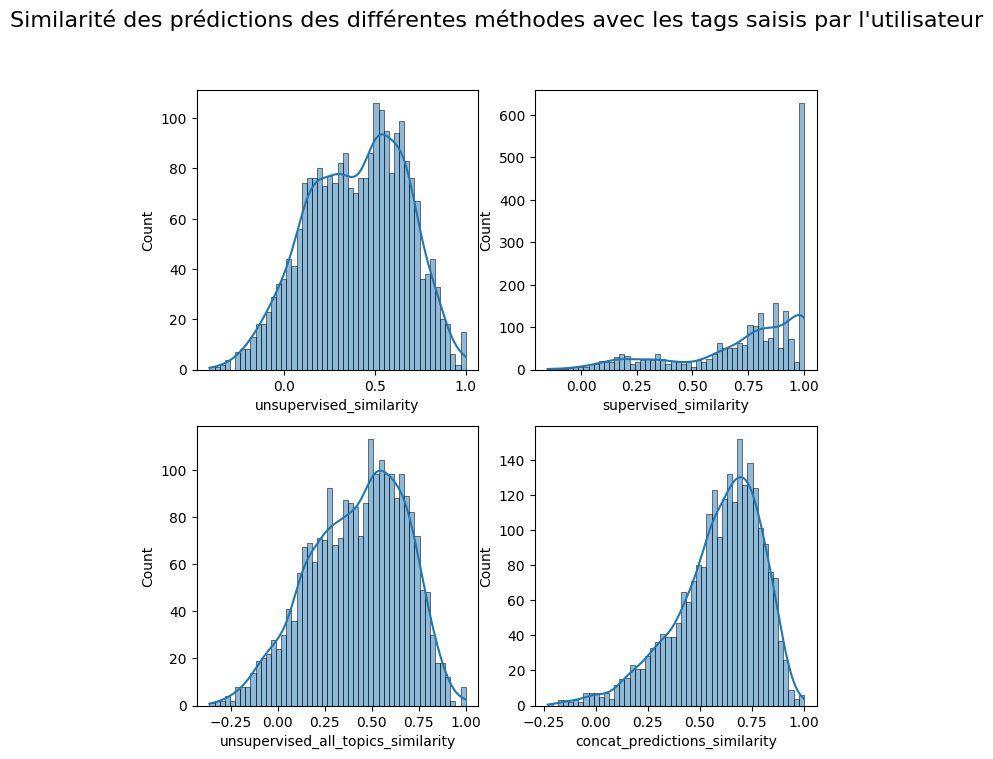

In [313]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(8,8))

axes = [ax1, ax2, ax3, ax4]

i=0
for col in df_comp_pred_display_simi.columns:
    if 'similarity' in col:
        sns.histplot(df_comp_pred_display_simi[col], bins=50, kde=True, ax=axes[i])
        i+=1

plt.suptitle("Similarité des prédictions des différentes méthodes avec les tags saisis par l'utilisateur", fontsize=16);       